In [1]:
import numpy as np # linear algebra
import pandas as pd
from xgboost import plot_importance, plot_tree
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10')

NB : toujours donnée Mois -3 au modele pour quil understant les trends

# Déclaration des variables

In [2852]:

previous_year = 2024 
year = 2025

# MTD_train pour une année c'est le mois qui sert a entrainer le modele pour qui understand the recent trend

MTD_train = 1

# MTD_debut_test, MTD__test pour une année c'est les mois qui sert a tester le modele pour voir il understand the recent trend

MTD_debut_test, MTD_fin_test = 2, 5


# debut_predict, fin_predict pour une année c'est les mois qui sert a faire les prediction par le modele pour voir s'il understand the recent trend

debut_predict, fin_predict = 6, 12

# VISHAY_Without_Backlog

### EDA

In [2856]:
df = pd.read_excel(r'C:\Users\rtekem\OneDrive - Vishay Intertechnology, Inc\Desktop\Machine_Learning_project\IMPUT\Sales forecasting by product line and region\DF_vishay.xlsx')
                                                                                                    
df.head()

C:\Users\rtekem\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Period   REGION  Actual  Blg T-3  Blg T-2       Blg T-1  Blg Total Qty  \
0  201801  AMERICA    16.5      0.0      0.0  0.000000e+00         200223   
1  201801     ASIA    16.5      0.0      0.0  0.000000e+00         277819   
2  201801   EUROPE    16.5      0.0      0.0  0.000000e+00        4679501   
3  201802  AMERICA    20.0      0.0      0.0  1.663386e+06         776733   
4  201802     ASIA    20.0      0.0      0.0  6.561576e+05         396443   

    BACKLOG EUR  Billings EURO Mat/Group  
0  9.002369e+05     1127978.40       FP1  
1  4.155529e+05      726426.63       FP1  
2  3.884839e+06     5273907.40       FP1  
3  1.636298e+06     1059817.80       FP1  
4  6.302381e+05      663998.06       FP1

In [2857]:
df['Period'] = pd.to_datetime(df['Period'].astype(str), format='%Y%m')

In [2858]:
df.tail(30)

Period   REGION  Actual       Blg T-3       Blg T-2       Blg T-1  \
258 2025-03-01  AMERICA    25.0  1.507512e+06  1.999800e+06  2.341248e+06   
259 2025-03-01     ASIA    25.0  1.555275e+06  1.763113e+06  2.070321e+06   
260 2025-03-01   EUROPE    25.0  6.485997e+06  7.798918e+06  8.244714e+06   
261 2025-04-01  AMERICA    19.0  1.292684e+06  1.703688e+06  1.714897e+06   
262 2025-04-01     ASIA    19.0  1.413438e+06  1.516923e+06  1.902752e+06   
263 2025-04-01   EUROPE    19.0  4.826611e+06  5.327718e+06  6.308114e+06   
264 2025-05-01  AMERICA    18.0  8.481915e+05  1.387091e+06  1.750885e+06   
265 2025-05-01     ASIA    18.0  1.479411e+06  1.828923e+06  1.937019e+06   
266 2025-05-01   EUROPE    18.0  3.839780e+06  4.924944e+06  5.625376e+06   
267 2025-06-01  AMERICA    23.0  1.304670e+06  1.883682e+06  2.398461e+06   
268 2025-06-01     ASIA    23.0  2.032185e+06  1.295134e+06  2.530387e+06   
269 2025-06-01   EUROPE    23.0  5.205921e+06  6.497793e+06  7.756563e+06   
270 2025-07-01  AMERICA    19.0  8.290376e+05  1.042155e+06  1.459661e+06   
271 2025-07-01     ASIA    19.0  1.417734e+06  9.017562e+05  1.905211e+06   
272 2025-07-01   EUROPE    19.0  3.457444e+06  4.322539e+06  6.006144e+06   
273 2025-08-01  AMERICA     5.0  3.219911e+05  8.002111e+05  8.677194e+05   
274 2025-08-01     ASIA     5.0  7.067963e+05  7.977363e+05  1.382087e+06   
275 2025-08-01   EUROPE     5.0  1.926043e+06  2.368019e+06  2.793927e+06   
276 2025-09-01  AMERICA    25.0  4.080630e+05  4.759840e+05  8.187882e+05   
277 2025-09-01     ASIA    25.0  1.309769e+06  7.915164e+05  1.759420e+06   
278 2025-09-01   EUROPE    25.0  3.169257e+06  3.853770e+06  5.344733e+06   
279 2025-10-01  AMERICA    20.0  4.252910e+05  4.044390e+05  4.593149e+05   
280 2025-10-01     ASIA    20.0  5.383332e+05  5.698030e+05  1.412635e+06   
281 2025-10-01   EUROPE    20.0  2.190149e+06  2.946893e+06  3.488876e+06   
282 2025-11-01  AMERICA    19.0  2.282571e+05  2.980425e+05  5.600717e+05   
283 2025-11-01     ASIA    19.0  5.690620e+05  5.747473e+05  1.394569e+06   
284 2025-11-01   EUROPE    19.0  2.048333e+06  2.057335e+06  3.010614e+06   
285 2025-12-01  AMERICA    26.0  1.173866e+05  1.709326e+05  3.426315e+05   
286 2025-12-01     ASIA    26.0  4.119240e+05  6.092065e+05  1.655363e+06   
287 2025-12-01   EUROPE    26.0  2.350936e+06  2.763720e+06  3.652395e+06   

     Blg Total Qty   BACKLOG EUR  Billings EURO Mat/Group  
258         389538  2.710795e+06     2905514.25       FP1  
259        8888821  2.075579e+06     2919785.53       FP1  
260        2235042  9.213117e+06    10629234.32       FP1  
261         209852  1.710295e+06     1800583.23       FP1  
262        7726416  1.540899e+06     1511025.01       FP1  
263        1682593  6.836247e+06     5166137.92       FP1  
264         148448  1.399039e+06     1998380.80       FP1  
265       10602153  1.943520e+06     1832104.50       FP1  
266        1310514  5.565573e+06     6324796.96       FP1  
267         278608  2.167255e+06           0.00       FP1  
268        9353500  2.137497e+06           0.00       FP1  
269        1935841  7.983567e+06           0.00       FP1  
270         203163  1.735729e+06           0.00       FP1  
271        7375060  2.101247e+06           0.00       FP1  
272        1682028  6.545976e+06           0.00       FP1  
273         137063  1.202809e+06           0.00       FP1  
274        6933153  1.211676e+06           0.00       FP1  
275         732760  3.123485e+06           0.00       FP1  
276          98991  1.241113e+06           0.00       FP1  
277        9543428  1.870237e+06           0.00       FP1  
278        1234750  6.088072e+06           0.00       FP1  
279          37116  8.421610e+05           0.00       FP1  
280        6597719  1.331474e+06           0.00       FP1  
281         426867  3.997920e+06           0.00       FP1  
282          47471  7.063344e+05           0.00       FP1  
283        7026387  1.525657e+06           0.00       FP1  


In [2859]:
df.shape

(288, 10)

In [2861]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Period         288 non-null    datetime64[ns]
 1   REGION         288 non-null    object        
 2   Actual         288 non-null    float64       
 3   Blg T-3        288 non-null    float64       
 4   Blg T-2        288 non-null    float64       
 5   Blg T-1        288 non-null    float64       
 6   Blg Total Qty  288 non-null    int64         
 7   BACKLOG EUR    288 non-null    float64       
 8   Billings EURO  288 non-null    float64       
 9   Mat/Group      288 non-null    object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 22.6+ KB


In [2863]:
df.columns.values

array(['Period', 'REGION', 'Actual', 'Blg T-3', 'Blg T-2', 'Blg T-1',
       'Blg Total Qty', 'BACKLOG EUR', 'Billings EURO', 'Mat/Group'],
      dtype=object)

In [2864]:
df.dtypes

Period           datetime64[ns]
REGION                   object
Actual                  float64
Blg T-3                 float64
Blg T-2                 float64
Blg T-1                 float64
Blg Total Qty             int64
BACKLOG EUR             float64
Billings EURO           float64
Mat/Group                object
dtype: object

In [2865]:
df.isnull().sum()

Period           0
REGION           0
Actual           0
Blg T-3          0
Blg T-2          0
Blg T-1          0
Blg Total Qty    0
BACKLOG EUR      0
Billings EURO    0
Mat/Group        0
dtype: int64

In [2867]:
df.dtypes.value_counts()

float64           6
object            2
datetime64[ns]    1
int64             1
Name: count, dtype: int64

<Axes: ylabel='count'>

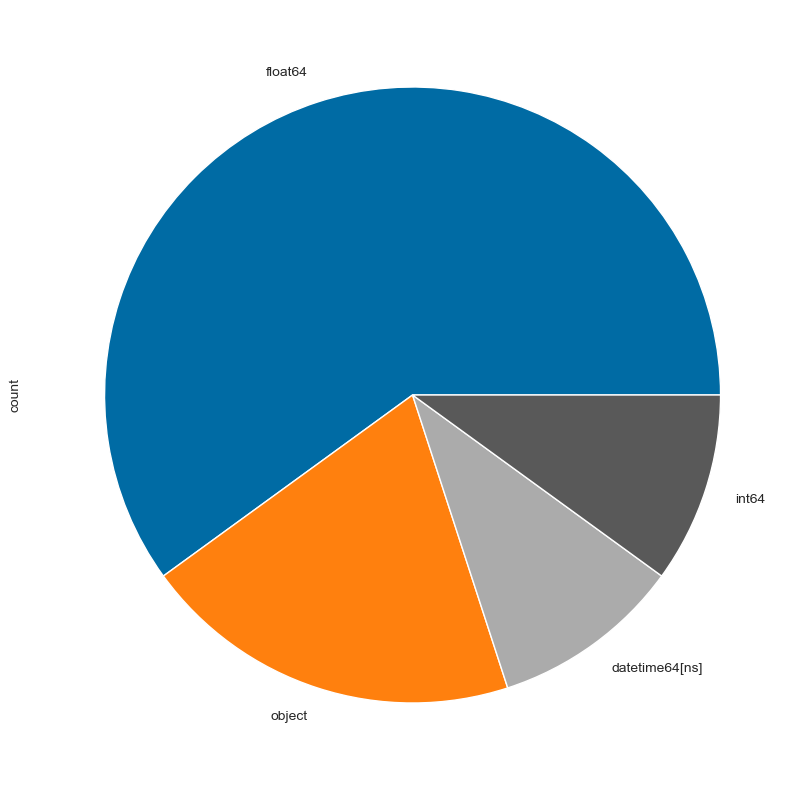

In [2868]:
df.dtypes.value_counts().plot.pie()

df.shape

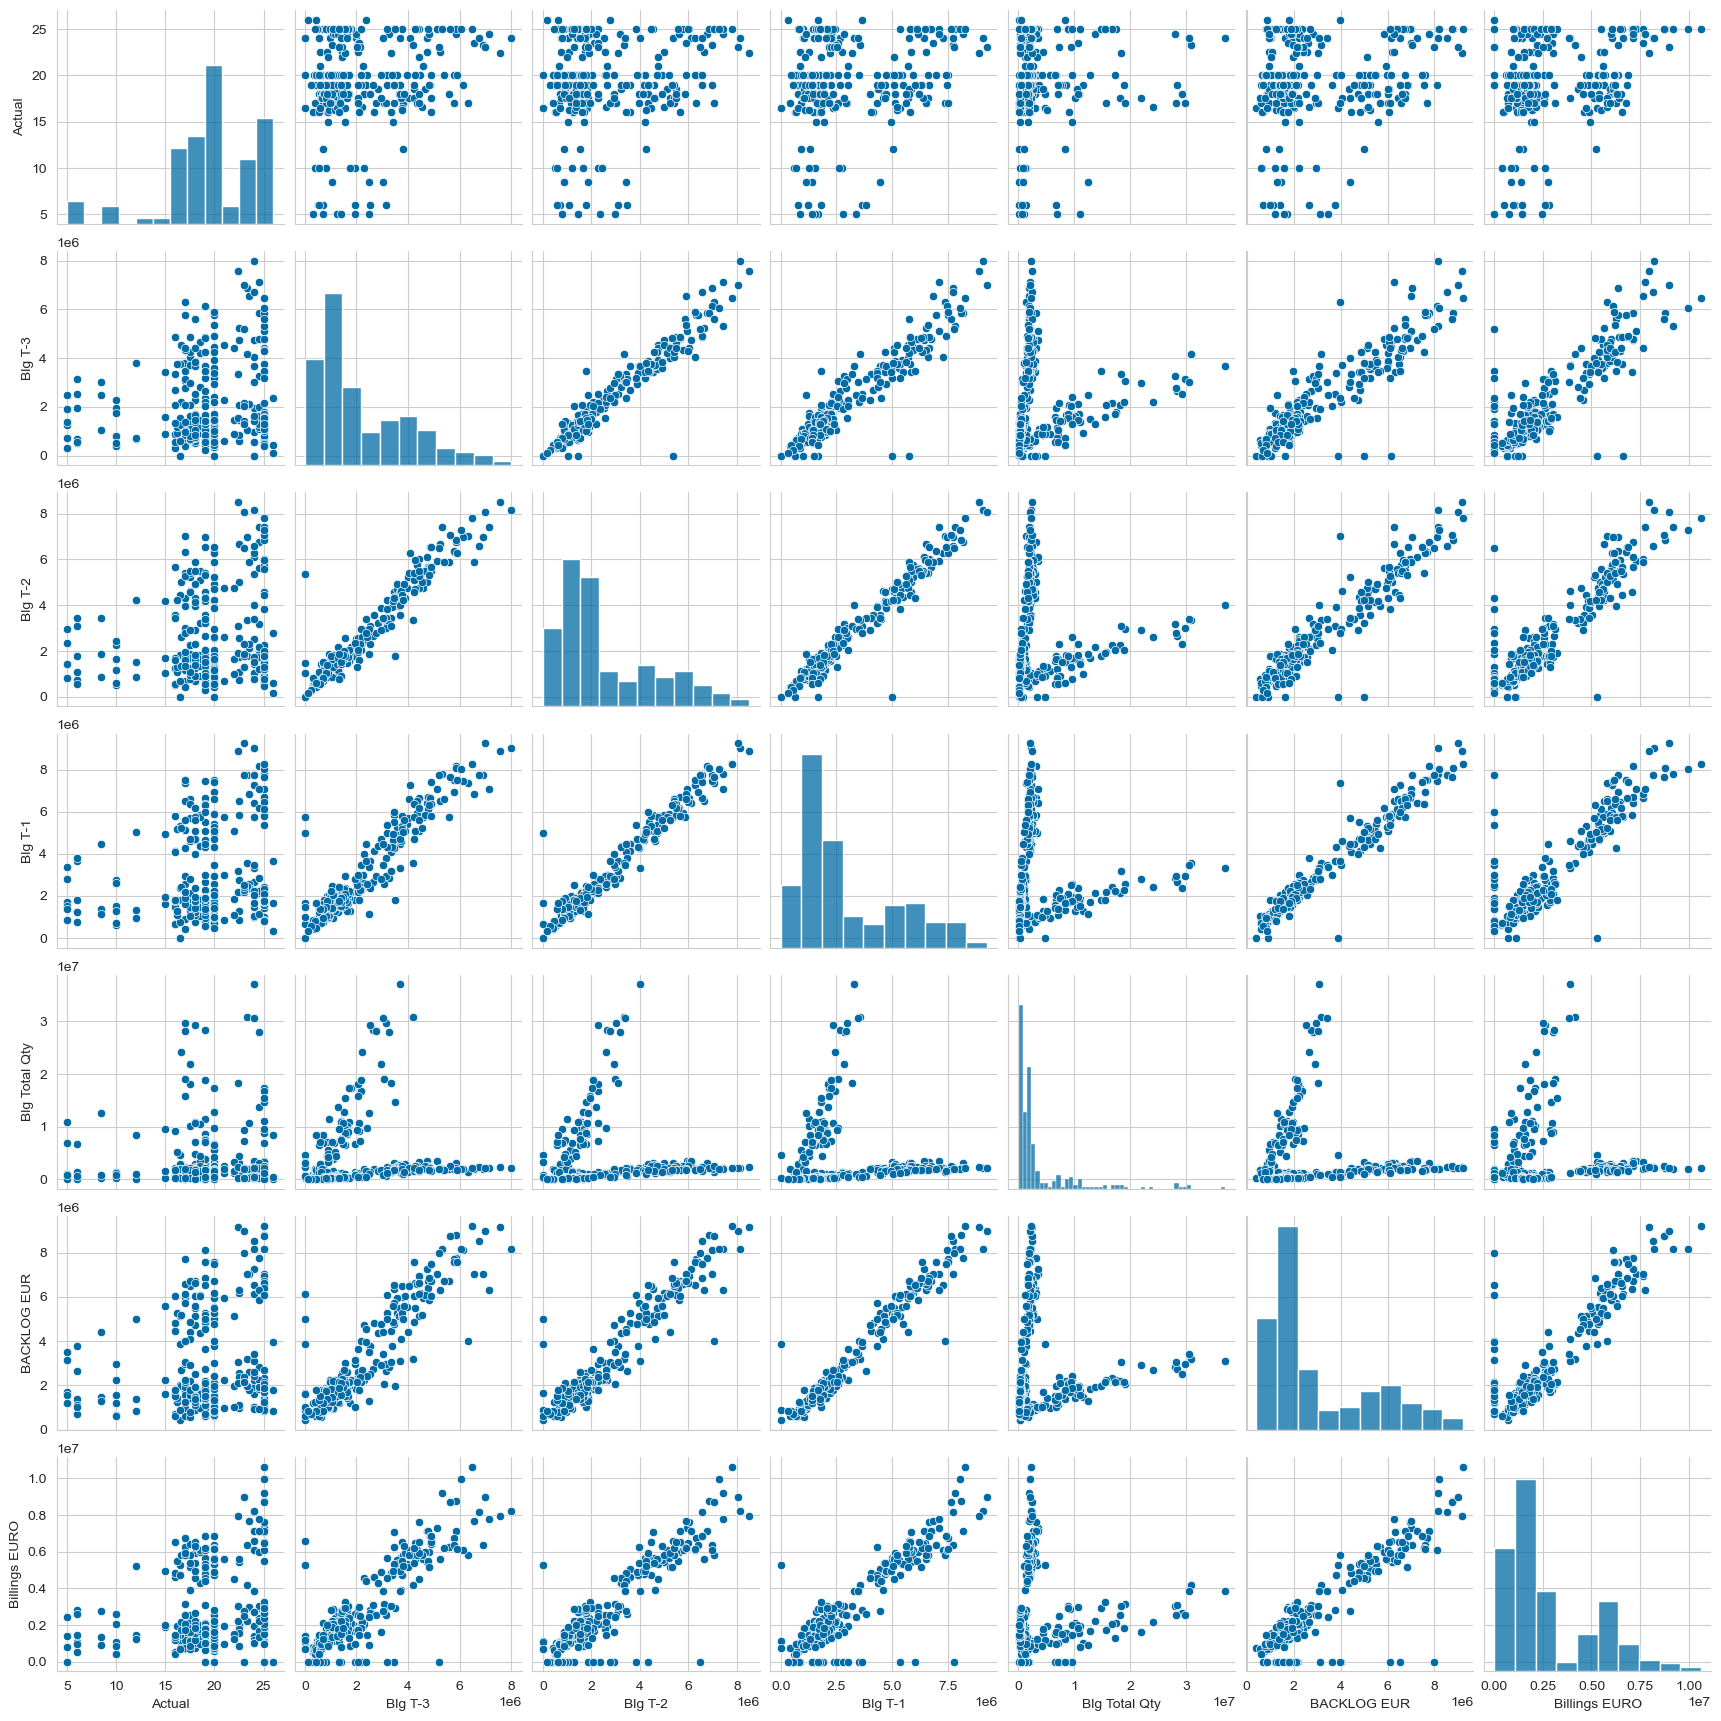

In [2871]:
sns.pairplot(df)

<Axes: xlabel='Period'>

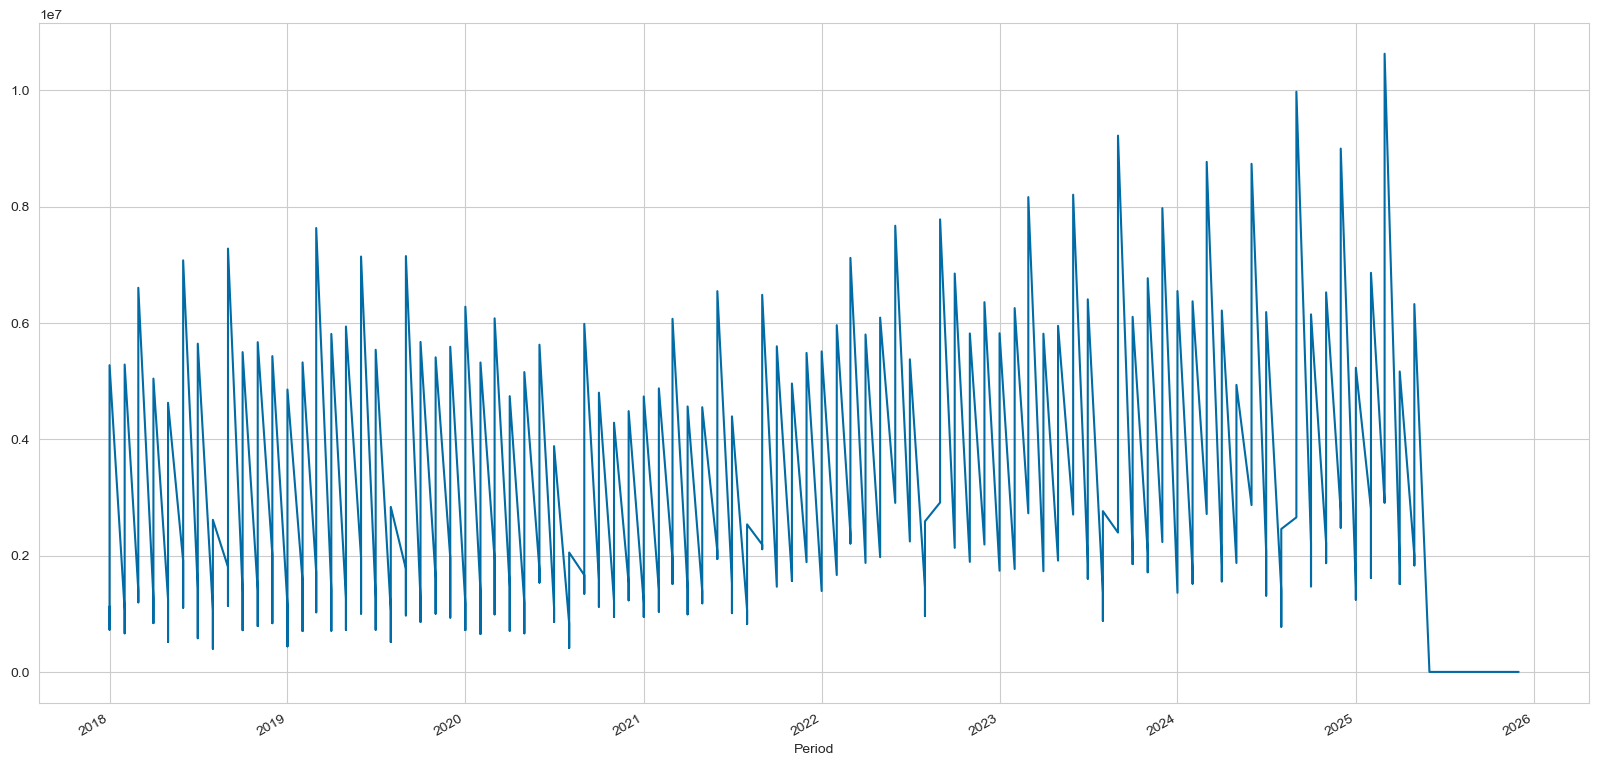

In [2872]:
df.set_index('Period')['Billings EURO'].plot()

array([<Axes: xlabel='Period'>, <Axes: xlabel='Period'>,
       <Axes: xlabel='Period'>], dtype=object)

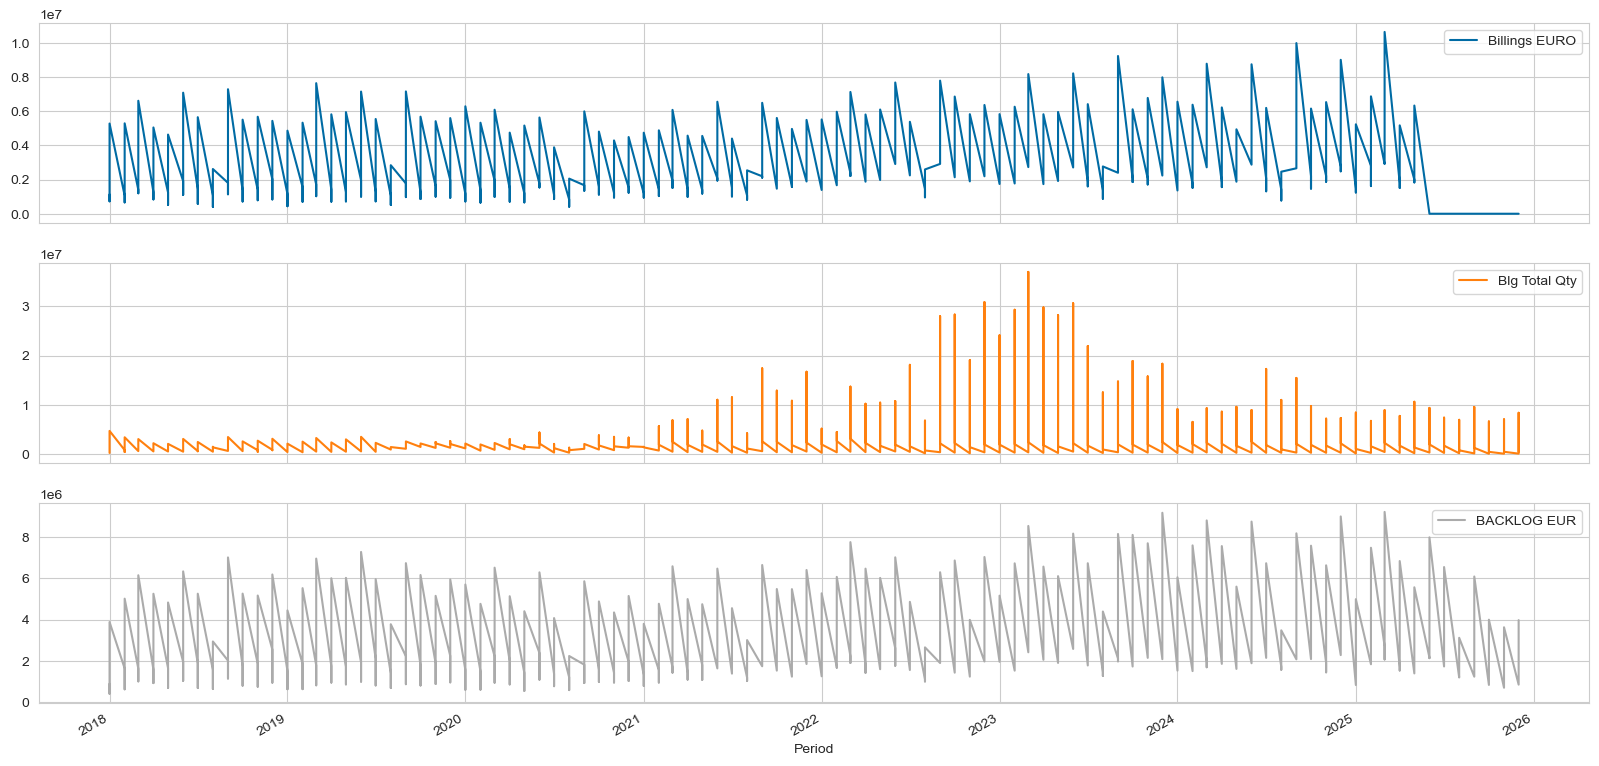

In [2876]:
df.set_index('Period')[['Billings EURO','Blg Total Qty','BACKLOG EUR']].plot(subplots=True)

### Pre-processing

In [2881]:
df

Period   REGION  Actual       Blg T-3       Blg T-2       Blg T-1  \
0   2018-01-01  AMERICA    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
1   2018-01-01     ASIA    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
2   2018-01-01   EUROPE    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
3   2018-02-01  AMERICA    20.0  0.000000e+00  0.000000e+00  1.663386e+06   
4   2018-02-01     ASIA    20.0  0.000000e+00  0.000000e+00  6.561576e+05   
..         ...      ...     ...           ...           ...           ...   
283 2025-11-01     ASIA    19.0  5.690620e+05  5.747473e+05  1.394569e+06   
284 2025-11-01   EUROPE    19.0  2.048333e+06  2.057335e+06  3.010614e+06   
285 2025-12-01  AMERICA    26.0  1.173866e+05  1.709326e+05  3.426315e+05   
286 2025-12-01     ASIA    26.0  4.119240e+05  6.092065e+05  1.655363e+06   
287 2025-12-01   EUROPE    26.0  2.350936e+06  2.763720e+06  3.652395e+06   

     Blg Total Qty   BACKLOG EUR  Billings EURO Mat/Group  
0           200223  9.002369e+05     1127978.40       FP1  
1           277819  4.155529e+05      726426.63       FP1  
2          4679501  3.884839e+06     5273907.40       FP1  
3           776733  1.636298e+06     1059817.80       FP1  
4           396443  6.302381e+05      663998.06       FP1  
..             ...           ...            ...       ...  
283        7026387  1.525657e+06           0.00       FP1  
284         436021  3.631242e+06           0.00       FP1  
285          56580  8.572678e+05           0.00       FP4  
286        8361895  1.785945e+06           0.00       FP2  
287         449730  3.977090e+06           0.00       FP1  

[288 rows x 10 columns]

In [2882]:
df['quarter'] = df['Period'].dt.quarter
df['month'] = df['Period'].dt.month
df['year'] = df['Period'].dt.year

#df['log_Backlog'] = np.log1p(df['BACKLOG EUR'])
df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

In [2883]:
df

Period   REGION  Actual       Blg T-3       Blg T-2       Blg T-1  \
0   2018-01-01  AMERICA    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
1   2018-01-01     ASIA    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
2   2018-01-01   EUROPE    16.5  0.000000e+00  0.000000e+00  0.000000e+00   
3   2018-02-01  AMERICA    20.0  0.000000e+00  0.000000e+00  1.663386e+06   
4   2018-02-01     ASIA    20.0  0.000000e+00  0.000000e+00  6.561576e+05   
..         ...      ...     ...           ...           ...           ...   
283 2025-11-01     ASIA    19.0  5.690620e+05  5.747473e+05  1.394569e+06   
284 2025-11-01   EUROPE    19.0  2.048333e+06  2.057335e+06  3.010614e+06   
285 2025-12-01  AMERICA    26.0  1.173866e+05  1.709326e+05  3.426315e+05   
286 2025-12-01     ASIA    26.0  4.119240e+05  6.092065e+05  1.655363e+06   
287 2025-12-01   EUROPE    26.0  2.350936e+06  2.763720e+06  3.652395e+06   

     Blg Total Qty   BACKLOG EUR  Billings EURO Mat/Group  quarter  month  \
0           200223  9.002369e+05     1127978.40       FP1        1      1   
1           277819  4.155529e+05      726426.63       FP1        1      1   
2          4679501  3.884839e+06     5273907.40       FP1        1      1   
3           776733  1.636298e+06     1059817.80       FP1        1      2   
4           396443  6.302381e+05      663998.06       FP1        1      2   
..             ...           ...            ...       ...      ...    ...   
283        7026387  1.525657e+06           0.00       FP1        4     11   
284         436021  3.631242e+06           0.00       FP1        4     11   
285          56580  8.572678e+05           0.00       FP4        4     12   
286        8361895  1.785945e+06           0.00       FP2        4     12   
287         449730  3.977090e+06           0.00       FP1        4     12   

     year   quarter_sin   quarter_cos  
0    2018  1.000000e+00  6.123234e-17  
1    2018  1.000000e+00  6.123234e-17  
2    2018  1.000000e+00  6.123234e-17  
3    2018  1.000000e+00  6.123234e-17  
4    2018  1.000000e+00  6.123234e-17  
..    ...           ...           ...  
283  2025 -2.449294e-16  1.000000e+00  
284  2025 -2.449294e-16  1.000000e+00  
285  2025 -2.449294e-16  1.000000e+00  
286  2025 -2.449294e-16  1.000000e+00  
287  2025 -2.449294e-16  1.000000e+00  

[288 rows x 15 columns]

In [2884]:
df=df.drop(['Period','Mat/Group','Blg T-3','Blg T-2','Blg T-1','Blg Total Qty','BACKLOG EUR'],axis=1)
#df=df.drop(['Period','Blg T-3','Mat/Group'],axis=1)

In [2885]:
#df['REGION'] = df['REGION'].replace({'AMERICA': 'NA', 'EUROPE': 'EU', 'ASIA': 'AP'})

In [2886]:
df

REGION  Actual  Billings EURO  quarter  month  year   quarter_sin  \
0    AMERICA    16.5     1127978.40        1      1  2018  1.000000e+00   
1       ASIA    16.5      726426.63        1      1  2018  1.000000e+00   
2     EUROPE    16.5     5273907.40        1      1  2018  1.000000e+00   
3    AMERICA    20.0     1059817.80        1      2  2018  1.000000e+00   
4       ASIA    20.0      663998.06        1      2  2018  1.000000e+00   
..       ...     ...            ...      ...    ...   ...           ...   
283     ASIA    19.0           0.00        4     11  2025 -2.449294e-16   
284   EUROPE    19.0           0.00        4     11  2025 -2.449294e-16   
285  AMERICA    26.0           0.00        4     12  2025 -2.449294e-16   
286     ASIA    26.0           0.00        4     12  2025 -2.449294e-16   
287   EUROPE    26.0           0.00        4     12  2025 -2.449294e-16   

      quarter_cos  
0    6.123234e-17  
1    6.123234e-17  
2    6.123234e-17  
3    6.123234e-17  
4    6.123234e-17  
..            ...  
283  1.000000e+00  
284  1.000000e+00  
285  1.000000e+00  
286  1.000000e+00  
287  1.000000e+00  

[288 rows x 8 columns]

In [2887]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Initialisation de l'encodeur avec sparse_output=False
encoder = OneHotEncoder(sparse_output=False)

# Encodage de la colonne REGION
encoded_array = encoder.fit_transform(df[['REGION']])

# Récupération des noms de colonnes générés
column_names = encoder.get_feature_names_out(['REGION'])

# ✅ Vérification du format de sortie
print(f"Shape of encoded array: {encoded_array.shape}")  # Doit être (180, 3)
print(f"Feature names: {column_names}")  # Doit être ['REGION_AP', 'REGION_EU', 'REGION_NA']

# ✅ Convertir correctement en DataFrame
df_encoded = pd.DataFrame(encoded_array, columns=column_names, index=df.index)

# ✅ Fusion avec df sans REGION
df = df.drop(columns=['REGION']).join(df_encoded)


Shape of encoded array: (288, 3)
Feature names: ['REGION_AMERICA' 'REGION_ASIA' 'REGION_EUROPE']


In [2888]:
df.head()

Actual  Billings EURO  quarter  month  year  quarter_sin   quarter_cos  \
0    16.5     1127978.40        1      1  2018          1.0  6.123234e-17   
1    16.5      726426.63        1      1  2018          1.0  6.123234e-17   
2    16.5     5273907.40        1      1  2018          1.0  6.123234e-17   
3    20.0     1059817.80        1      2  2018          1.0  6.123234e-17   
4    20.0      663998.06        1      2  2018          1.0  6.123234e-17   

   REGION_AMERICA  REGION_ASIA  REGION_EUROPE  
0             1.0          0.0            0.0  
1             0.0          1.0            0.0  
2             0.0          0.0            1.0  
3             1.0          0.0            0.0  
4             0.0          1.0            0.0

#### To change

In [2890]:
df_train=df[df['year']< previous_year]
X_train=df_train.drop(['Billings EURO'],axis=1)
y_train=df_train['Billings EURO']

In [2891]:
df_test = df[((df['year'] == previous_year)) | ((df['year'] == year) & (df['month'] < 1))]

X_test=df_test.drop(['Billings EURO'],axis=1)
y_test=df_test['Billings EURO']

In [2892]:
df_test.shape

(36, 10)

In [2893]:
df_test.head(5)

Actual  Billings EURO  quarter  month  year  quarter_sin   quarter_cos  \
216    16.0     1360570.66        1      1  2024          1.0  6.123234e-17   
217    16.0     1459936.67        1      1  2024          1.0  6.123234e-17   
218    16.0     6548783.75        1      1  2024          1.0  6.123234e-17   
219    20.0     1735804.69        1      2  2024          1.0  6.123234e-17   
220    20.0     1517802.60        1      2  2024          1.0  6.123234e-17   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  
216             1.0          0.0            0.0  
217             0.0          1.0            0.0  
218             0.0          0.0            1.0  
219             1.0          0.0            0.0  
220             0.0          1.0            0.0

In [2894]:
df_test.tail(5)

Actual  Billings EURO  quarter  month  year   quarter_sin  quarter_cos  \
247    18.0     1870666.90        4     11  2024 -2.449294e-16          1.0   
248    18.0     6526148.72        4     11  2024 -2.449294e-16          1.0   
249    23.0     2751240.45        4     12  2024 -2.449294e-16          1.0   
250    23.0     2480371.78        4     12  2024 -2.449294e-16          1.0   
251    23.0     8998266.29        4     12  2024 -2.449294e-16          1.0   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  
247             0.0          1.0            0.0  
248             0.0          0.0            1.0  
249             1.0          0.0            0.0  
250             0.0          1.0            0.0  
251             0.0          0.0            1.0

In [2895]:
from sklearn.preprocessing import StandardScaler

# Sélection des colonnes numériques à standardiser

  # 'Billings EURO' est la cible, donc on ne la touche pas

#numeric_cols = ['Blg T-1','BACKLOG EUR', 'Blg Total Qty']
#numeric_cols = ['Blg T-2','Blg T-1','BACKLOG EUR', 'Blg Total Qty']
 #numeric_cols = ['Blg T-3','Blg T-2','Blg T-1','Blg Total Qty', 'BACKLOG EUR']
# Initialisation du scaler
 #scaler = StandardScaler()

# Standardisation des données d'entraînement et de test
 #X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
 #X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [2896]:
X_train.shape,X_test.shape

((216, 9), (36, 9))

In [2897]:
X_train.head(5)

Actual  quarter  month  year  quarter_sin   quarter_cos  REGION_AMERICA  \
0    16.5        1      1  2018          1.0  6.123234e-17             1.0   
1    16.5        1      1  2018          1.0  6.123234e-17             0.0   
2    16.5        1      1  2018          1.0  6.123234e-17             0.0   
3    20.0        1      2  2018          1.0  6.123234e-17             1.0   
4    20.0        1      2  2018          1.0  6.123234e-17             0.0   

   REGION_ASIA  REGION_EUROPE  
0          0.0            0.0  
1          1.0            0.0  
2          0.0            1.0  
3          0.0            0.0  
4          1.0            0.0

In [2898]:
X_test.head(5)

Actual  quarter  month  year  quarter_sin   quarter_cos  REGION_AMERICA  \
216    16.0        1      1  2024          1.0  6.123234e-17             1.0   
217    16.0        1      1  2024          1.0  6.123234e-17             0.0   
218    16.0        1      1  2024          1.0  6.123234e-17             0.0   
219    20.0        1      2  2024          1.0  6.123234e-17             1.0   
220    20.0        1      2  2024          1.0  6.123234e-17             0.0   

     REGION_ASIA  REGION_EUROPE  
216          0.0            0.0  
217          1.0            0.0  
218          0.0            1.0  
219          0.0            0.0  
220          1.0            0.0

In [2899]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)

In [2900]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  753608.221401
MAE :  529474.708611


In [2901]:
from sklearn.metrics import mean_absolute_error as MAE
import numpy as np

mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)


MAE en pourcentage : 14.54%


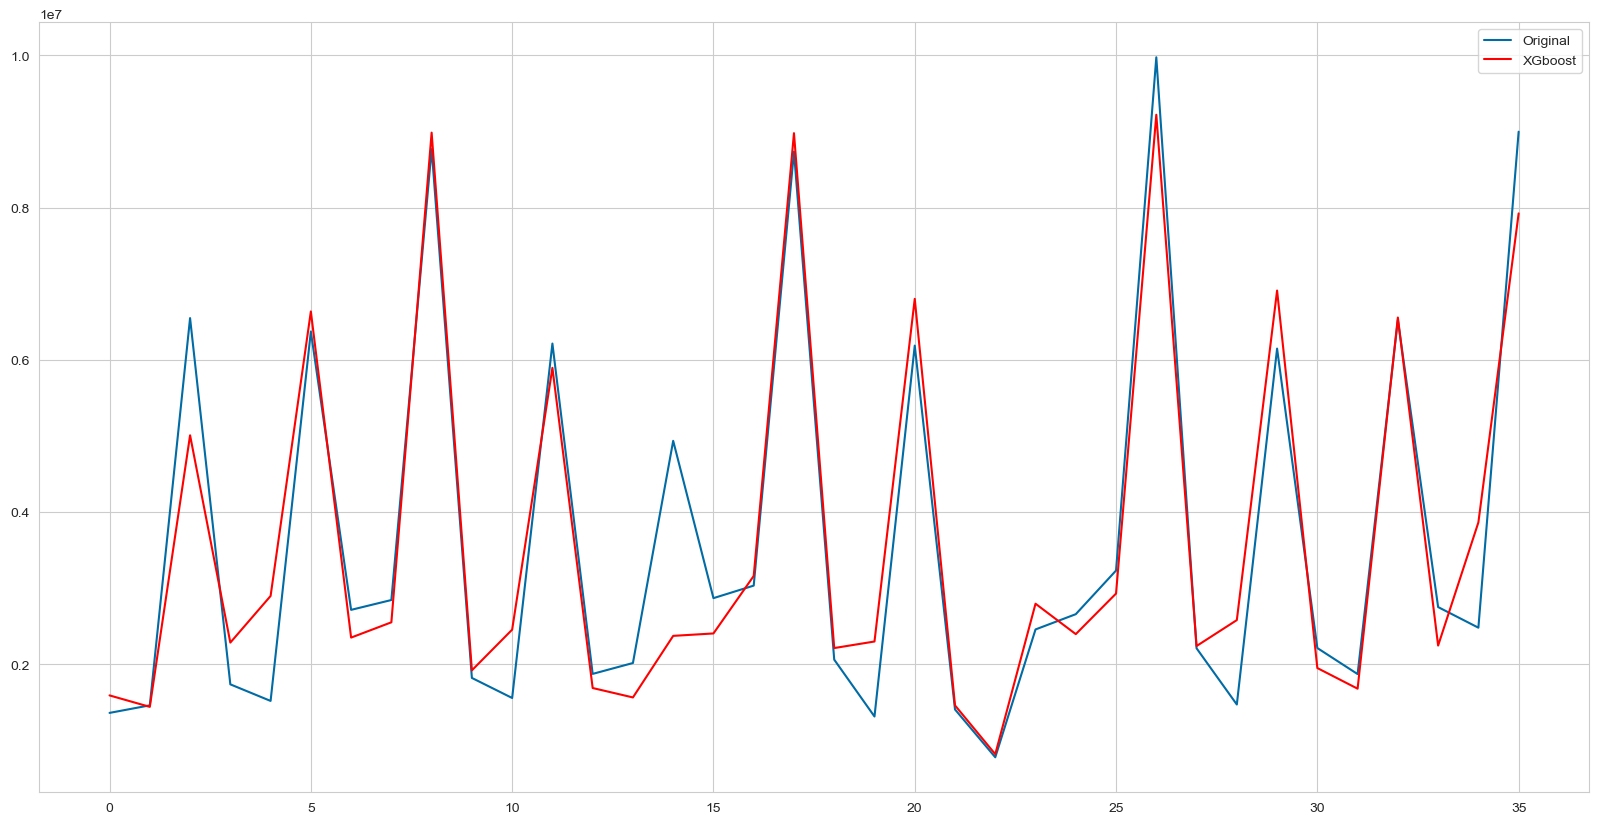

In [2902]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [2903]:
import pandas as pd

# Conversion de y_test et yhat en DataFrame avec les mêmes index que X_test
df_results = X_test.copy()  # Copie X_test pour ne pas modifier l'original
df_results["Valeur Réelle"] = y_test.values  # Ajout de y_test
df_results["Prédiction"] = yhat  # Ajout des prédictions


In [2904]:
# Affichage des premières lignes
df_results.head()

Actual  quarter  month  year  quarter_sin   quarter_cos  REGION_AMERICA  \
216    16.0        1      1  2024          1.0  6.123234e-17             1.0   
217    16.0        1      1  2024          1.0  6.123234e-17             0.0   
218    16.0        1      1  2024          1.0  6.123234e-17             0.0   
219    20.0        1      2  2024          1.0  6.123234e-17             1.0   
220    20.0        1      2  2024          1.0  6.123234e-17             0.0   

     REGION_ASIA  REGION_EUROPE  Valeur Réelle   Prédiction  
216          0.0            0.0     1360570.66  1590538.750  
217          1.0            0.0     1459936.67  1439827.875  
218          0.0            1.0     6548783.75  5008840.000  
219          0.0            0.0     1735804.69  2284522.000  
220          1.0            0.0     1517802.60  2897181.500

In [2905]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Définition des hyperparamètres avec un plus grand espace de recherche
params = {
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [i / 10.0 for i in range(0, 8)],
    'subsample': [i / 10.0 for i in range(5, 11)],
    'colsample_bytree': [i / 10.0 for i in range(5, 11)],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Ajout du learning rate
    'n_estimators': [100, 500, 1000, 2000]  # Augmentation du nombre d'arbres
}

# Initialisation de XGBoost
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

# RandomizedSearchCV pour un tuning plus rapide
random_search = RandomizedSearchCV(xgb_reg, param_distributions=params, 
                                   n_iter=30, cv=5, verbose=1, n_jobs=-1)

# Entraînement du modèle optimisé
random_search.fit(X_train, y_train)

# Meilleur modèle trouvé
best_xgb = random_search.best_estimator_
print("Meilleur score R2 :", r2_score(y_test, best_xgb.predict(X_test)))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleur score R2 : 0.9360212258378833


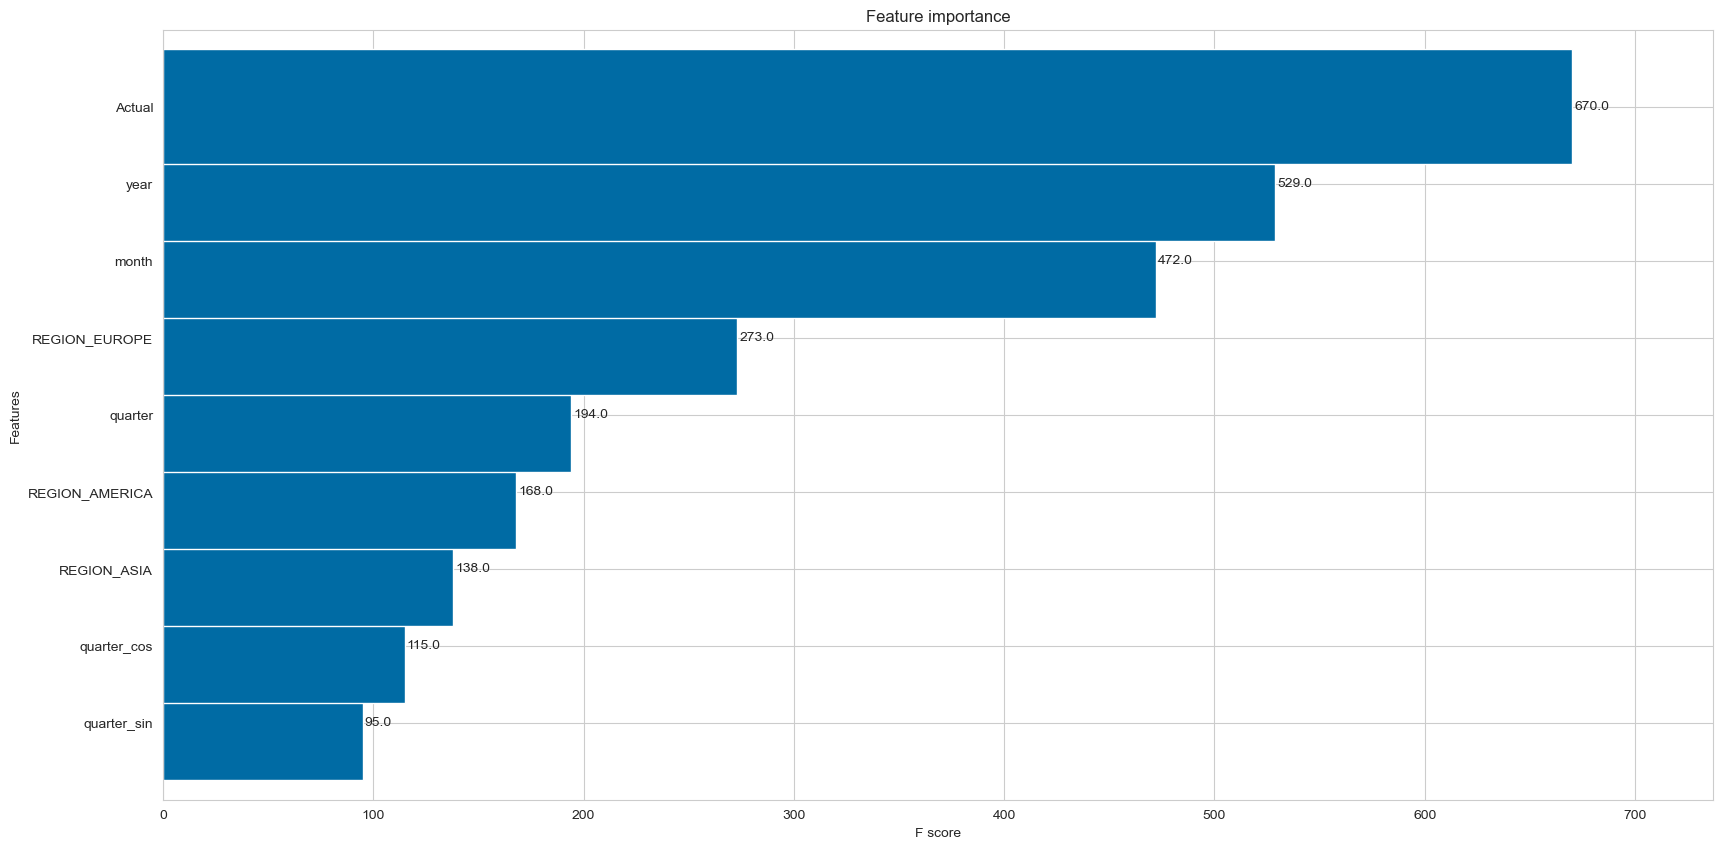

In [2906]:
_ = plot_importance(best_xgb, height=1.5)

In [2907]:
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [2908]:
yhat = random_search.predict(X_test)
rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  650514.477395
MAE :  481546.292639


In [2909]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 13.22%


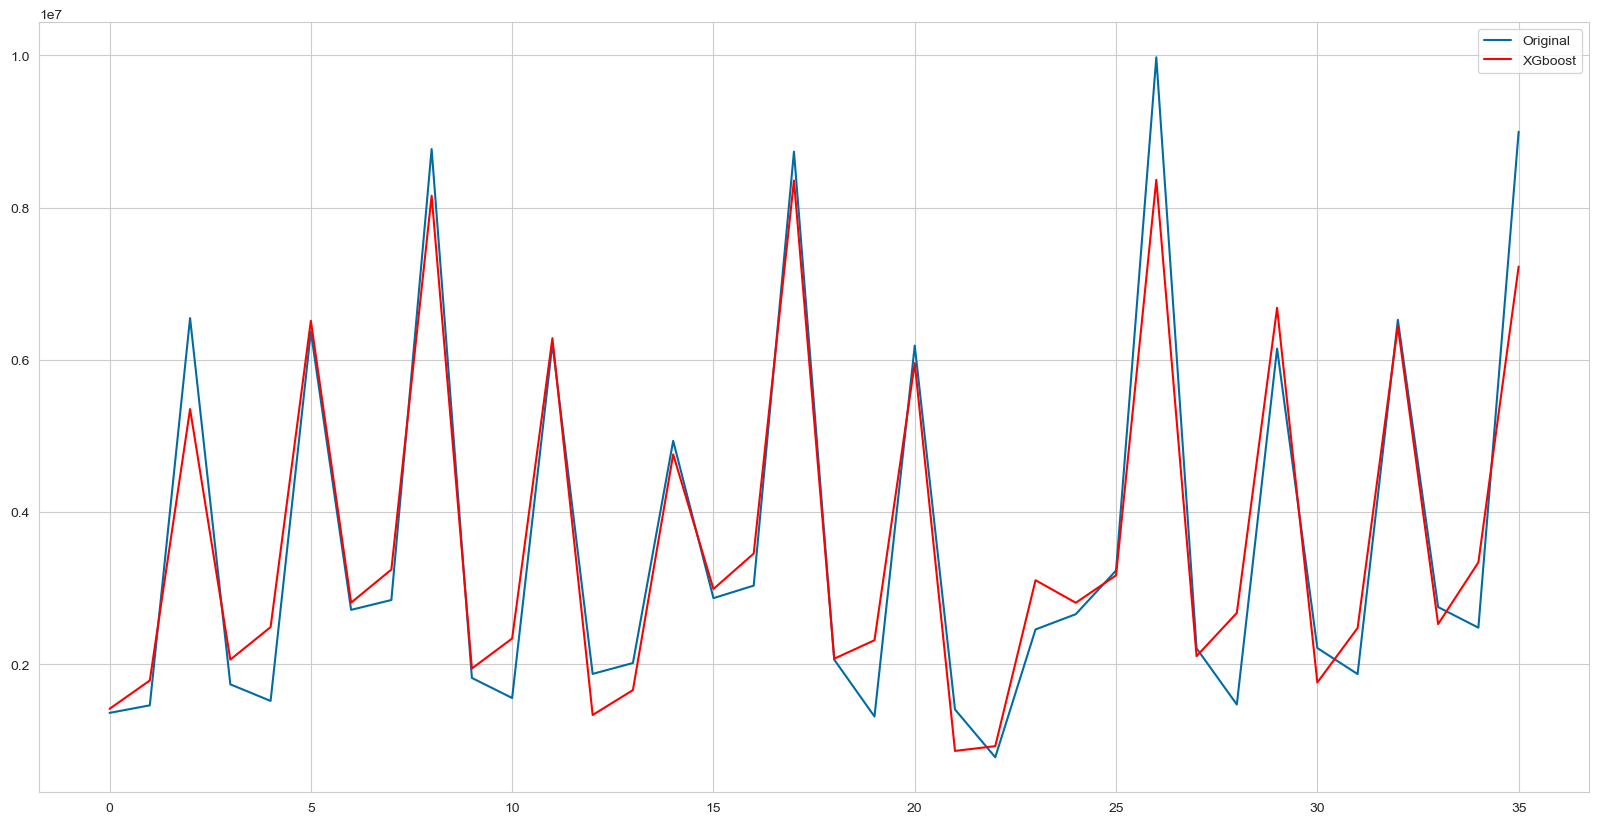

In [2910]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

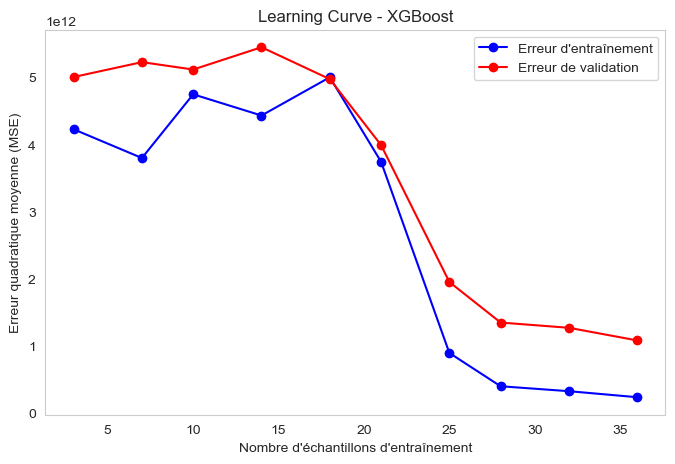

In [2911]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Définition des splits temporels
tscv = TimeSeriesSplit(n_splits=5)

# Calcul de la learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Conversion en erreurs positives (MSE)
train_errors = -train_scores.mean(axis=1)
val_errors = -val_scores.mean(axis=1)

# Affichage des courbes
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors, "o-", label="Erreur d'entraînement", color="blue")
plt.plot(train_sizes, val_errors, "o-", label="Erreur de validation", color="red")

plt.xlabel("Nombre d'échantillons d'entraînement")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("Learning Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()

In [2912]:
import optuna
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.model_selection import train_test_split

# Fonction d'optimisation avec Optuna
def objective(trial):
    # Espace de recherche des hyperparamètres
    params = {
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.7, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 500, 1000, 2000]),
        'n_jobs': -1,
        'objective': 'reg:squarederror'
    }

    # Initialisation du modèle
    xgb_reg = xgb.XGBRegressor(**params)

    # Entraînement du modèle
    xgb_reg.fit(X_train, y_train)

    # Prédictions sur le test set
    y_pred = xgb_reg.predict(X_test)

    # Calcul du RMSE
    rmse = np.sqrt(MSE(y_test, y_pred))

    return rmse  # On minimise le RMSE

# Lancement de l'optimisation avec Optuna
study = optuna.create_study(direction="minimize")  # Minimiser le RMSE
study.optimize(objective, n_trials=30)

# Meilleurs hyperparamètres trouvés
best_params = study.best_params
print("Meilleurs hyperparamètres :", best_params)

# Reconstruction du meilleur modèle avec les hyperparamètres optimaux
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)

# Prédictions finales
yhat = best_xgb.predict(X_test)



[I 2025-06-06 14:32:17,714] A new study created in memory with name: no-name-e5435c3f-8db0-4ede-a42e-94c08dbc5e54
C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\1853738138.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
[I 2025-06-06 14:32:18,299] Trial 0 finished with value: 605184.4211424753 and parameters: {'min_child_weight': 2, 'gamma': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 3, 'learning_rate': 0.02916467403540789, 'n_estimators': 500}. Best is trial 0 with value: 605184.4211424753.
C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\1853738138.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Meilleurs hyperparamètres : {'min_child_weight': 1, 'gamma': 0.5, 'subsample': 0.6, 'colsample_bytree': 0.5, 'max_depth': 7, 'learning_rate': 0.03600339076477854, 'n_estimators': 1000}


In [2913]:
# Évaluation du modèle optimisé
rmse = np.sqrt(MSE(y_test, yhat))
r2 = r2_score(y_test, yhat)

print("Meilleur score R2 :", r2)
print("RMSE : % f" % (rmse))

Meilleur score R2 : 0.9522774047867351
RMSE :  561824.967779


In [2914]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 12.20%


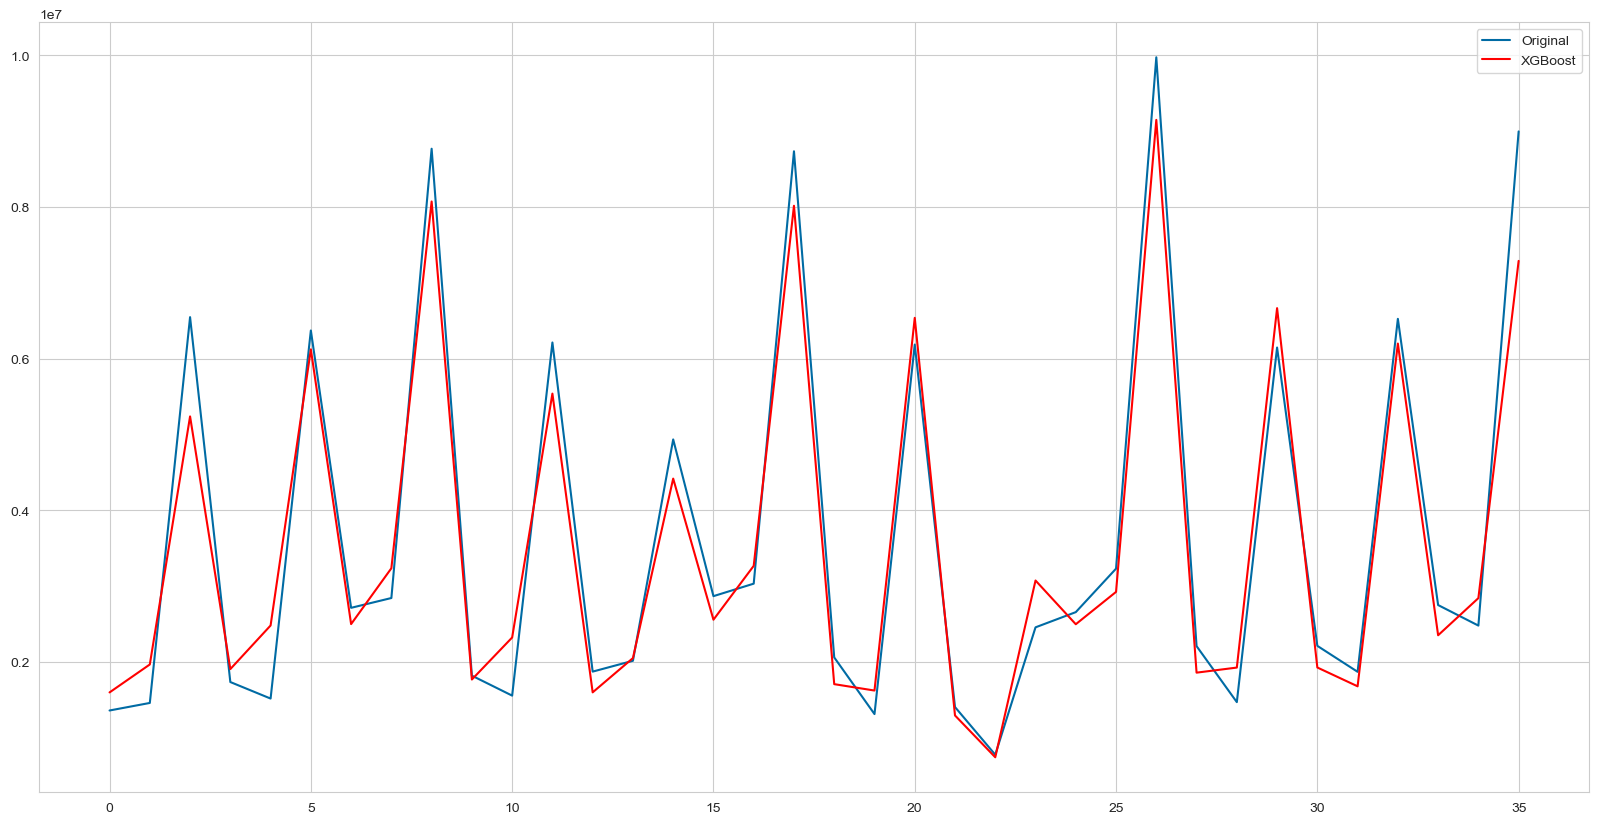

In [2915]:
# Affichage des résultats
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGBoost')
plt.legend()
plt.show()

In [2916]:


# Création du DataFrame final
df_result1 = pd.concat([
    X_test.reset_index(drop=True),
    pd.Series(y_test, name='y_test').reset_index(drop=True),
    pd.Series(yhat, name='yhat').reset_index(drop=True)
], axis=1)


In [2917]:
df_result1.tail(10)

Actual  quarter  month  year   quarter_sin   quarter_cos  REGION_AMERICA  \
26    25.0        3      9  2024 -1.000000e+00 -1.836970e-16             0.0   
27    20.0        4     10  2024 -2.449294e-16  1.000000e+00             1.0   
28    20.0        4     10  2024 -2.449294e-16  1.000000e+00             0.0   
29    20.0        4     10  2024 -2.449294e-16  1.000000e+00             0.0   
30    18.0        4     11  2024 -2.449294e-16  1.000000e+00             1.0   
31    18.0        4     11  2024 -2.449294e-16  1.000000e+00             0.0   
32    18.0        4     11  2024 -2.449294e-16  1.000000e+00             0.0   
33    23.0        4     12  2024 -2.449294e-16  1.000000e+00             1.0   
34    23.0        4     12  2024 -2.449294e-16  1.000000e+00             0.0   
35    23.0        4     12  2024 -2.449294e-16  1.000000e+00             0.0   

    REGION_ASIA  REGION_EUROPE      y_test         yhat  
26          0.0            1.0  9976222.48  9150618.000  
27          0.0            0.0  2209711.89  1859616.000  
28          1.0            0.0  1470779.65  1926572.875  
29          0.0            1.0  6147877.81  6667318.000  
30          0.0            0.0  2212919.30  1927538.875  
31          1.0            0.0  1870666.90  1679300.125  
32          0.0            1.0  6526148.72  6200095.000  
33          0.0            0.0  2751240.45  2352842.500  
34          1.0            0.0  2480371.78  2842644.000  
35          0.0            1.0  8998266.29  7290583.000

#### To change

In [2919]:
df_train = df[(df['year'] < year) | ((df['year'] == year) & (df['month'] == MTD_train))]

X_train=df_train.drop(['Billings EURO'],axis=1)
y_train=df_train['Billings EURO']

In [2920]:
#df_test=df[df['year']>=2024]
df_test = df[(df['year'] == year) & (df['month'].between(MTD_debut_test, MTD_fin_test))]


X_test=df_test.drop(['Billings EURO'],axis=1)
y_test=df_test['Billings EURO']

In [2921]:
df_train.tail()

Actual  Billings EURO  quarter  month  year   quarter_sin   quarter_cos  \
250    23.0     2480371.78        4     12  2024 -2.449294e-16  1.000000e+00   
251    23.0     8998266.29        4     12  2024 -2.449294e-16  1.000000e+00   
252    12.0     1456409.35        1      1  2025  1.000000e+00  6.123234e-17   
253    12.0     1243551.27        1      1  2025  1.000000e+00  6.123234e-17   
254    12.0     5229730.74        1      1  2025  1.000000e+00  6.123234e-17   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  
250             0.0          1.0            0.0  
251             0.0          0.0            1.0  
252             1.0          0.0            0.0  
253             0.0          1.0            0.0  
254             0.0          0.0            1.0

In [2922]:
df_test.head()

Actual  Billings EURO  quarter  month  year  quarter_sin   quarter_cos  \
255    20.0     2805945.81        1      2  2025          1.0  6.123234e-17   
256    20.0     1617150.54        1      2  2025          1.0  6.123234e-17   
257    20.0     6862262.22        1      2  2025          1.0  6.123234e-17   
258    25.0     2905514.25        1      3  2025          1.0  6.123234e-17   
259    25.0     2919785.53        1      3  2025          1.0  6.123234e-17   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  
255             1.0          0.0            0.0  
256             0.0          1.0            0.0  
257             0.0          0.0            1.0  
258             1.0          0.0            0.0  
259             0.0          1.0            0.0

In [2923]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)

In [2924]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  714514.751160
MAE :  453422.337083


In [2925]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 11.73%


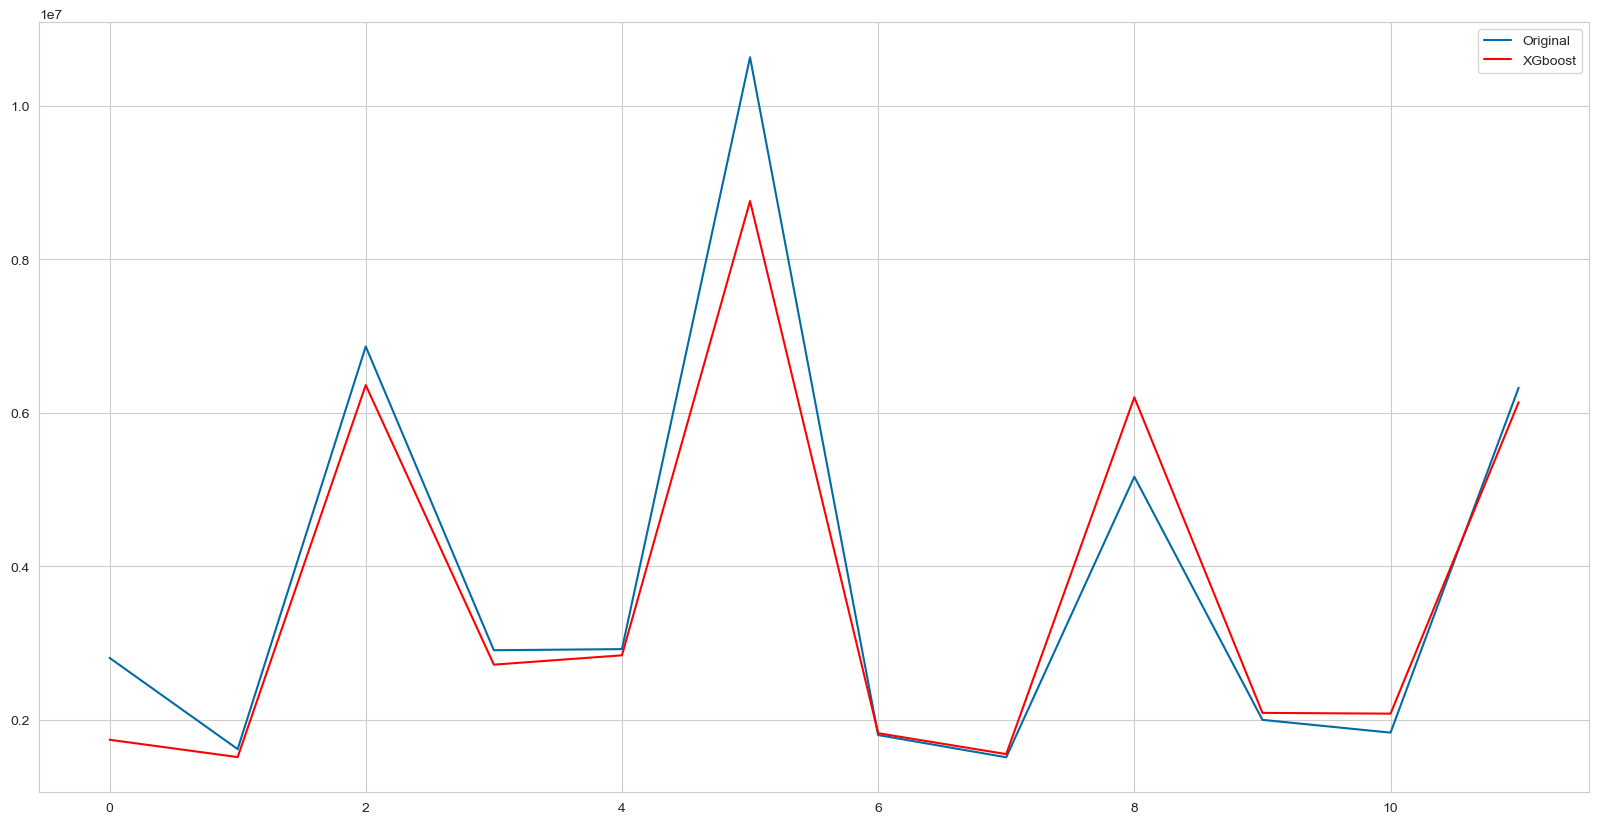

In [2926]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [2927]:
# Conversion de y_test et yhat en DataFrame avec les mêmes index que X_test
df_results = X_test.copy()  # Copie X_test pour ne pas modifier l'original
df_results["Valeur Réelle"] = y_test.values  # Ajout de y_test
df_results["Prédiction"] = yhat  # Ajout des prédictions

In [2928]:
# Définition des hyperparamètres avec un plus grand espace de recherche
params = {
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [i / 10.0 for i in range(0, 8)],
    'subsample': [i / 10.0 for i in range(5, 11)],
    'colsample_bytree': [i / 10.0 for i in range(5, 11)],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Ajout du learning rate
    'n_estimators': [100, 500, 1000, 2000]  # Augmentation du nombre d'arbres
}

# Initialisation de XGBoost
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

# RandomizedSearchCV pour un tuning plus rapide
random_search = RandomizedSearchCV(xgb_reg, param_distributions=params, 
                                   n_iter=30, cv=5, verbose=1, n_jobs=-1)

# Entraînement du modèle optimisé
random_search.fit(X_train, y_train)

# Meilleur modèle trouvé
best_xgb = random_search.best_estimator_
print("Meilleur score R2 :", r2_score(y_test, best_xgb.predict(X_test)))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleur score R2 : 0.9321586674315554


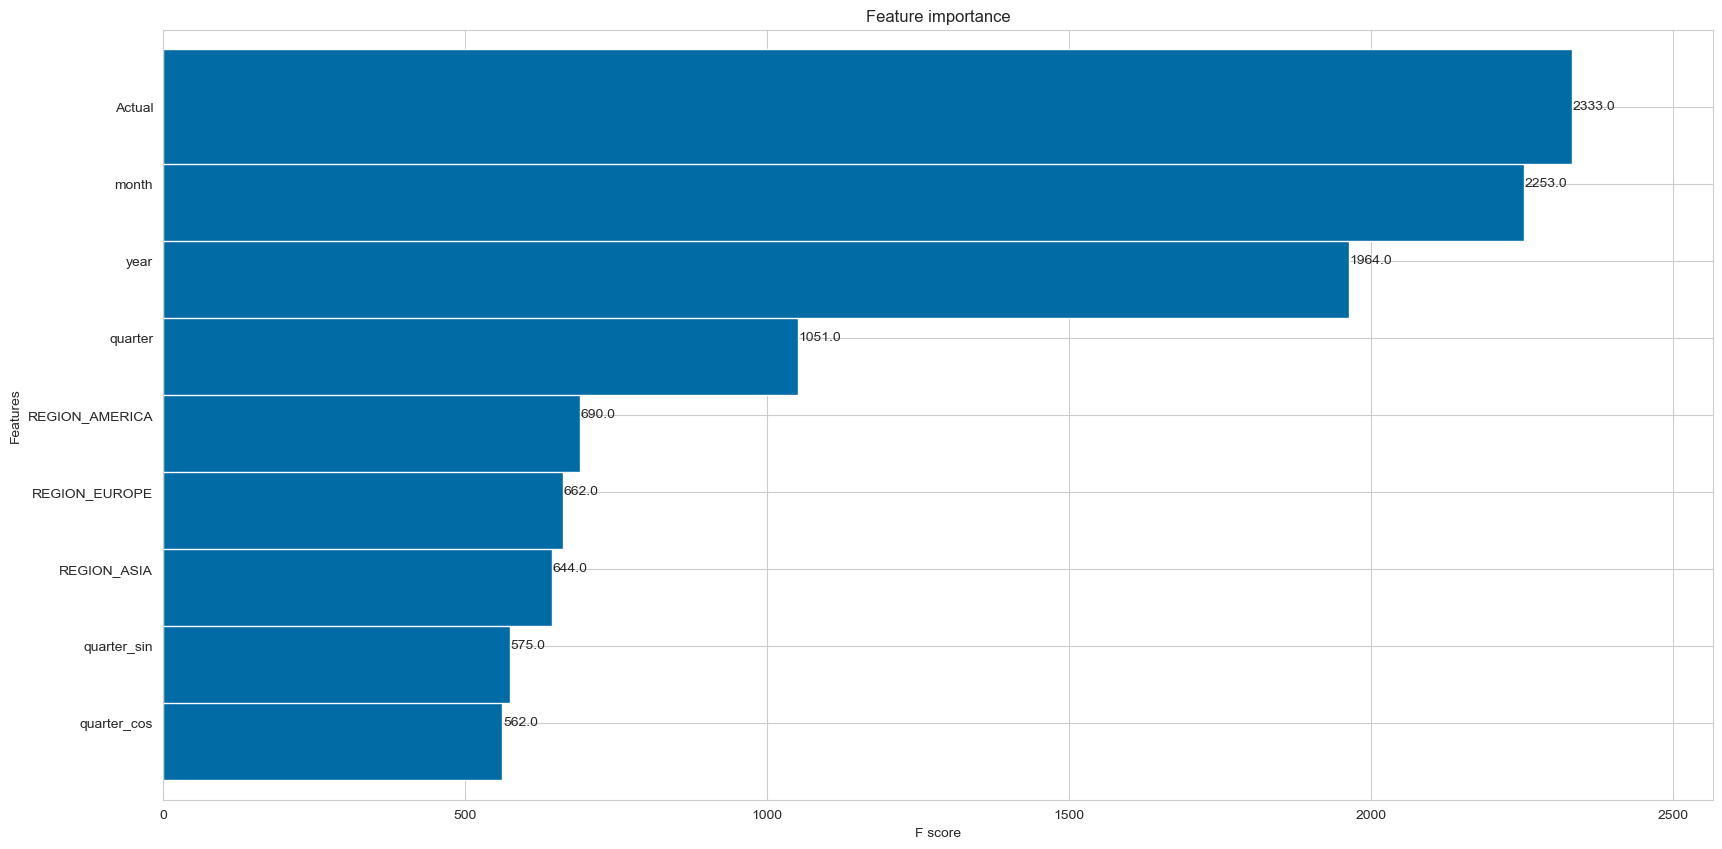

In [2929]:
_ = plot_importance(best_xgb, height=1.5)

In [2930]:
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [2931]:
yhat = random_search.predict(X_test)
rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  704899.693988
MAE :  435438.128333


In [2932]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 11.27%


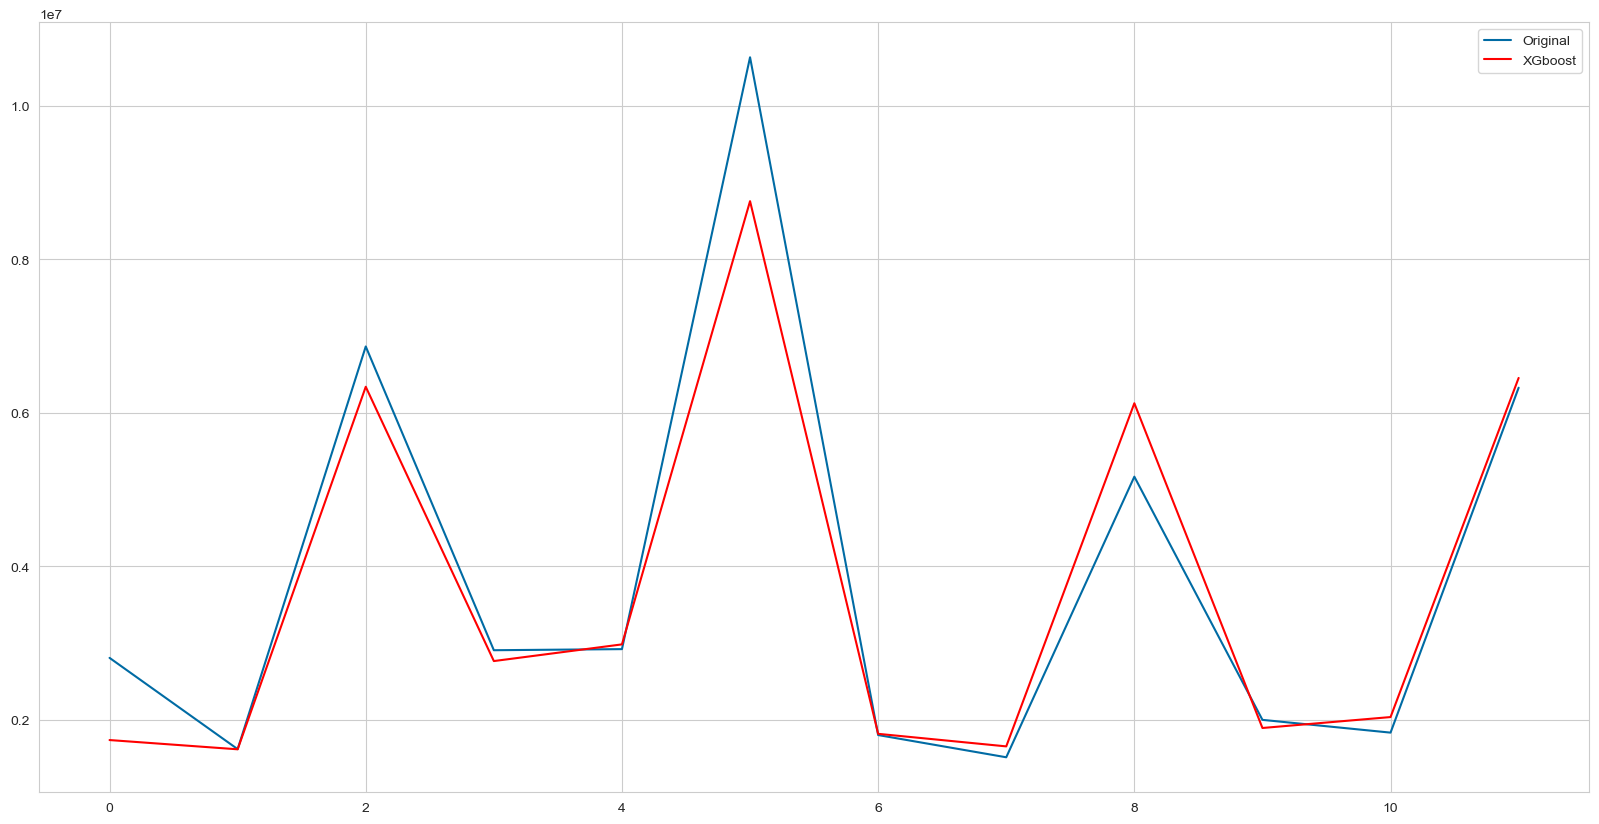

In [2933]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

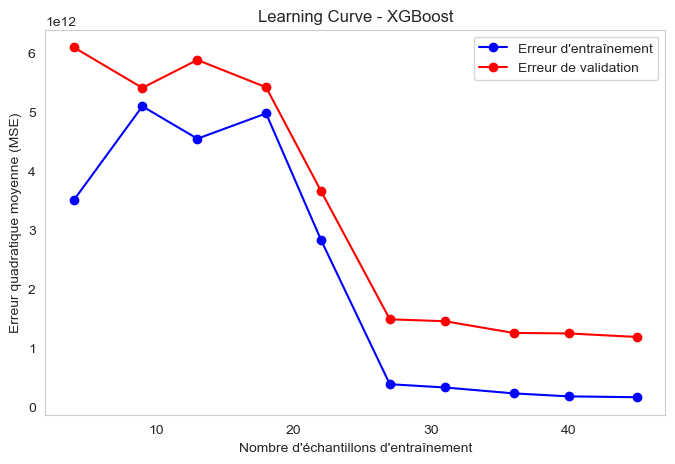

In [2934]:
# Définition des splits temporels
tscv = TimeSeriesSplit(n_splits=5)

# Calcul de la learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Conversion en erreurs positives (MSE)
train_errors = -train_scores.mean(axis=1)
val_errors = -val_scores.mean(axis=1)

# Affichage des courbes
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors, "o-", label="Erreur d'entraînement", color="blue")
plt.plot(train_sizes, val_errors, "o-", label="Erreur de validation", color="red")

plt.xlabel("Nombre d'échantillons d'entraînement")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("Learning Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()

In [2935]:
# Fonction d'optimisation avec Optuna
def objective(trial):
    # Espace de recherche des hyperparamètres
    params = {
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.7, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 500, 1000, 2000]),
        'n_jobs': -1,
        'objective': 'reg:squarederror'
    }

    # Initialisation du modèle
    xgb_reg = xgb.XGBRegressor(**params)

    # Entraînement du modèle
    xgb_reg.fit(X_train, y_train)

    # Prédictions sur le test set
    y_pred = xgb_reg.predict(X_test)

    # Calcul du RMSE
    rmse = np.sqrt(MSE(y_test, y_pred))

    return rmse  # On minimise le RMSE

# Lancement de l'optimisation avec Optuna
study = optuna.create_study(direction="minimize")  # Minimiser le RMSE
study.optimize(objective, n_trials=30)

# Meilleurs hyperparamètres trouvés
best_params = study.best_params
print("Meilleurs hyperparamètres :", best_params)

# Reconstruction du meilleur modèle avec les hyperparamètres optimaux
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)

# Prédictions finales
yhat = best_xgb.predict(X_test)

[I 2025-06-06 14:34:06,079] A new study created in memory with name: no-name-5195fa38-e13d-4d75-bb19-44940945f099
C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\808818040.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
[I 2025-06-06 14:34:07,820] Trial 0 finished with value: 695571.22967083 and parameters: {'min_child_weight': 7, 'gamma': 0.6000000000000001, 'subsample': 1.0, 'colsample_bytree': 0.8, 'max_depth': 6, 'learning_rate': 0.09203511539882527, 'n_estimators': 1000}. Best is trial 0 with value: 695571.22967083.
C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\808818040.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

Meilleurs hyperparamètres : {'min_child_weight': 1, 'gamma': 0.6000000000000001, 'subsample': 0.6, 'colsample_bytree': 1.0, 'max_depth': 3, 'learning_rate': 0.036879741893643035, 'n_estimators': 500}


In [2936]:
# Évaluation du modèle optimisé
rmse = np.sqrt(MSE(y_test, yhat))
r2 = r2_score(y_test, yhat)

print("Meilleur score R2 :", r2)
print("RMSE : % f" % (rmse))

Meilleur score R2 : 0.9396987421656493
RMSE :  664573.963640


In [2937]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 10.93%


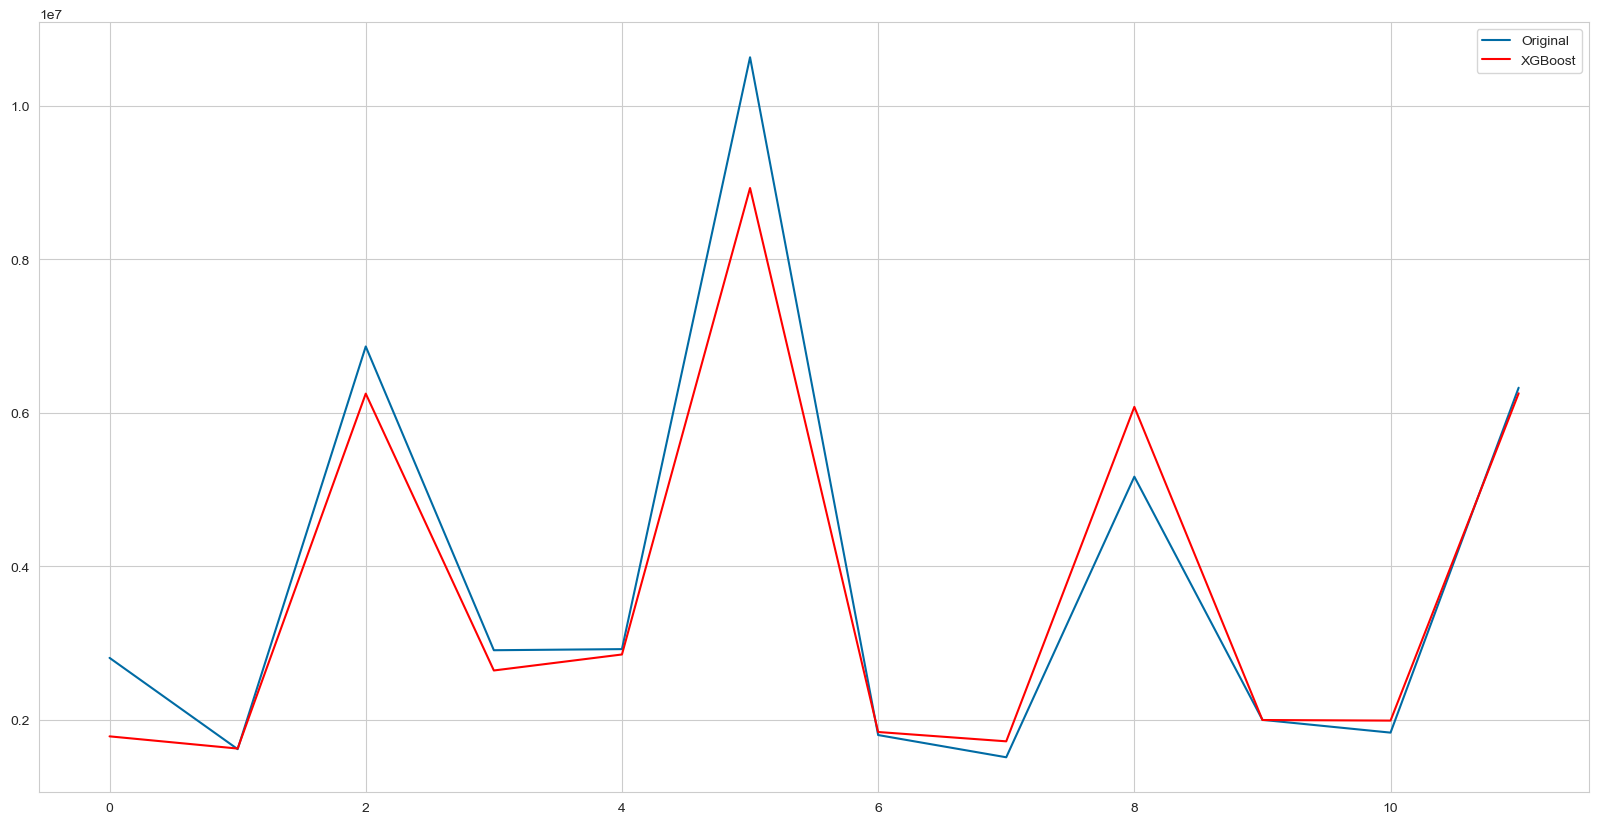

In [2938]:
# Affichage des résultats
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGBoost')
plt.legend()
plt.show()

In [2939]:
# Création du DataFrame final
df_result2 = pd.concat([
    X_test.reset_index(drop=True),
    pd.Series(y_test, name='y_test').reset_index(drop=True),
    pd.Series(yhat, name='yhat').reset_index(drop=True)
], axis=1)

In [2940]:
df_result2

Actual  quarter  month  year   quarter_sin   quarter_cos  REGION_AMERICA  \
0     20.0        1      2  2025  1.000000e+00  6.123234e-17             1.0   
1     20.0        1      2  2025  1.000000e+00  6.123234e-17             0.0   
2     20.0        1      2  2025  1.000000e+00  6.123234e-17             0.0   
3     25.0        1      3  2025  1.000000e+00  6.123234e-17             1.0   
4     25.0        1      3  2025  1.000000e+00  6.123234e-17             0.0   
5     25.0        1      3  2025  1.000000e+00  6.123234e-17             0.0   
6     19.0        2      4  2025  1.224647e-16 -1.000000e+00             1.0   
7     19.0        2      4  2025  1.224647e-16 -1.000000e+00             0.0   
8     19.0        2      4  2025  1.224647e-16 -1.000000e+00             0.0   
9     18.0        2      5  2025  1.224647e-16 -1.000000e+00             1.0   
10    18.0        2      5  2025  1.224647e-16 -1.000000e+00             0.0   
11    18.0        2      5  2025  1.224647e-16 -1.000000e+00             0.0   

    REGION_ASIA  REGION_EUROPE       y_test         yhat  
0           0.0            0.0   2805945.81  1783597.250  
1           1.0            0.0   1617150.54  1624728.125  
2           0.0            1.0   6862262.22  6247929.500  
3           0.0            0.0   2905514.25  2641687.750  
4           1.0            0.0   2919785.53  2850107.250  
5           0.0            1.0  10629234.32  8925814.000  
6           0.0            0.0   1800583.23  1840278.250  
7           1.0            0.0   1511025.01  1718742.500  
8           0.0            1.0   5166137.92  6075281.000  
9           0.0            0.0   1998380.80  1996340.625  
10          1.0            0.0   1832104.50  1988813.500  
11          0.0            1.0   6324796.96  6251869.500

#### To change

In [2943]:
#df_test=df[df['year']>=2024]
df_test = df[(df['year'] == year) & (df['month'].between(debut_predict, fin_predict))]


X_test=df_test.drop(['Billings EURO'],axis=1)
y_test=df_test['Billings EURO']

In [2944]:
# Prédictions finales
yhat = best_xgb.predict(X_test)

In [2945]:
# Évaluation du modèle optimisé
rmse = np.sqrt(MSE(y_test, yhat))
r2 = r2_score(y_test, yhat)

print("Meilleur score R2 :", r2)
print("RMSE : % f" % (rmse))

Meilleur score R2 : 0.0
RMSE :  4574198.183166


In [2946]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : inf%


C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\2921755809.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  mae_percentage = (mae / np.mean(y_test)) * 100


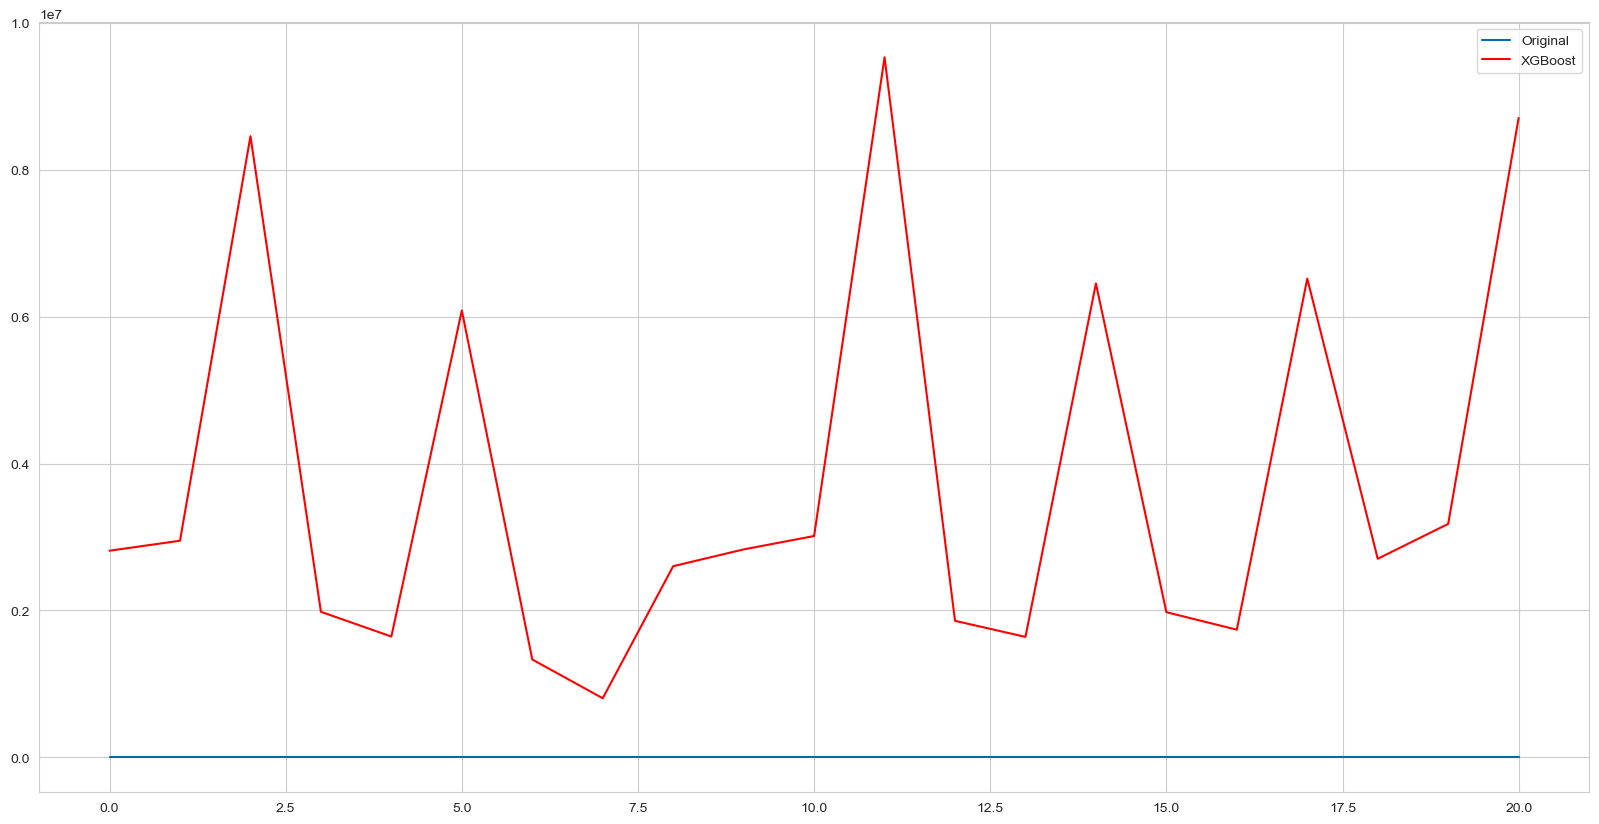

In [2947]:
# Affichage des résultats
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGBoost')
plt.legend()
plt.show()

In [2948]:
# Création du DataFrame final
df_result3 = pd.concat([
    X_test.reset_index(drop=True),
    pd.Series(y_test, name='y_test').reset_index(drop=True),
    pd.Series(yhat, name='yhat').reset_index(drop=True)
], axis=1)

In [2949]:
df_result3

Actual  quarter  month  year   quarter_sin   quarter_cos  REGION_AMERICA  \
0     23.0        2      6  2025  1.224647e-16 -1.000000e+00             1.0   
1     23.0        2      6  2025  1.224647e-16 -1.000000e+00             0.0   
2     23.0        2      6  2025  1.224647e-16 -1.000000e+00             0.0   
3     19.0        3      7  2025 -1.000000e+00 -1.836970e-16             1.0   
4     19.0        3      7  2025 -1.000000e+00 -1.836970e-16             0.0   
5     19.0        3      7  2025 -1.000000e+00 -1.836970e-16             0.0   
6      5.0        3      8  2025 -1.000000e+00 -1.836970e-16             1.0   
7      5.0        3      8  2025 -1.000000e+00 -1.836970e-16             0.0   
8      5.0        3      8  2025 -1.000000e+00 -1.836970e-16             0.0   
9     25.0        3      9  2025 -1.000000e+00 -1.836970e-16             1.0   
10    25.0        3      9  2025 -1.000000e+00 -1.836970e-16             0.0   
11    25.0        3      9  2025 -1.000000e+00 -1.836970e-16             0.0   
12    20.0        4     10  2025 -2.449294e-16  1.000000e+00             1.0   
13    20.0        4     10  2025 -2.449294e-16  1.000000e+00             0.0   
14    20.0        4     10  2025 -2.449294e-16  1.000000e+00             0.0   
15    19.0        4     11  2025 -2.449294e-16  1.000000e+00             1.0   
16    19.0        4     11  2025 -2.449294e-16  1.000000e+00             0.0   
17    19.0        4     11  2025 -2.449294e-16  1.000000e+00             0.0   
18    26.0        4     12  2025 -2.449294e-16  1.000000e+00             1.0   
19    26.0        4     12  2025 -2.449294e-16  1.000000e+00             0.0   
20    26.0        4     12  2025 -2.449294e-16  1.000000e+00             0.0   

    REGION_ASIA  REGION_EUROPE  y_test          yhat  
0           0.0            0.0     0.0  2.812992e+06  
1           1.0            0.0     0.0  2.949120e+06  
2           0.0            1.0     0.0  8.458099e+06  
3           0.0            0.0     0.0  1.981336e+06  
4           1.0            0.0     0.0  1.644325e+06  
5           0.0            1.0     0.0  6.085062e+06  
6           0.0            0.0     0.0  1.331752e+06  
7           1.0            0.0     0.0  8.039554e+05  
8           0.0            1.0     0.0  2.602472e+06  
9           0.0            0.0     0.0  2.830848e+06  
10          1.0            0.0     0.0  3.013351e+06  
11          0.0            1.0     0.0  9.533029e+06  
12          0.0            0.0     0.0  1.858408e+06  
13          1.0            0.0     0.0  1.639567e+06  
14          0.0            1.0     0.0  6.452933e+06  
15          0.0            0.0     0.0  1.976062e+06  
16          1.0            0.0     0.0  1.737774e+06  
17          0.0            1.0     0.0  6.519008e+06  
18          0.0            0.0     0.0  2.703294e+06  
19          1.0            0.0     0.0  3.178267e+06  
20          0.0            1.0     0.0  8.706492e+06

In [2950]:
#  concaténer df_result1, df_result2 et df_result3 

df_final = pd.concat([df_result1, df_result2, df_result3], ignore_index=True)


In [2951]:
df_final.head(50)

Actual  quarter  month  year   quarter_sin   quarter_cos  REGION_AMERICA  \
0     16.0        1      1  2024  1.000000e+00  6.123234e-17             1.0   
1     16.0        1      1  2024  1.000000e+00  6.123234e-17             0.0   
2     16.0        1      1  2024  1.000000e+00  6.123234e-17             0.0   
3     20.0        1      2  2024  1.000000e+00  6.123234e-17             1.0   
4     20.0        1      2  2024  1.000000e+00  6.123234e-17             0.0   
5     20.0        1      2  2024  1.000000e+00  6.123234e-17             0.0   
6     25.0        1      3  2024  1.000000e+00  6.123234e-17             1.0   
7     25.0        1      3  2024  1.000000e+00  6.123234e-17             0.0   
8     25.0        1      3  2024  1.000000e+00  6.123234e-17             0.0   
9     19.0        2      4  2024  1.224647e-16 -1.000000e+00             1.0   
10    19.0        2      4  2024  1.224647e-16 -1.000000e+00             0.0   
11    19.0        2      4  2024  1.224647e-16 -1.000000e+00             0.0   
12    15.0        2      5  2024  1.224647e-16 -1.000000e+00             1.0   
13    15.0        2      5  2024  1.224647e-16 -1.000000e+00             0.0   
14    15.0        2      5  2024  1.224647e-16 -1.000000e+00             0.0   
15    25.0        2      6  2024  1.224647e-16 -1.000000e+00             1.0   
16    25.0        2      6  2024  1.224647e-16 -1.000000e+00             0.0   
17    25.0        2      6  2024  1.224647e-16 -1.000000e+00             0.0   
18    20.0        3      7  2024 -1.000000e+00 -1.836970e-16             1.0   
19    20.0        3      7  2024 -1.000000e+00 -1.836970e-16             0.0   
20    20.0        3      7  2024 -1.000000e+00 -1.836970e-16             0.0   
21     5.0        3      8  2024 -1.000000e+00 -1.836970e-16             1.0   
22     5.0        3      8  2024 -1.000000e+00 -1.836970e-16             0.0   
23     5.0        3      8  2024 -1.000000e+00 -1.836970e-16             0.0   
24    25.0        3      9  2024 -1.000000e+00 -1.836970e-16             1.0   
25    25.0        3      9  2024 -1.000000e+00 -1.836970e-16             0.0   
26    25.0        3      9  2024 -1.000000e+00 -1.836970e-16             0.0   
27    20.0        4     10  2024 -2.449294e-16  1.000000e+00             1.0   
28    20.0        4     10  2024 -2.449294e-16  1.000000e+00             0.0   
29    20.0        4     10  2024 -2.449294e-16  1.000000e+00             0.0   
30    18.0        4     11  2024 -2.449294e-16  1.000000e+00             1.0   
31    18.0        4     11  2024 -2.449294e-16  1.000000e+00             0.0   
32    18.0        4     11  2024 -2.449294e-16  1.000000e+00             0.0   
33    23.0        4     12  2024 -2.449294e-16  1.000000e+00             1.0   
34    23.0        4     12  2024 -2.449294e-16  1.000000e+00             0.0   
35    23.0        4     12  2024 -2.449294e-16  1.000000e+00             0.0   
36    20.0        1      2  2025  1.000000e+00  6.123234e-17             1.0   
37    20.0        1      2  2025  1.000000e+00  6.123234e-17             0.0   
38    20.0        1      2  2025  1.000000e+00  6.123234e-17             0.0   
39    25.0        1      3  2025  1.000000e+00  6.123234e-17             1.0   
40    25.0        1      3  2025  1.000000e+00  6.123234e-17             0.0   
41    25.0        1      3  2025  1.000000e+00  6.123234e-17             0.0   
42    19.0        2      4  2025  1.224647e-16 -1.000000e+00             1.0   
43    19.0        2      4  2025  1.224647e-16 -1.000000e+00             0.0   
44    19.0        2      4  2025  1.224647e-16 -1.000000e+00             0.0   
45    18.0        2      5  2025  1.224647e-16 -1.000000e+00             1.0   
46    18.0        2      5  2025  1.224647e-16 -1.000000e+00             0.0   
47    18.0        2      5  2025  1.224647e-16 -1.000000e+00             0.0   
48    23.0        2      6  2025  1.224647e-16 -1.000000e+00             1.0   
49  

In [2952]:
df_encoded_1 = df_final[['REGION_AMERICA','REGION_ASIA','REGION_EUROPE']]

In [2953]:
# Reconstruction de la colonne REGION

df_encoded_1['REGION'] = encoder.inverse_transform(df_encoded_1).squeeze()

C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\1352410664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_1['REGION'] = encoder.inverse_transform(df_encoded_1).squeeze()


In [2954]:
df_encoded_1 = df_encoded_1.drop(columns=['REGION_AMERICA','REGION_ASIA','REGION_EUROPE'])

In [2955]:
# ✅ Fusion avec df sans REGION
df_final = df_final.join(df_encoded_1)

In [2956]:
df_final.head()

Actual  quarter  month  year  quarter_sin   quarter_cos  REGION_AMERICA  \
0    16.0        1      1  2024          1.0  6.123234e-17             1.0   
1    16.0        1      1  2024          1.0  6.123234e-17             0.0   
2    16.0        1      1  2024          1.0  6.123234e-17             0.0   
3    20.0        1      2  2024          1.0  6.123234e-17             1.0   
4    20.0        1      2  2024          1.0  6.123234e-17             0.0   

   REGION_ASIA  REGION_EUROPE      y_test        yhat   REGION  
0          0.0            0.0  1360570.66  1598965.50  AMERICA  
1          1.0            0.0  1459936.67  1967523.50     ASIA  
2          0.0            1.0  6548783.75  5239014.00   EUROPE  
3          0.0            0.0  1735804.69  1906643.00  AMERICA  
4          1.0            0.0  1517802.60  2481773.75     ASIA

In [2957]:
df_final  = df_final.drop(columns=['REGION_AMERICA','REGION_ASIA','REGION_EUROPE'])

In [2958]:
df_final.head()

Actual  quarter  month  year  quarter_sin   quarter_cos      y_test  \
0    16.0        1      1  2024          1.0  6.123234e-17  1360570.66   
1    16.0        1      1  2024          1.0  6.123234e-17  1459936.67   
2    16.0        1      1  2024          1.0  6.123234e-17  6548783.75   
3    20.0        1      2  2024          1.0  6.123234e-17  1735804.69   
4    20.0        1      2  2024          1.0  6.123234e-17  1517802.60   

         yhat   REGION  
0  1598965.50  AMERICA  
1  1967523.50     ASIA  
2  5239014.00   EUROPE  
3  1906643.00  AMERICA  
4  2481773.75     ASIA

In [2959]:
# Condition sur la colonne REGION
df_final['Material Grp 3'] = df_final['REGION'].apply(lambda x: 'VISHAY SA' if x == 'CN' else 'VISHAY SA')

df_final = df_final.rename(columns={
    'y_test': 'Valeur Réelle',
    'yhat': 'Prédiction'
})


In [2960]:
# Affichage des résultats
tekem = df_final[['month','Valeur Réelle','Prédiction']]

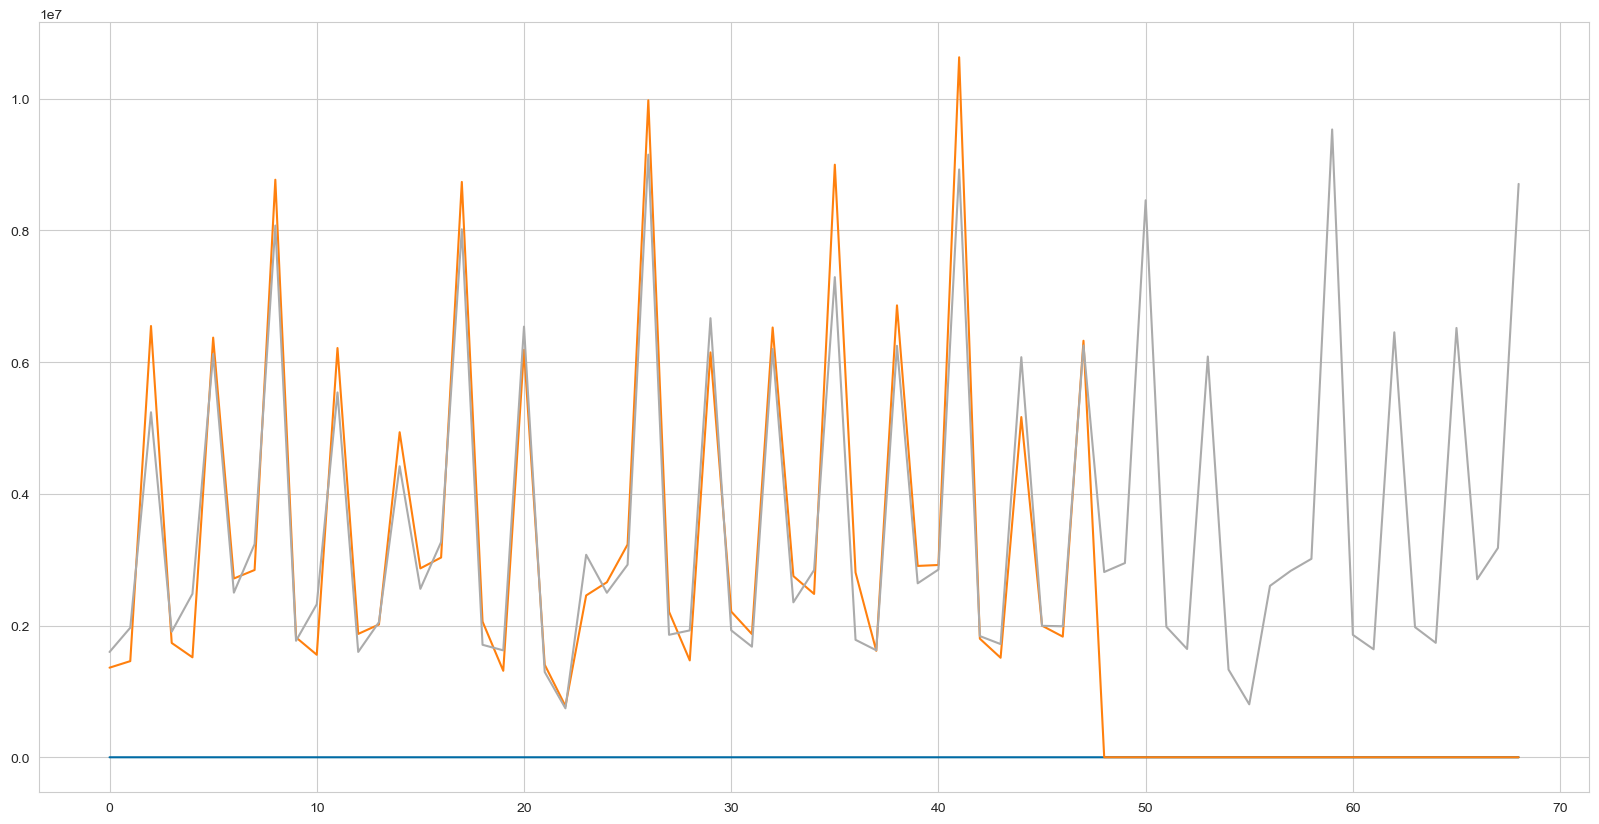

In [2961]:
plt.plot(tekem)

In [2962]:
df_vishay=df_final.copy()

In [2963]:
df_vishay['periode'] = df_vishay['year'].astype(str) + "-" + df_vishay['month'].astype(str).str.zfill(2)

df_vishay.head()

Actual  quarter  month  year  quarter_sin   quarter_cos  Valeur Réelle  \
0    16.0        1      1  2024          1.0  6.123234e-17     1360570.66   
1    16.0        1      1  2024          1.0  6.123234e-17     1459936.67   
2    16.0        1      1  2024          1.0  6.123234e-17     6548783.75   
3    20.0        1      2  2024          1.0  6.123234e-17     1735804.69   
4    20.0        1      2  2024          1.0  6.123234e-17     1517802.60   

   Prédiction   REGION Material Grp 3  periode  
0  1598965.50  AMERICA      VISHAY SA  2024-01  
1  1967523.50     ASIA      VISHAY SA  2024-01  
2  5239014.00   EUROPE      VISHAY SA  2024-01  
3  1906643.00  AMERICA      VISHAY SA  2024-02  
4  2481773.75     ASIA      VISHAY SA  2024-02

In [2964]:
# Conversion de la colonne "periode" en type datetime
df_vishay['periode'] = pd.to_datetime(df_vishay['periode'], format='%Y-%m')

df_vishay.head()

Actual  quarter  month  year  quarter_sin   quarter_cos  Valeur Réelle  \
0    16.0        1      1  2024          1.0  6.123234e-17     1360570.66   
1    16.0        1      1  2024          1.0  6.123234e-17     1459936.67   
2    16.0        1      1  2024          1.0  6.123234e-17     6548783.75   
3    20.0        1      2  2024          1.0  6.123234e-17     1735804.69   
4    20.0        1      2  2024          1.0  6.123234e-17     1517802.60   

   Prédiction   REGION Material Grp 3    periode  
0  1598965.50  AMERICA      VISHAY SA 2024-01-01  
1  1967523.50     ASIA      VISHAY SA 2024-01-01  
2  5239014.00   EUROPE      VISHAY SA 2024-01-01  
3  1906643.00  AMERICA      VISHAY SA 2024-02-01  
4  2481773.75     ASIA      VISHAY SA 2024-02-01

In [2965]:
# Regrouper par période et sommer les valeurs
df_somme = df_vishay.groupby('periode')[['Valeur Réelle', 'Prédiction']].sum().reset_index()

# Afficher le résultat
print(df_somme)

      periode  Valeur Réelle  Prédiction
0  2024-01-01     9369291.08   8805503.0
1  2024-02-01     9626166.52  10511933.0
2  2024-03-01    14328663.20  13810578.0
3  2024-04-01     9590964.46   9632281.0
4  2024-05-01     8825252.63   8070402.0
5  2024-06-01    14638325.20  13843706.0
6  2024-07-01     9560832.54   9870949.0
7  2024-08-01     4640453.22   5113364.0
8  2024-09-01    15865585.51  14573489.0
9  2024-10-01     9828369.35  10453507.0
10 2024-11-01    10609734.92   9806934.0
11 2024-12-01    14229878.52  12486070.0
12 2025-02-01    11285358.57   9656255.0
13 2025-03-01    16454534.10  14417609.0
14 2025-04-01     8477746.16   9634302.0
15 2025-05-01    10155282.26  10237024.0
16 2025-06-01           0.00  14220212.0
17 2025-07-01           0.00   9710723.0
18 2025-08-01           0.00   4738180.5
19 2025-09-01           0.00  15377228.0
20 2025-10-01           0.00   9950908.0
21 2025-11-01           0.00  10232842.0
22 2025-12-01           0.00  14588053.0


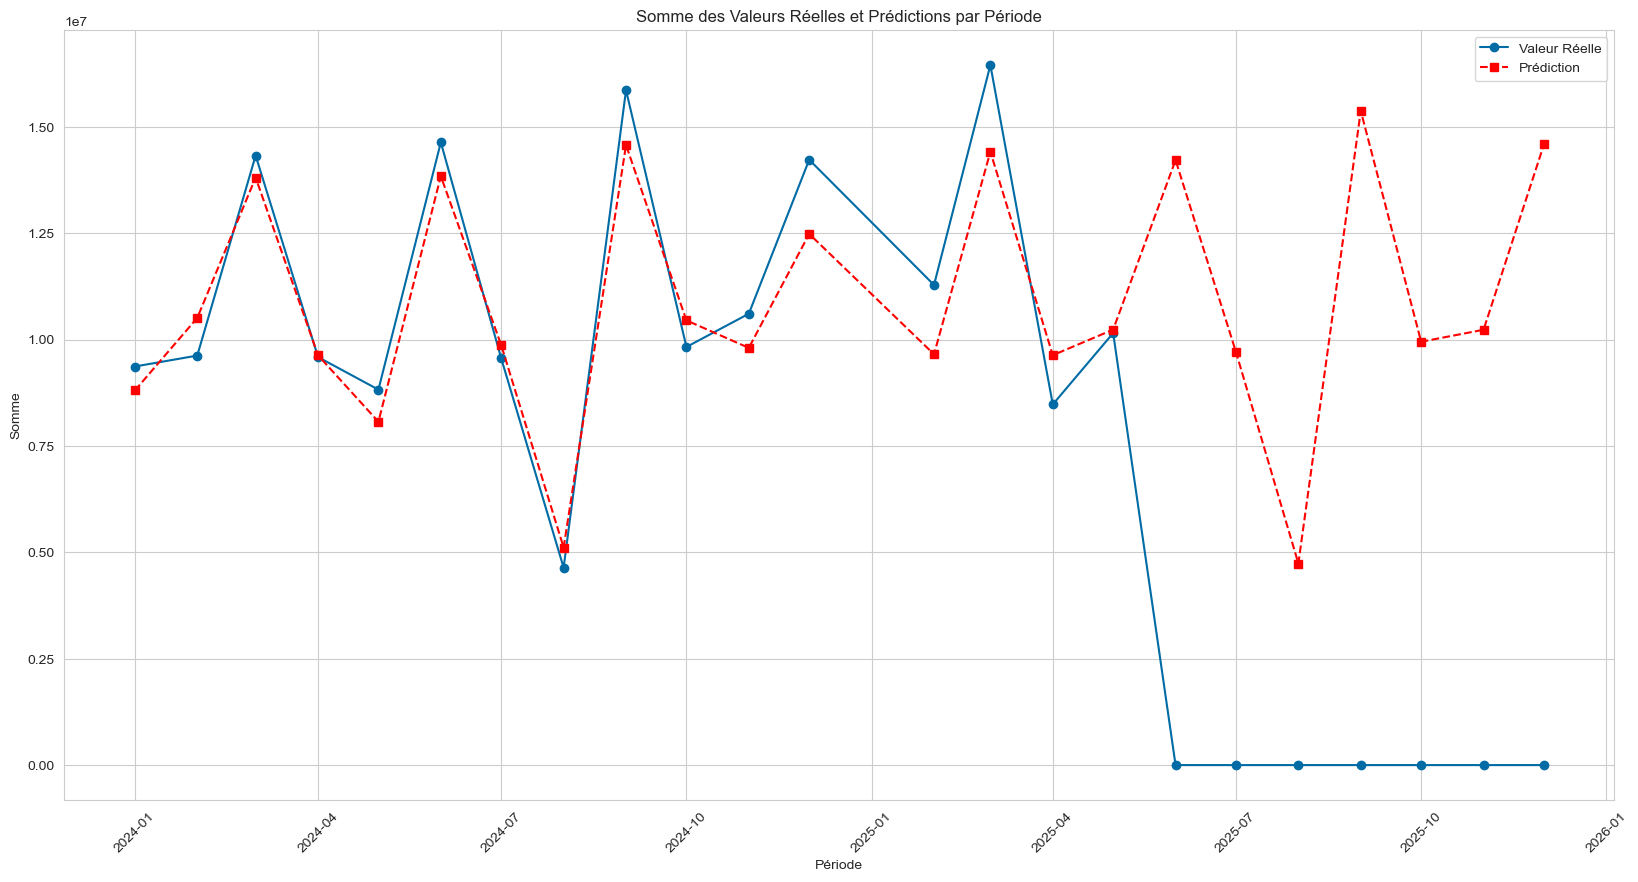

In [2966]:
plt.plot(df_somme['periode'], df_somme['Valeur Réelle'], label='Valeur Réelle', marker='o')
plt.plot(df_somme['periode'], df_somme['Prédiction'], label='Prédiction', marker='s', linestyle='dashed', color='red')

plt.xlabel('Période')
plt.ylabel('Somme')
plt.title('Somme des Valeurs Réelles et Prédictions par Période')
plt.legend()
plt.xticks(rotation=45)  # Rotation des dates pour meilleure lisibilité
plt.grid(True)
plt.show()

In [2967]:
# Remplacement des valeurs numériques par les libellés Q1, Q2, Q3, Q4
df_vishay["quarter"] = df_vishay["quarter"].replace({
    1: "Q1",
    2: "Q2",
    3: "Q3",
    4: "Q4"
})

# Création ou remplacement de la colonne avec le format YYYYMM
df_vishay["periode"] = df_vishay["periode"].dt.strftime("%Y%m")

# Liste des colonnes à supprimer
cols_to_drop = [
    "Actual", "Blg T-3", "Blg T-2", "Blg T-1", "quarter_sin","log_Backlog", "quarter_cos",
    "rolling_mean_sales_3", "sales_diff_t-1", "sales_diff_t-2", "sales_diff_t-3"
]

# Suppression des colonnes si elles existent dans le DataFrame
df_vishay = df_vishay.drop(columns=[col for col in cols_to_drop if col in df_vishay.columns])


# Sauvegarde du DataFrame dans le fichier CSV
df_vishay.to_csv(r"I:\Marketing\Stats_com\RT_REPORTING\POWER BI\datawarehouse\df_vishay_season_Sales_prediction.csv", index=False)

In [2968]:
# Affichage d’un aperçu
df_vishay.head()

quarter  month  year  Valeur Réelle  Prédiction   REGION Material Grp 3  \
0      Q1      1  2024     1360570.66  1598965.50  AMERICA      VISHAY SA   
1      Q1      1  2024     1459936.67  1967523.50     ASIA      VISHAY SA   
2      Q1      1  2024     6548783.75  5239014.00   EUROPE      VISHAY SA   
3      Q1      2  2024     1735804.69  1906643.00  AMERICA      VISHAY SA   
4      Q1      2  2024     1517802.60  2481773.75     ASIA      VISHAY SA   

  periode  
0  202401  
1  202401  
2  202401  
3  202402  
4  202402

# FP1_Without_Backlog

### EDA

In [2974]:
df = pd.read_excel(r'C:\Users\rtekem\OneDrive - Vishay Intertechnology, Inc\Desktop\Machine_Learning_project\IMPUT\Sales forecasting by product line and region\DF_FP11.xlsx')
                                                                                                    
df.head()

C:\Users\rtekem\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Period Mat/Group   REGION  Actual  Blg T-3  Blg T-2        Blg T-1  \
0  201801       FP1  AMERICA    16.5      0.0      0.0       0.000000   
1  201801       FP1     ASIA    16.5      0.0      0.0       0.000000   
2  201801       FP1   EUROPE    16.5      0.0      0.0       0.000000   
3  201802       FP1  AMERICA    20.0      0.0      0.0  356392.420397   
4  201802       FP1     ASIA    20.0      0.0      0.0   74422.044385   

   Blg Total Qty    BACKLOG EUR  Billings EURO  
0          74052  124972.939514      146724.09  
1          68370   58530.350150       57207.70  
2         477846  611863.104000      865229.66  
3         332114  339012.336851      163969.17  
4          57325   72929.288720       59246.39

In [2975]:
df['Period'] = pd.to_datetime(df['Period'].astype(str), format='%Y%m')

In [2976]:
df.tail(30)

Period Mat/Group   REGION  Actual        Blg T-3        Blg T-2  \
256 2025-02-01       FP1     ASIA    20.0    6143.319650   65939.044960   
257 2025-02-01       FP1   EUROPE    20.0  243079.950000  387091.610000   
258 2025-03-01       FP1  AMERICA    25.0  218382.441460  190649.079900   
259 2025-03-01       FP1     ASIA    25.0    3582.929000    1857.102000   
260 2025-03-01       FP1   EUROPE    25.0  339575.660000  509572.406000   
261 2025-04-01       FP1  AMERICA    19.0   94835.148320  165029.460990   
262 2025-04-01       FP1     ASIA    19.0    4825.393650    5163.423400   
263 2025-04-01       FP1   EUROPE    19.0  320192.140000  360350.000000   
264 2025-05-01       FP1  AMERICA    18.0  139956.876730  168000.973410   
265 2025-05-01       FP1     ASIA    18.0   23140.400600   85817.022350   
266 2025-05-01       FP1   EUROPE    18.0  178012.402500  318394.700000   
267 2025-06-01       FP1  AMERICA    23.0   60299.487100  303772.565485   
268 2025-06-01       FP1     ASIA    23.0    1684.795000    1681.870500   
269 2025-06-01       FP1   EUROPE    23.0  363973.985000  552644.115000   
270 2025-07-01       FP1  AMERICA    19.0   77584.438436  115901.508310   
271 2025-07-01       FP1     ASIA    19.0     665.595250    1517.861500   
272 2025-07-01       FP1   EUROPE    19.0  295531.380000  279354.525000   
273 2025-08-01       FP1  AMERICA     5.0   20054.924620   16966.910800   
274 2025-08-01       FP1     ASIA     5.0       0.000000       0.000000   
275 2025-08-01       FP1   EUROPE     5.0  195148.187500  206149.300000   
276 2025-09-01       FP1  AMERICA    25.0   28336.495000   28287.315000   
277 2025-09-01       FP1     ASIA    25.0       0.000000     829.889000   
278 2025-09-01       FP1   EUROPE    25.0  141503.220000  176350.160000   
279 2025-10-01       FP1  AMERICA    20.0       0.000000       0.000000   
280 2025-10-01       FP1     ASIA    20.0       0.000000     828.448500   
281 2025-10-01       FP1   EUROPE    20.0  185216.960000  191253.040000   
282 2025-11-01       FP1  AMERICA    19.0    9429.462000    9413.096000   
283 2025-11-01       FP1     ASIA    19.0       0.000000       0.000000   
284 2025-11-01       FP1   EUROPE    19.0  155038.330000  152730.170000   
285 2025-12-01       FP1   EUROPE    26.0  159563.200000  180587.670000   

           Blg T-1  Blg Total Qty    BACKLOG EUR  Billings EURO  
256   49643.983115          33825   47949.732850       26706.16  
257  646414.772005         268969  687835.472220      614076.05  
258  218092.784890          75175  313586.910510      344675.78  
259   19859.053700           8790   24530.320580      101399.51  
260  653095.854400         286746  889516.924980     1047674.28  
261  216008.464722          60985  289221.899230      274368.06  
262   45530.256000          44360   70540.561870       54901.18  
263  614024.607500         335313  852937.224000      809530.31  
264  290053.398635          53400  257823.309372      301749.17  
265   92156.383600          36520   47211.942990       32740.79  
266  552770.988000         193262  518222.310000      614186.34  
267  439867.340345          89884  432800.072882           0.00  
268   18367.364460          29320   31538.550680           0.00  
269  898596.708000         308701  943359.402580           0.00  
270  169840.069183          21922  223994.680099           0.00  
271   12679.612500          20990   21684.338930           0.00  
272  649709.555000         279801  825154.425000           0.00  
273   93122.539895           9245   94842.048440           0.00  
274    7118.333980           1190   11564.039240           0.00  
275  255011.281950          90642  327417.060100           0.00  
276  105340.724000           5665  106220.389095           0.00  
277     306.937000            750    1099.136750           0.00  
278  154590.350000          44326  186607.695000           0.00  
279     155.191620            270    9538.116930           0.00  
280     306.937000            25

In [2977]:
df.shape

(286, 10)

In [2978]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Period         286 non-null    datetime64[ns]
 1   Mat/Group      286 non-null    object        
 2   REGION         286 non-null    object        
 3   Actual         286 non-null    float64       
 4   Blg T-3        286 non-null    float64       
 5   Blg T-2        286 non-null    float64       
 6   Blg T-1        286 non-null    float64       
 7   Blg Total Qty  286 non-null    int64         
 8   BACKLOG EUR    286 non-null    float64       
 9   Billings EURO  286 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 22.5+ KB


In [2979]:
df.columns.values

array(['Period', 'Mat/Group', 'REGION', 'Actual', 'Blg T-3', 'Blg T-2',
       'Blg T-1', 'Blg Total Qty', 'BACKLOG EUR', 'Billings EURO'],
      dtype=object)

In [2980]:
df.dtypes

Period           datetime64[ns]
Mat/Group                object
REGION                   object
Actual                  float64
Blg T-3                 float64
Blg T-2                 float64
Blg T-1                 float64
Blg Total Qty             int64
BACKLOG EUR             float64
Billings EURO           float64
dtype: object

In [2981]:
df.isnull().sum()

Period           0
Mat/Group        0
REGION           0
Actual           0
Blg T-3          0
Blg T-2          0
Blg T-1          0
Blg Total Qty    0
BACKLOG EUR      0
Billings EURO    0
dtype: int64

In [2982]:
df.dtypes.value_counts()

float64           6
object            2
datetime64[ns]    1
int64             1
Name: count, dtype: int64

<Axes: ylabel='count'>

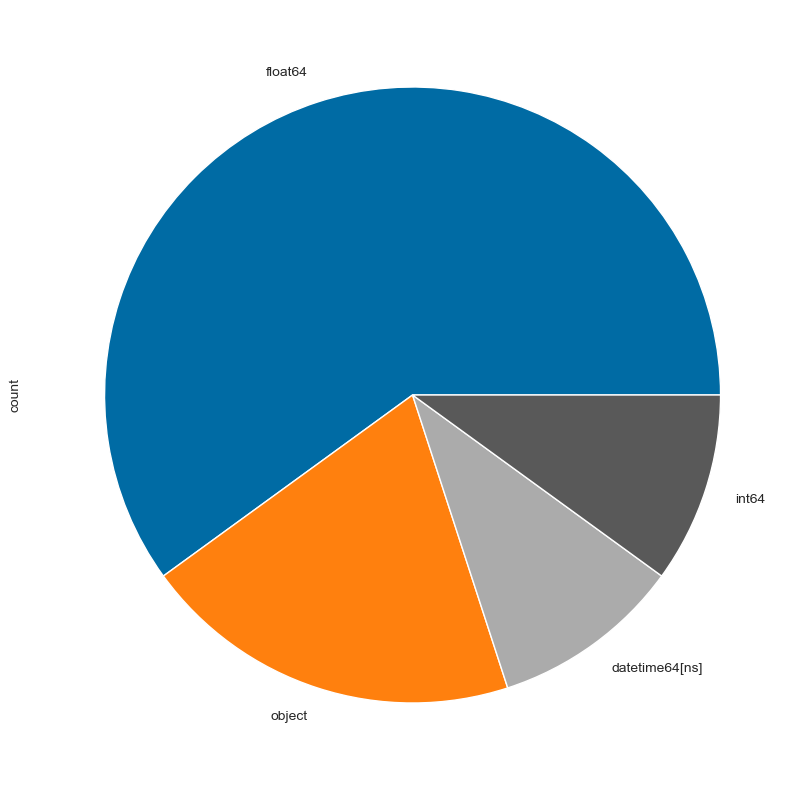

In [2983]:
df.dtypes.value_counts().plot.pie()

df.shape

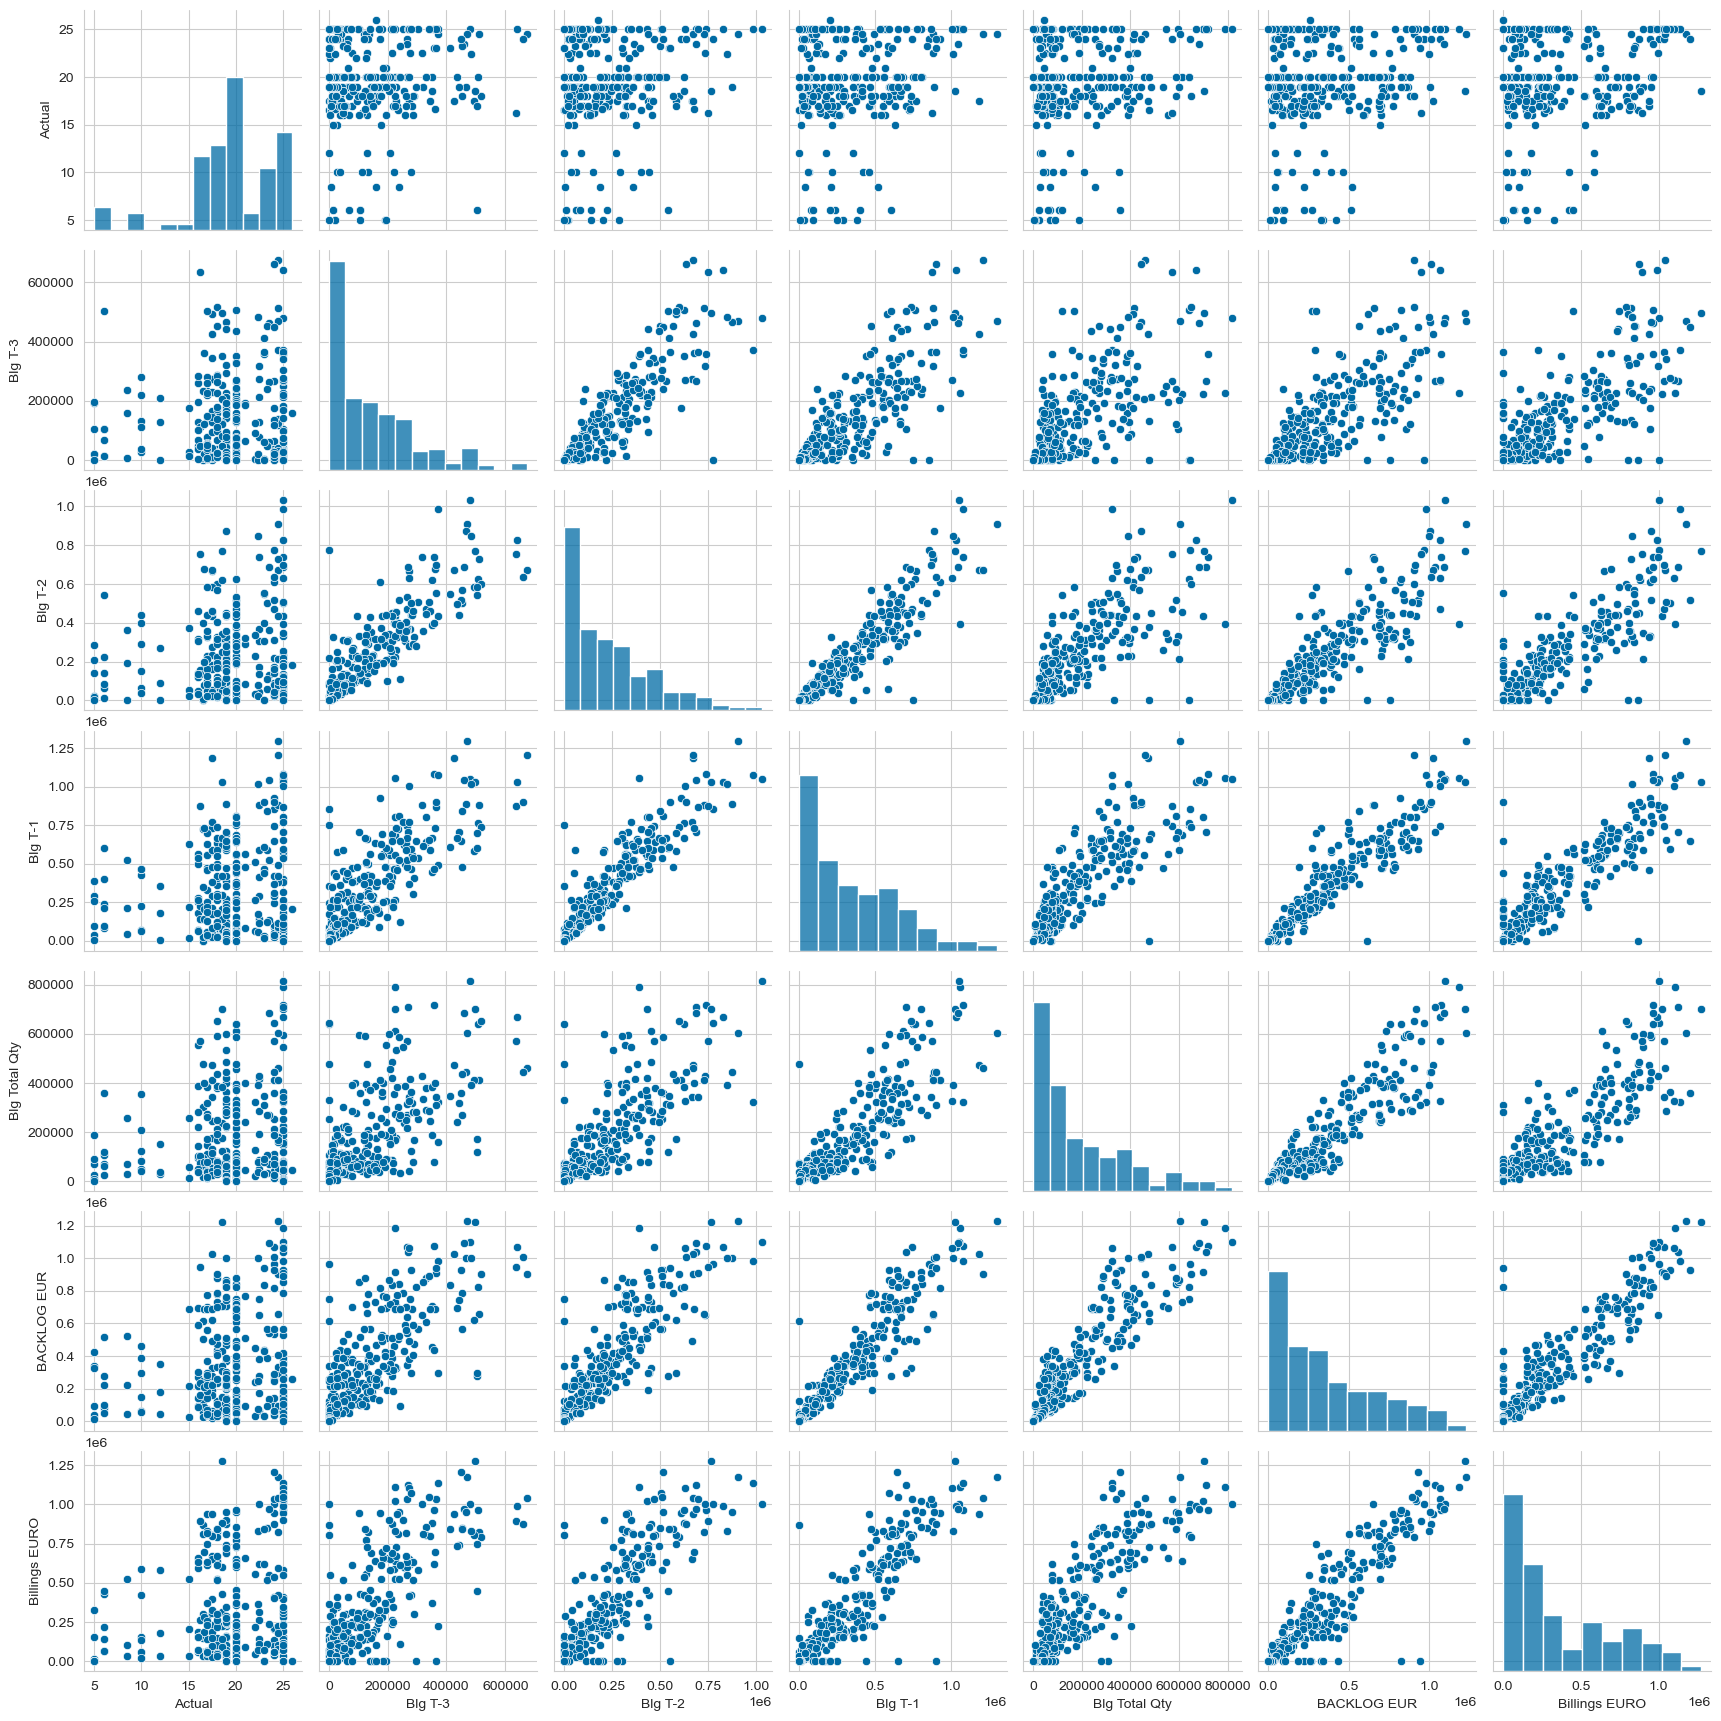

In [2985]:
sns.pairplot(df)

<Axes: xlabel='Period'>

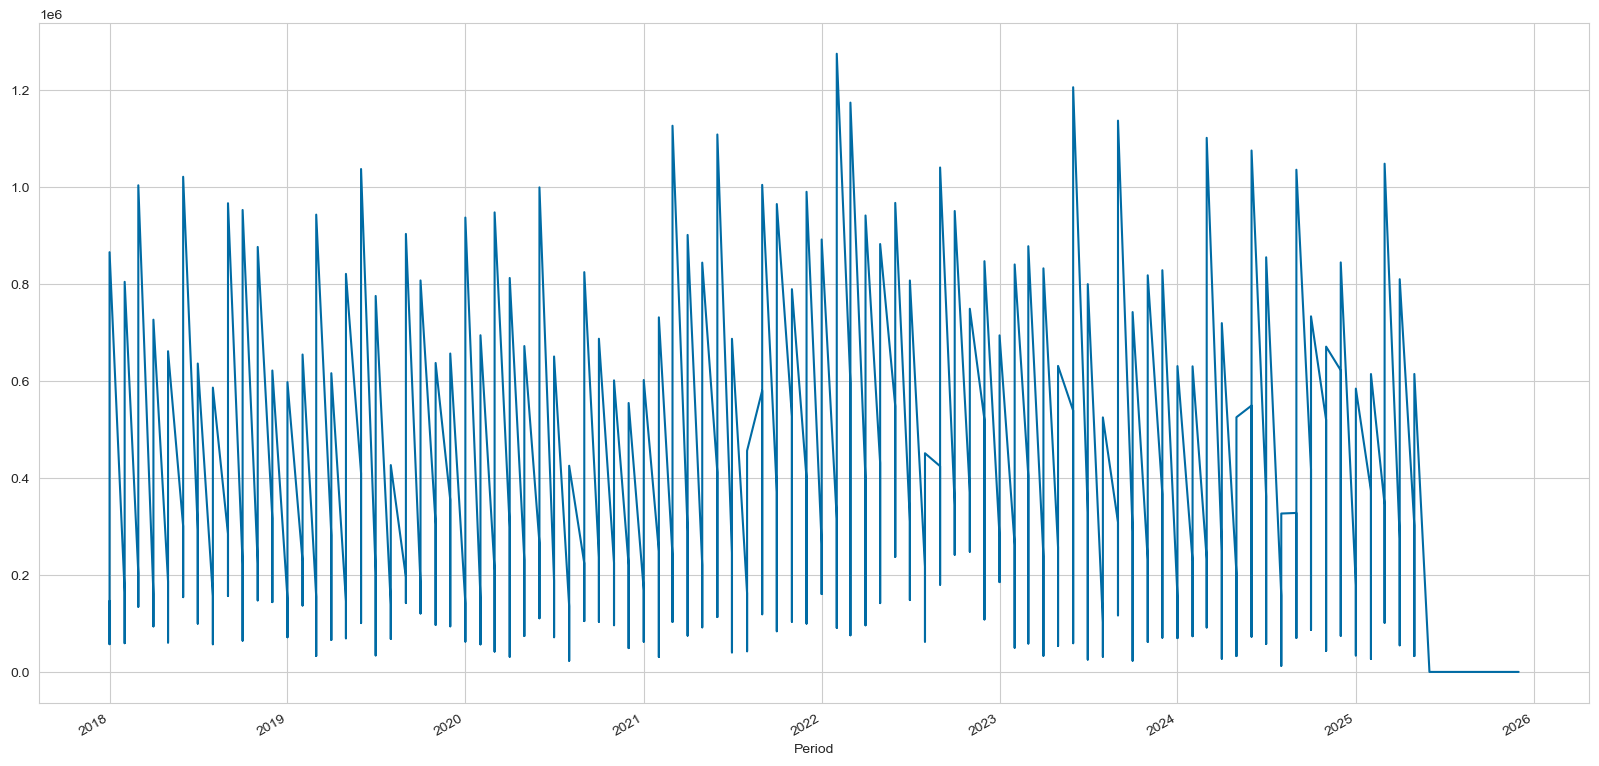

In [2986]:
df.set_index('Period')['Billings EURO'].plot()

array([<Axes: xlabel='Period'>, <Axes: xlabel='Period'>,
       <Axes: xlabel='Period'>], dtype=object)

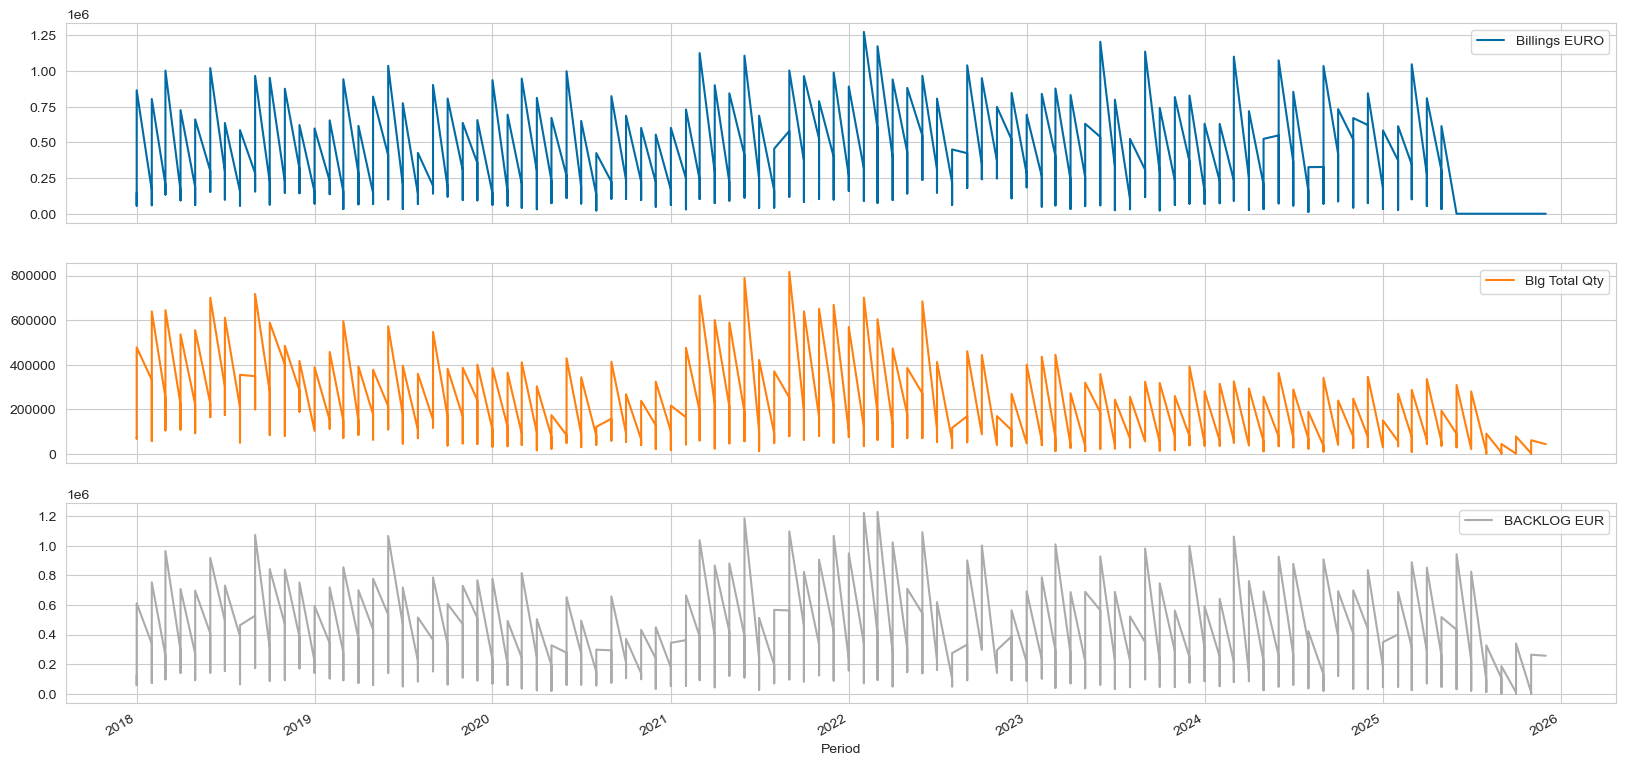

In [2987]:
df.set_index('Period')[['Billings EURO','Blg Total Qty','BACKLOG EUR']].plot(subplots=True)

### Pre-processing

In [126]:
df

Period Mat/Group   REGION  Actual     Blg T-3     Blg T-2  \
0   2018-01-01       FP1  AMERICA    16.5       0.000       0.000   
1   2018-01-01       FP1     ASIA    16.5       0.000       0.000   
2   2018-01-01       FP1   EUROPE    16.5       0.000       0.000   
3   2018-02-01       FP1  AMERICA    20.0       0.000       0.000   
4   2018-02-01       FP1     ASIA    20.0       0.000       0.000   
..         ...       ...      ...     ...         ...         ...   
281 2025-10-01       FP1   EUROPE    20.0  185216.960  191253.040   
282 2025-11-01       FP1  AMERICA    19.0    9429.462    9413.096   
283 2025-11-01       FP1     ASIA    19.0       0.000       0.000   
284 2025-11-01       FP1   EUROPE    19.0  155038.330  152730.170   
285 2025-12-01       FP1   EUROPE    26.0  159563.200  180587.670   

           Blg T-1  Blg Total Qty    BACKLOG EUR  Billings EURO  
0         0.000000          74052  124972.939514      146724.09  
1         0.000000          68370   58530.350150       57207.70  
2         0.000000         477846  611863.104000      865229.66  
3    356392.420397         332114  339012.336851      163969.17  
4     74422.044385          57325   72929.288720       59246.39  
..             ...            ...            ...            ...  
281  251553.890000          77851  339911.335000           0.00  
282    8637.426000           2020    9566.005320           0.00  
283     760.181500            500     766.529500           0.00  
284  197115.250000          60911  264289.370000           0.00  
285  203900.010000          43177  257197.935000           0.00  

[286 rows x 10 columns]

In [127]:
df['quarter'] = df['Period'].dt.quarter
df['month'] = df['Period'].dt.month
df['year'] = df['Period'].dt.year

#df['log_Backlog'] = np.log1p(df['BACKLOG EUR'])
df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

In [128]:
df

Period Mat/Group   REGION  Actual     Blg T-3     Blg T-2  \
0   2018-01-01       FP1  AMERICA    16.5       0.000       0.000   
1   2018-01-01       FP1     ASIA    16.5       0.000       0.000   
2   2018-01-01       FP1   EUROPE    16.5       0.000       0.000   
3   2018-02-01       FP1  AMERICA    20.0       0.000       0.000   
4   2018-02-01       FP1     ASIA    20.0       0.000       0.000   
..         ...       ...      ...     ...         ...         ...   
281 2025-10-01       FP1   EUROPE    20.0  185216.960  191253.040   
282 2025-11-01       FP1  AMERICA    19.0    9429.462    9413.096   
283 2025-11-01       FP1     ASIA    19.0       0.000       0.000   
284 2025-11-01       FP1   EUROPE    19.0  155038.330  152730.170   
285 2025-12-01       FP1   EUROPE    26.0  159563.200  180587.670   

           Blg T-1  Blg Total Qty    BACKLOG EUR  Billings EURO  quarter  \
0         0.000000          74052  124972.939514      146724.09        1   
1         0.000000          68370   58530.350150       57207.70        1   
2         0.000000         477846  611863.104000      865229.66        1   
3    356392.420397         332114  339012.336851      163969.17        1   
4     74422.044385          57325   72929.288720       59246.39        1   
..             ...            ...            ...            ...      ...   
281  251553.890000          77851  339911.335000           0.00        4   
282    8637.426000           2020    9566.005320           0.00        4   
283     760.181500            500     766.529500           0.00        4   
284  197115.250000          60911  264289.370000           0.00        4   
285  203900.010000          43177  257197.935000           0.00        4   

     month  year   quarter_sin   quarter_cos  
0        1  2018  1.000000e+00  6.123234e-17  
1        1  2018  1.000000e+00  6.123234e-17  
2        1  2018  1.000000e+00  6.123234e-17  
3        2  2018  1.000000e+00  6.123234e-17  
4        2  2018  1.000000e+00  6.123234e-17  
..     ...   ...           ...           ...  
281     10  2025 -2.449294e-16  1.000000e+00  
282     11  2025 -2.449294e-16  1.000000e+00  
283     11  2025 -2.449294e-16  1.000000e+00  
284     11  2025 -2.449294e-16  1.000000e+00  
285     12  2025 -2.449294e-16  1.000000e+00  

[286 rows x 15 columns]

In [129]:
df=df.drop(['Period','Mat/Group','Blg T-3','Blg T-2','Blg T-1','Blg Total Qty','BACKLOG EUR'],axis=1)
#df=df.drop(['Period','Blg T-3','Mat/Group'],axis=1)

In [130]:
#df['REGION'] = df['REGION'].replace({'AMERICA': 'NA', 'EUROPE': 'EU', 'ASIA': 'AP'})

In [131]:
df

REGION  Actual  Billings EURO  quarter  month  year   quarter_sin  \
0    AMERICA    16.5      146724.09        1      1  2018  1.000000e+00   
1       ASIA    16.5       57207.70        1      1  2018  1.000000e+00   
2     EUROPE    16.5      865229.66        1      1  2018  1.000000e+00   
3    AMERICA    20.0      163969.17        1      2  2018  1.000000e+00   
4       ASIA    20.0       59246.39        1      2  2018  1.000000e+00   
..       ...     ...            ...      ...    ...   ...           ...   
281   EUROPE    20.0           0.00        4     10  2025 -2.449294e-16   
282  AMERICA    19.0           0.00        4     11  2025 -2.449294e-16   
283     ASIA    19.0           0.00        4     11  2025 -2.449294e-16   
284   EUROPE    19.0           0.00        4     11  2025 -2.449294e-16   
285   EUROPE    26.0           0.00        4     12  2025 -2.449294e-16   

      quarter_cos  
0    6.123234e-17  
1    6.123234e-17  
2    6.123234e-17  
3    6.123234e-17  
4    6.123234e-17  
..            ...  
281  1.000000e+00  
282  1.000000e+00  
283  1.000000e+00  
284  1.000000e+00  
285  1.000000e+00  

[286 rows x 8 columns]

In [132]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Initialisation de l'encodeur avec sparse_output=False
encoder = OneHotEncoder(sparse_output=False)

# Encodage de la colonne REGION
encoded_array = encoder.fit_transform(df[['REGION']])

# Récupération des noms de colonnes générés
column_names = encoder.get_feature_names_out(['REGION'])

# ✅ Vérification du format de sortie
print(f"Shape of encoded array: {encoded_array.shape}")  # Doit être (180, 3)
print(f"Feature names: {column_names}")  # Doit être ['REGION_AP', 'REGION_EU', 'REGION_NA']

# ✅ Convertir correctement en DataFrame
df_encoded = pd.DataFrame(encoded_array, columns=column_names, index=df.index)

# ✅ Fusion avec df sans REGION
df = df.drop(columns=['REGION']).join(df_encoded)


Shape of encoded array: (286, 3)
Feature names: ['REGION_AMERICA' 'REGION_ASIA' 'REGION_EUROPE']


In [133]:
df.head()

Actual  Billings EURO  quarter  month  year  quarter_sin   quarter_cos  \
0    16.5      146724.09        1      1  2018          1.0  6.123234e-17   
1    16.5       57207.70        1      1  2018          1.0  6.123234e-17   
2    16.5      865229.66        1      1  2018          1.0  6.123234e-17   
3    20.0      163969.17        1      2  2018          1.0  6.123234e-17   
4    20.0       59246.39        1      2  2018          1.0  6.123234e-17   

   REGION_AMERICA  REGION_ASIA  REGION_EUROPE  
0             1.0          0.0            0.0  
1             0.0          1.0            0.0  
2             0.0          0.0            1.0  
3             1.0          0.0            0.0  
4             0.0          1.0            0.0

#### To change

In [135]:
df_train=df[df['year']< previous_year]
X_train=df_train.drop(['Billings EURO'],axis=1)
y_train=df_train['Billings EURO']

In [136]:
df_test = df[((df['year'] == previous_year)) | ((df['year'] == year) & (df['month'] < 1))]

X_test=df_test.drop(['Billings EURO'],axis=1)
y_test=df_test['Billings EURO']

In [137]:
df_test.shape

(36, 10)

In [138]:
df_test.head(5)

Actual  Billings EURO  quarter  month  year  quarter_sin   quarter_cos  \
216    16.0      156307.68        1      1  2024          1.0  6.123234e-17   
217    16.0       69710.28        1      1  2024          1.0  6.123234e-17   
218    16.0      630414.15        1      1  2024          1.0  6.123234e-17   
219    20.0      228863.66        1      2  2024          1.0  6.123234e-17   
220    20.0       73633.40        1      2  2024          1.0  6.123234e-17   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  
216             1.0          0.0            0.0  
217             0.0          1.0            0.0  
218             0.0          0.0            1.0  
219             1.0          0.0            0.0  
220             0.0          1.0            0.0

In [139]:
df_test.tail(5)

Actual  Billings EURO  quarter  month  year   quarter_sin  quarter_cos  \
247    18.0       43465.13        4     11  2024 -2.449294e-16          1.0   
248    18.0      670550.72        4     11  2024 -2.449294e-16          1.0   
249    23.0      621693.24        4     12  2024 -2.449294e-16          1.0   
250    23.0       74539.73        4     12  2024 -2.449294e-16          1.0   
251    23.0      844173.45        4     12  2024 -2.449294e-16          1.0   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  
247             0.0          1.0            0.0  
248             0.0          0.0            1.0  
249             1.0          0.0            0.0  
250             0.0          1.0            0.0  
251             0.0          0.0            1.0

In [140]:
from sklearn.preprocessing import StandardScaler

# Sélection des colonnes numériques à standardiser

  # 'Billings EURO' est la cible, donc on ne la touche pas

#numeric_cols = ['Blg T-1','BACKLOG EUR', 'Blg Total Qty']
#numeric_cols = ['Blg T-2','Blg T-1','BACKLOG EUR', 'Blg Total Qty']
 #numeric_cols = ['Blg T-3','Blg T-2','Blg T-1','Blg Total Qty', 'BACKLOG EUR']
# Initialisation du scaler
 #scaler = StandardScaler()

# Standardisation des données d'entraînement et de test
 #X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
 #X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [141]:
X_train.shape,X_test.shape

((216, 9), (36, 9))

In [142]:
X_train.head(5)

Actual  quarter  month  year  quarter_sin   quarter_cos  REGION_AMERICA  \
0    16.5        1      1  2018          1.0  6.123234e-17             1.0   
1    16.5        1      1  2018          1.0  6.123234e-17             0.0   
2    16.5        1      1  2018          1.0  6.123234e-17             0.0   
3    20.0        1      2  2018          1.0  6.123234e-17             1.0   
4    20.0        1      2  2018          1.0  6.123234e-17             0.0   

   REGION_ASIA  REGION_EUROPE  
0          0.0            0.0  
1          1.0            0.0  
2          0.0            1.0  
3          0.0            0.0  
4          1.0            0.0

In [143]:
X_test.head(5)

Actual  quarter  month  year  quarter_sin   quarter_cos  REGION_AMERICA  \
216    16.0        1      1  2024          1.0  6.123234e-17             1.0   
217    16.0        1      1  2024          1.0  6.123234e-17             0.0   
218    16.0        1      1  2024          1.0  6.123234e-17             0.0   
219    20.0        1      2  2024          1.0  6.123234e-17             1.0   
220    20.0        1      2  2024          1.0  6.123234e-17             0.0   

     REGION_ASIA  REGION_EUROPE  
216          0.0            0.0  
217          1.0            0.0  
218          0.0            1.0  
219          0.0            0.0  
220          1.0            0.0

In [144]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)

In [145]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  96478.476472
MAE :  71134.292314


In [146]:
from sklearn.metrics import mean_absolute_error as MAE
import numpy as np

mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)


MAE en pourcentage : 18.45%


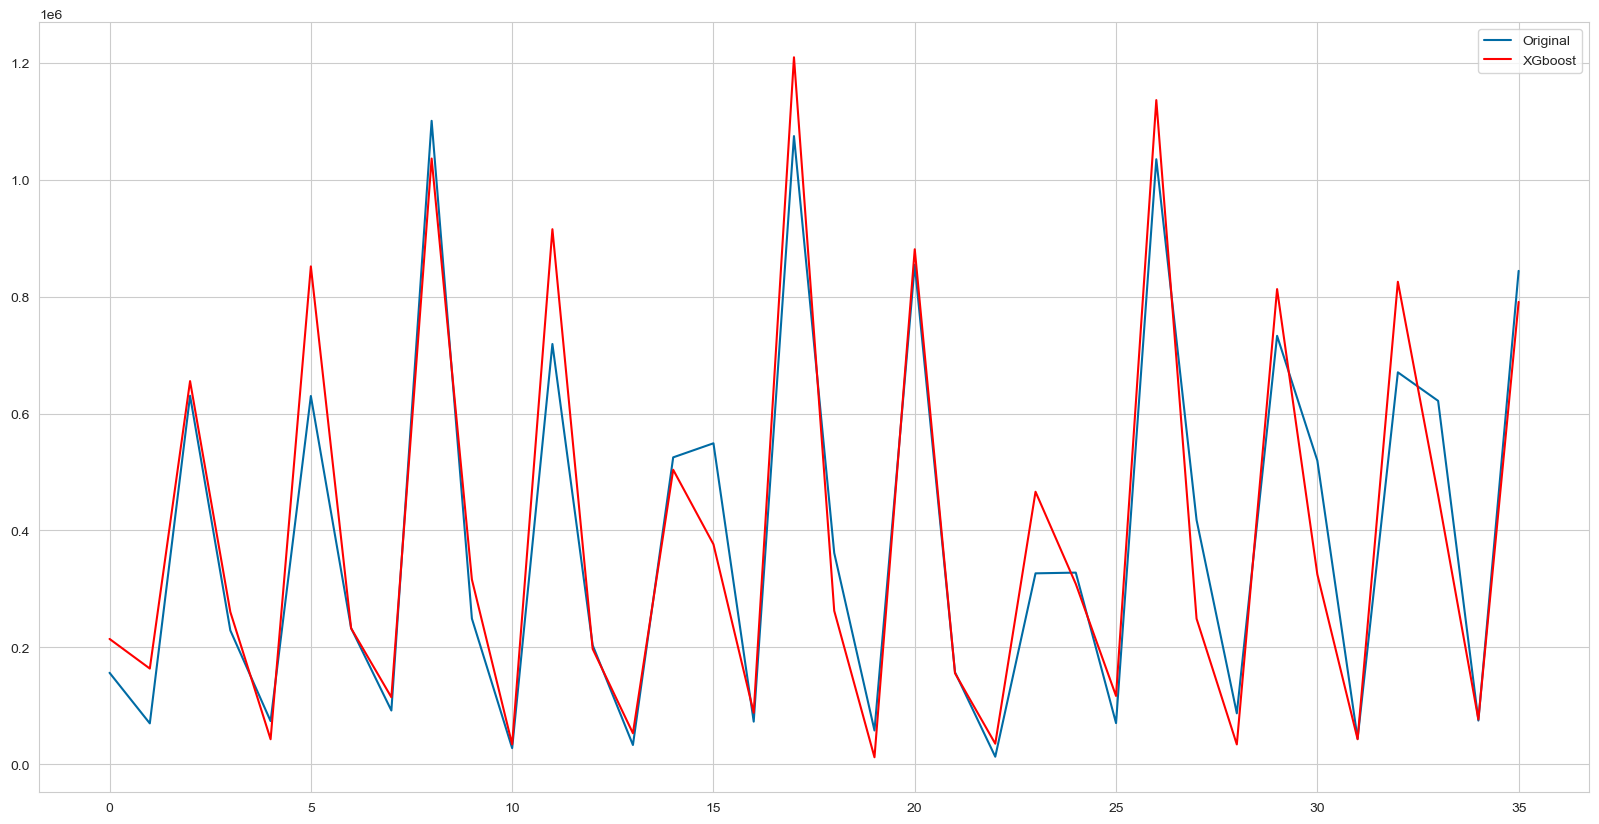

In [147]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [148]:
import pandas as pd

# Conversion de y_test et yhat en DataFrame avec les mêmes index que X_test
df_results = X_test.copy()  # Copie X_test pour ne pas modifier l'original
df_results["Valeur Réelle"] = y_test.values  # Ajout de y_test
df_results["Prédiction"] = yhat  # Ajout des prédictions


In [149]:
# Affichage des premières lignes
df_results.head()

Actual  quarter  month  year  quarter_sin   quarter_cos  REGION_AMERICA  \
216    16.0        1      1  2024          1.0  6.123234e-17             1.0   
217    16.0        1      1  2024          1.0  6.123234e-17             0.0   
218    16.0        1      1  2024          1.0  6.123234e-17             0.0   
219    20.0        1      2  2024          1.0  6.123234e-17             1.0   
220    20.0        1      2  2024          1.0  6.123234e-17             0.0   

     REGION_ASIA  REGION_EUROPE  Valeur Réelle     Prédiction  
216          0.0            0.0      156307.68  214261.218750  
217          1.0            0.0       69710.28  163522.984375  
218          0.0            1.0      630414.15  655471.750000  
219          0.0            0.0      228863.66  260408.109375  
220          1.0            0.0       73633.40   42536.964844

In [150]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Définition des hyperparamètres avec un plus grand espace de recherche
params = {
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [i / 10.0 for i in range(0, 8)],
    'subsample': [i / 10.0 for i in range(5, 11)],
    'colsample_bytree': [i / 10.0 for i in range(5, 11)],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Ajout du learning rate
    'n_estimators': [100, 500, 1000, 2000]  # Augmentation du nombre d'arbres
}

# Initialisation de XGBoost
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

# RandomizedSearchCV pour un tuning plus rapide
random_search = RandomizedSearchCV(xgb_reg, param_distributions=params, 
                                   n_iter=30, cv=5, verbose=1, n_jobs=-1)

# Entraînement du modèle optimisé
random_search.fit(X_train, y_train)

# Meilleur modèle trouvé
best_xgb = random_search.best_estimator_
print("Meilleur score R2 :", r2_score(y_test, best_xgb.predict(X_test)))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleur score R2 : 0.9105773462362761


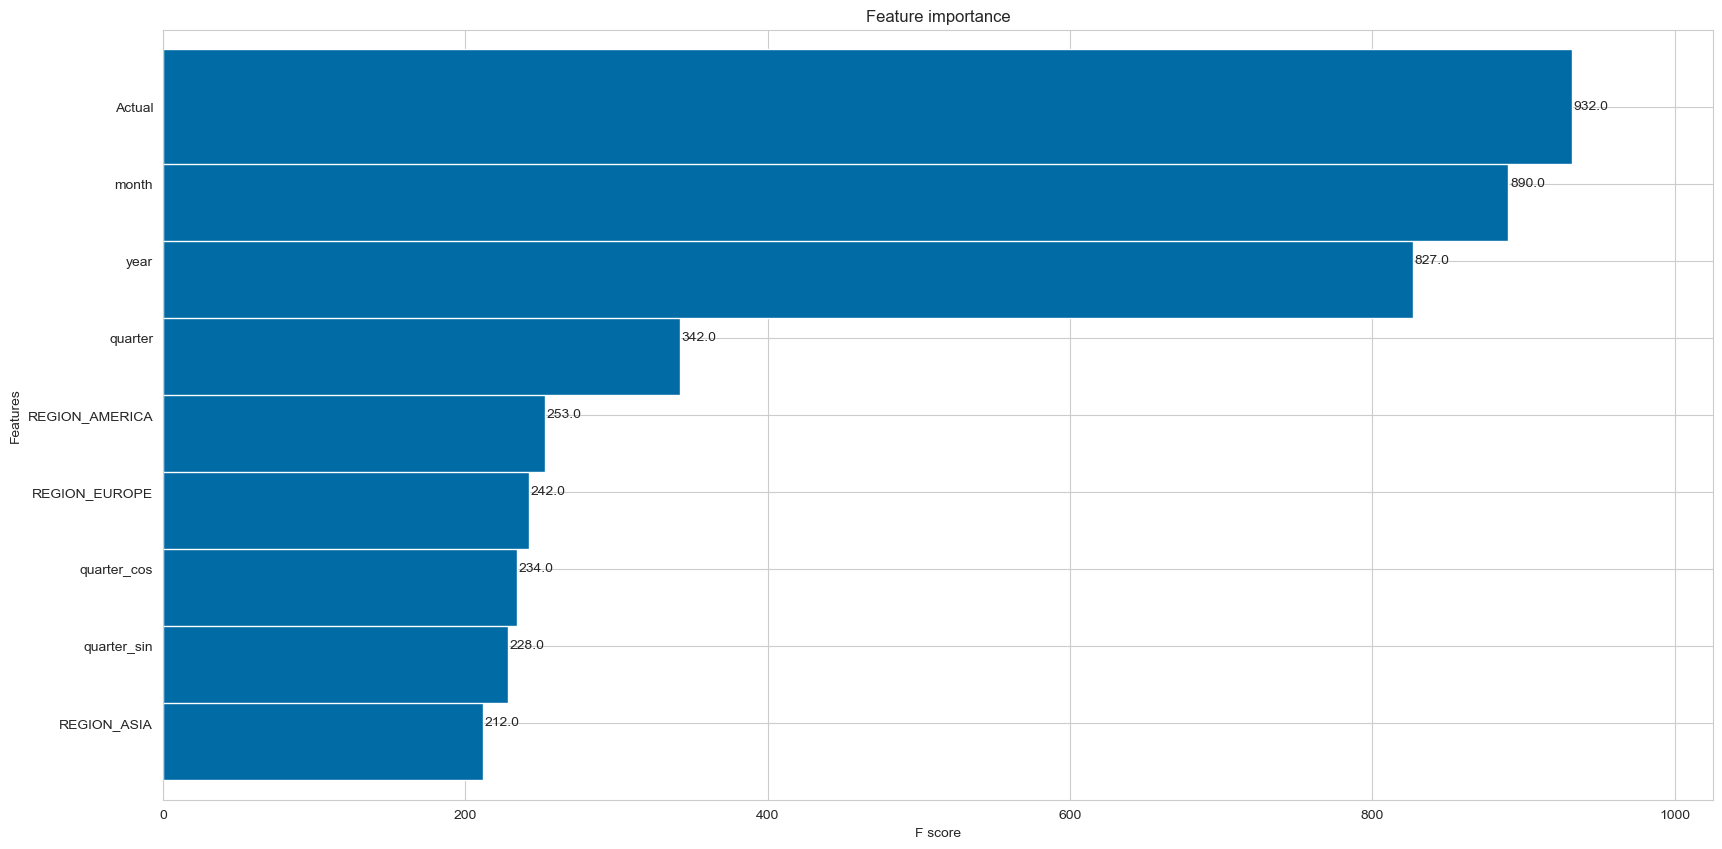

In [151]:
_ = plot_importance(best_xgb, height=1.5)

In [152]:
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [153]:
yhat = random_search.predict(X_test)
rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  98274.123197
MAE :  78375.242682


In [154]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 20.32%


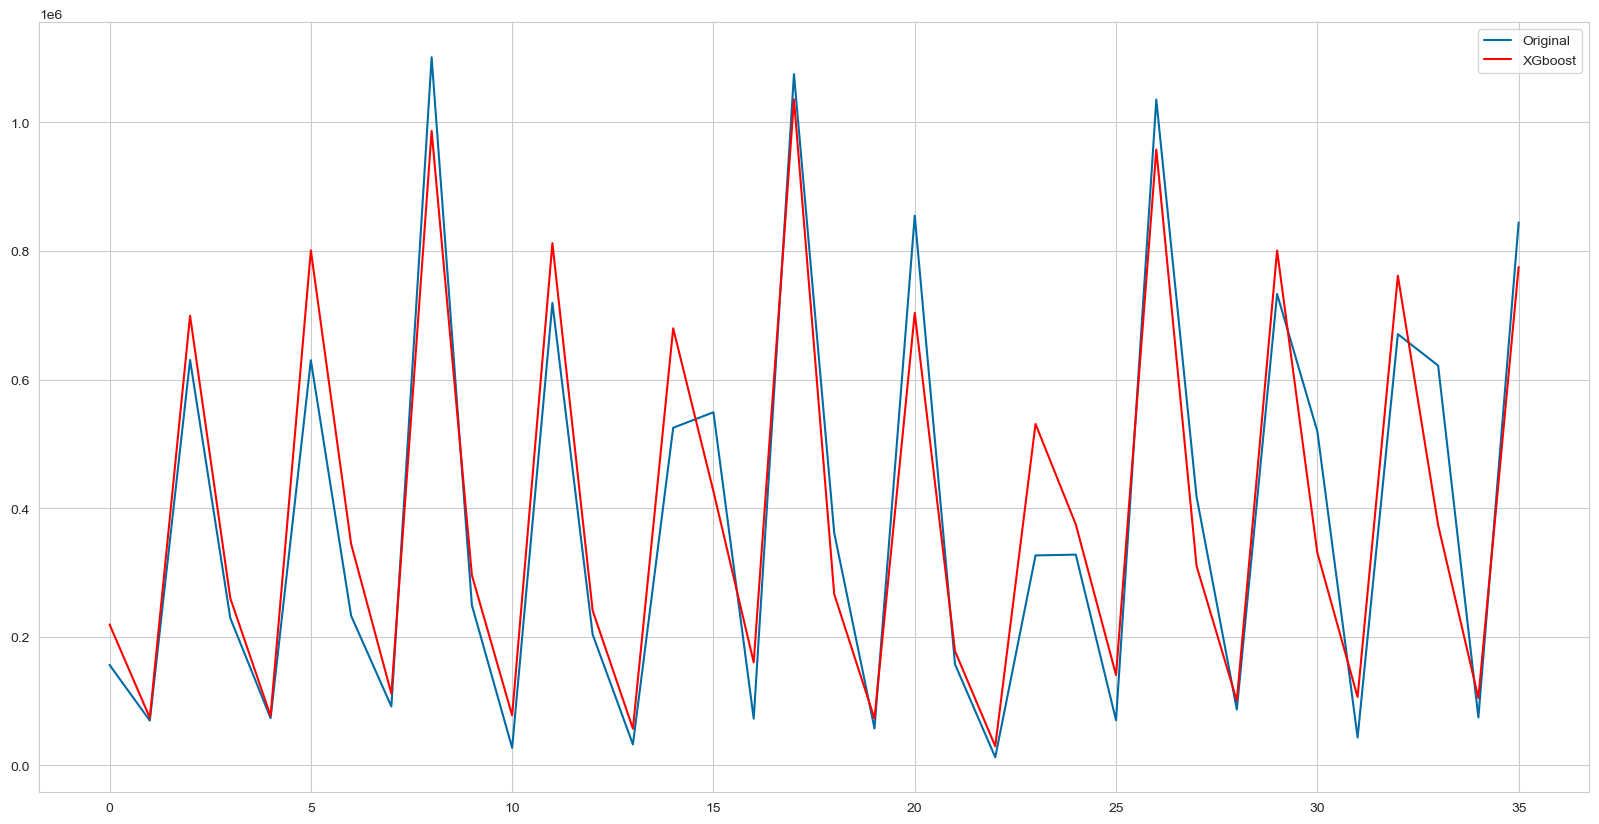

In [155]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

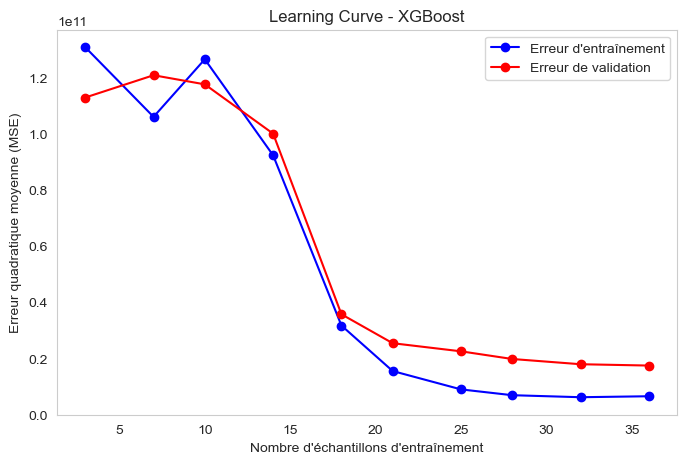

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Définition des splits temporels
tscv = TimeSeriesSplit(n_splits=5)

# Calcul de la learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Conversion en erreurs positives (MSE)
train_errors = -train_scores.mean(axis=1)
val_errors = -val_scores.mean(axis=1)

# Affichage des courbes
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors, "o-", label="Erreur d'entraînement", color="blue")
plt.plot(train_sizes, val_errors, "o-", label="Erreur de validation", color="red")

plt.xlabel("Nombre d'échantillons d'entraînement")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("Learning Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()

In [157]:
import optuna
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.model_selection import train_test_split

# Fonction d'optimisation avec Optuna
def objective(trial):
    # Espace de recherche des hyperparamètres
    params = {
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.7, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 500, 1000, 2000]),
        'n_jobs': -1,
        'objective': 'reg:squarederror'
    }

    # Initialisation du modèle
    xgb_reg = xgb.XGBRegressor(**params)

    # Entraînement du modèle
    xgb_reg.fit(X_train, y_train)

    # Prédictions sur le test set
    y_pred = xgb_reg.predict(X_test)

    # Calcul du RMSE
    rmse = np.sqrt(MSE(y_test, y_pred))

    return rmse  # On minimise le RMSE

# Lancement de l'optimisation avec Optuna
study = optuna.create_study(direction="minimize")  # Minimiser le RMSE
study.optimize(objective, n_trials=30)

# Meilleurs hyperparamètres trouvés
best_params = study.best_params
print("Meilleurs hyperparamètres :", best_params)

# Reconstruction du meilleur modèle avec les hyperparamètres optimaux
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)

# Prédictions finales
yhat = best_xgb.predict(X_test)



[I 2025-06-06 11:21:39,640] A new study created in memory with name: no-name-416144fa-1f3c-47b2-a22e-6fead5f03655
C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\1853738138.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
[I 2025-06-06 11:21:40,715] Trial 0 finished with value: 90760.09137920603 and parameters: {'min_child_weight': 5, 'gamma': 0.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'max_depth': 5, 'learning_rate': 0.03880912383956205, 'n_estimators': 500}. Best is trial 0 with value: 90760.09137920603.
C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\1853738138.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Meilleurs hyperparamètres : {'min_child_weight': 7, 'gamma': 0.4, 'subsample': 1.0, 'colsample_bytree': 0.6, 'max_depth': 4, 'learning_rate': 0.032974711541233166, 'n_estimators': 500}


In [158]:
# Évaluation du modèle optimisé
rmse = np.sqrt(MSE(y_test, yhat))
r2 = r2_score(y_test, yhat)

print("Meilleur score R2 :", r2)
print("RMSE : % f" % (rmse))

Meilleur score R2 : 0.9307149888712002
RMSE :  86503.772178


In [159]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 16.48%


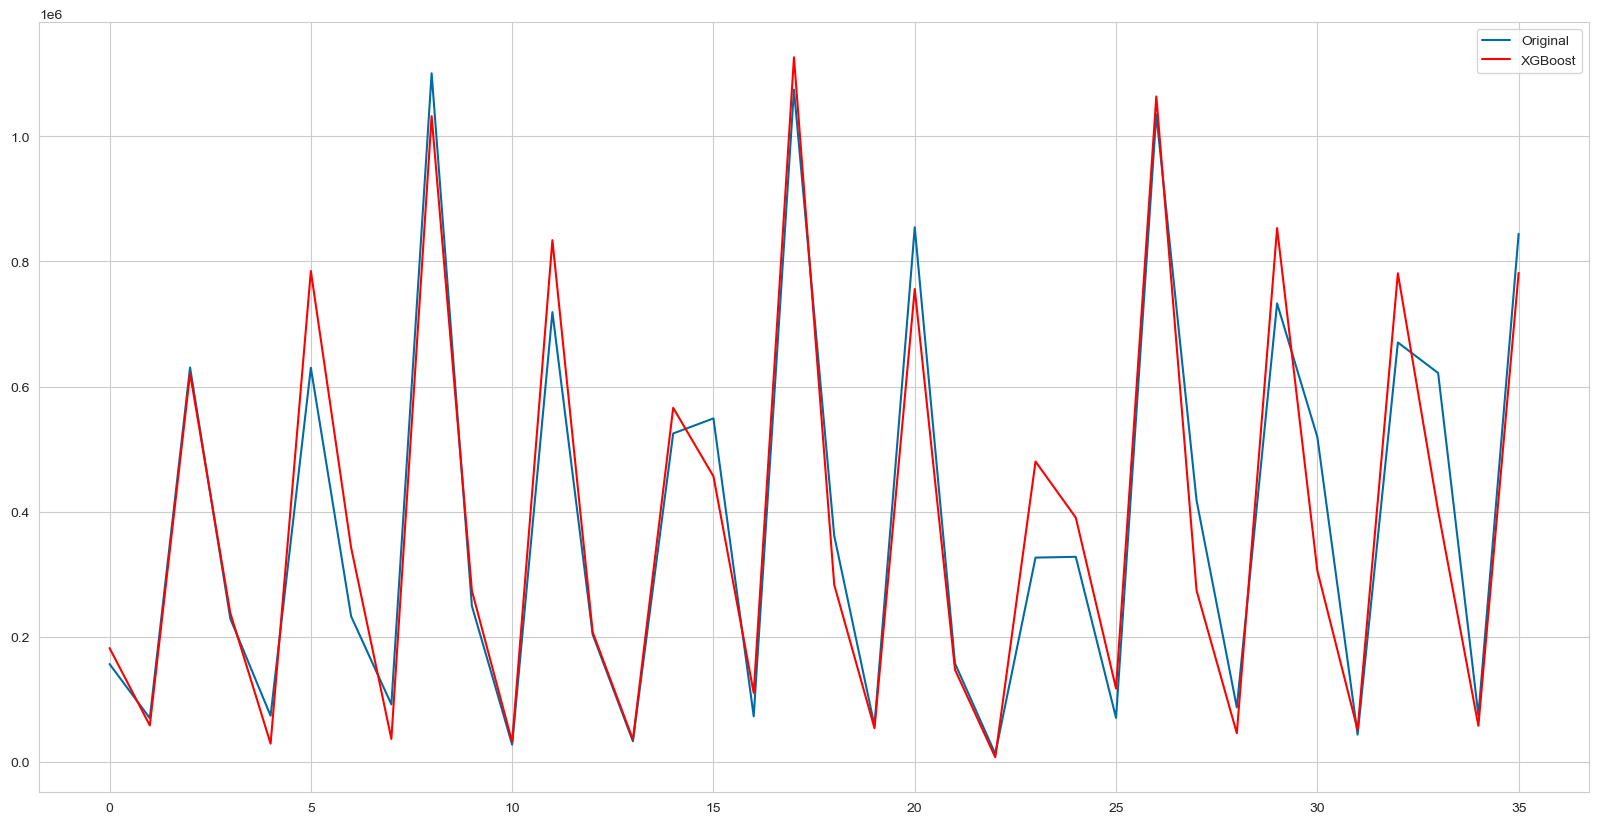

In [160]:
# Affichage des résultats
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGBoost')
plt.legend()
plt.show()

In [161]:


# Création du DataFrame final
df_result1 = pd.concat([
    X_test.reset_index(drop=True),
    pd.Series(y_test, name='y_test').reset_index(drop=True),
    pd.Series(yhat, name='yhat').reset_index(drop=True)
], axis=1)


In [162]:
df_result1.tail(10)

Actual  quarter  month  year   quarter_sin   quarter_cos  REGION_AMERICA  \
26    25.0        3      9  2024 -1.000000e+00 -1.836970e-16             0.0   
27    20.0        4     10  2024 -2.449294e-16  1.000000e+00             1.0   
28    20.0        4     10  2024 -2.449294e-16  1.000000e+00             0.0   
29    20.0        4     10  2024 -2.449294e-16  1.000000e+00             0.0   
30    18.0        4     11  2024 -2.449294e-16  1.000000e+00             1.0   
31    18.0        4     11  2024 -2.449294e-16  1.000000e+00             0.0   
32    18.0        4     11  2024 -2.449294e-16  1.000000e+00             0.0   
33    23.0        4     12  2024 -2.449294e-16  1.000000e+00             1.0   
34    23.0        4     12  2024 -2.449294e-16  1.000000e+00             0.0   
35    23.0        4     12  2024 -2.449294e-16  1.000000e+00             0.0   

    REGION_ASIA  REGION_EUROPE      y_test          yhat  
26          0.0            1.0  1035215.51  1.063919e+06  
27          0.0            0.0   417825.17  2.738372e+05  
28          1.0            0.0    86929.75  4.565736e+04  
29          0.0            1.0   733021.52  8.534461e+05  
30          0.0            0.0   519470.57  3.054176e+05  
31          1.0            0.0    43465.13  5.105120e+04  
32          0.0            1.0   670550.72  7.811776e+05  
33          0.0            0.0   621693.24  4.011429e+05  
34          1.0            0.0    74539.73  5.755546e+04  
35          0.0            1.0   844173.45  7.818505e+05

#### To change

In [164]:
df_train = df[(df['year'] < year) | ((df['year'] == year) & (df['month'] == MTD_train))]

X_train=df_train.drop(['Billings EURO'],axis=1)
y_train=df_train['Billings EURO']

In [165]:
#df_test=df[df['year']>=2024]
df_test = df[(df['year'] == year) & (df['month'].between(MTD_debut_test, MTD_fin_test))]


X_test=df_test.drop(['Billings EURO'],axis=1)
y_test=df_test['Billings EURO']

In [166]:
df_train.tail()

Actual  Billings EURO  quarter  month  year   quarter_sin   quarter_cos  \
250    23.0       74539.73        4     12  2024 -2.449294e-16  1.000000e+00   
251    23.0      844173.45        4     12  2024 -2.449294e-16  1.000000e+00   
255    20.0      373590.96        1      2  2025  1.000000e+00  6.123234e-17   
256    20.0       26706.16        1      2  2025  1.000000e+00  6.123234e-17   
257    20.0      614076.05        1      2  2025  1.000000e+00  6.123234e-17   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  
250             0.0          1.0            0.0  
251             0.0          0.0            1.0  
255             1.0          0.0            0.0  
256             0.0          1.0            0.0  
257             0.0          0.0            1.0

In [167]:
df_test.head()

Actual  Billings EURO  quarter  month  year   quarter_sin   quarter_cos  \
258    25.0      344675.78        1      3  2025  1.000000e+00  6.123234e-17   
259    25.0      101399.51        1      3  2025  1.000000e+00  6.123234e-17   
260    25.0     1047674.28        1      3  2025  1.000000e+00  6.123234e-17   
261    19.0      274368.06        2      4  2025  1.224647e-16 -1.000000e+00   
262    19.0       54901.18        2      4  2025  1.224647e-16 -1.000000e+00   

     REGION_AMERICA  REGION_ASIA  REGION_EUROPE  
258             1.0          0.0            0.0  
259             0.0          1.0            0.0  
260             0.0          0.0            1.0  
261             1.0          0.0            0.0  
262             0.0          1.0            0.0

In [168]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)

In [169]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  64759.524924
MAE :  52575.129533


In [170]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 13.21%


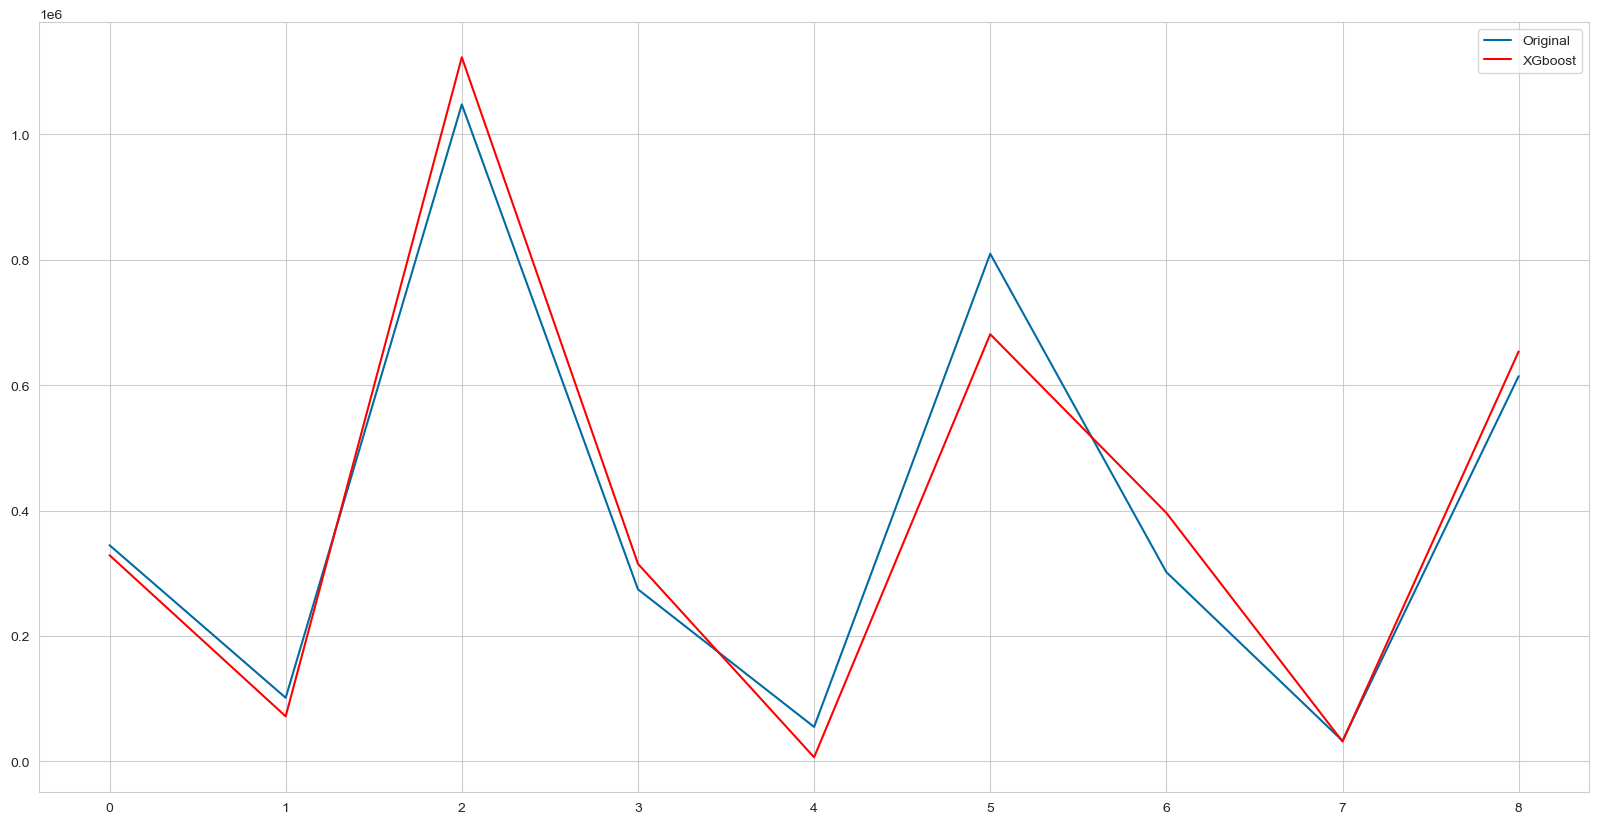

In [171]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [172]:
# Conversion de y_test et yhat en DataFrame avec les mêmes index que X_test
df_results = X_test.copy()  # Copie X_test pour ne pas modifier l'original
df_results["Valeur Réelle"] = y_test.values  # Ajout de y_test
df_results["Prédiction"] = yhat  # Ajout des prédictions

In [173]:
# Définition des hyperparamètres avec un plus grand espace de recherche
params = {
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [i / 10.0 for i in range(0, 8)],
    'subsample': [i / 10.0 for i in range(5, 11)],
    'colsample_bytree': [i / 10.0 for i in range(5, 11)],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Ajout du learning rate
    'n_estimators': [100, 500, 1000, 2000]  # Augmentation du nombre d'arbres
}

# Initialisation de XGBoost
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

# RandomizedSearchCV pour un tuning plus rapide
random_search = RandomizedSearchCV(xgb_reg, param_distributions=params, 
                                   n_iter=30, cv=5, verbose=1, n_jobs=-1)

# Entraînement du modèle optimisé
random_search.fit(X_train, y_train)

# Meilleur modèle trouvé
best_xgb = random_search.best_estimator_
print("Meilleur score R2 :", r2_score(y_test, best_xgb.predict(X_test)))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleur score R2 : 0.9735854236789021


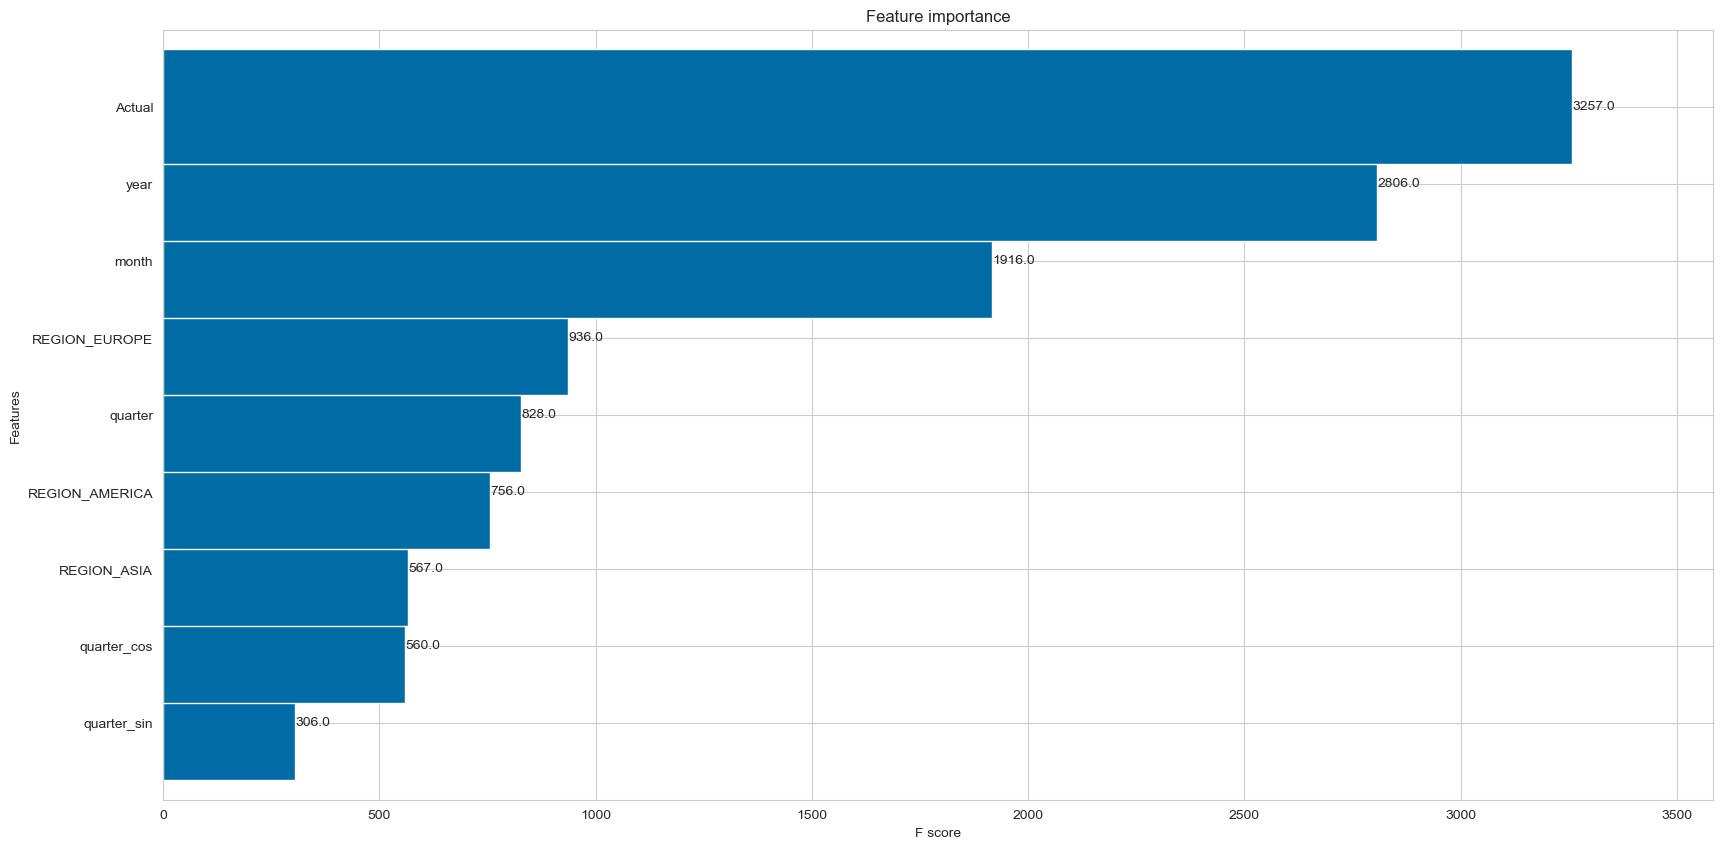

In [174]:
_ = plot_importance(best_xgb, height=1.5)

In [175]:
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [176]:
yhat = random_search.predict(X_test)
rmse = np.sqrt(MSE(y_test, yhat))
mae = MAE(y_test, yhat)

print("RMSE : % f" %(rmse))
print("MAE : % f" % (mae))

RMSE :  54301.444766
MAE :  36713.094939


In [177]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 9.23%


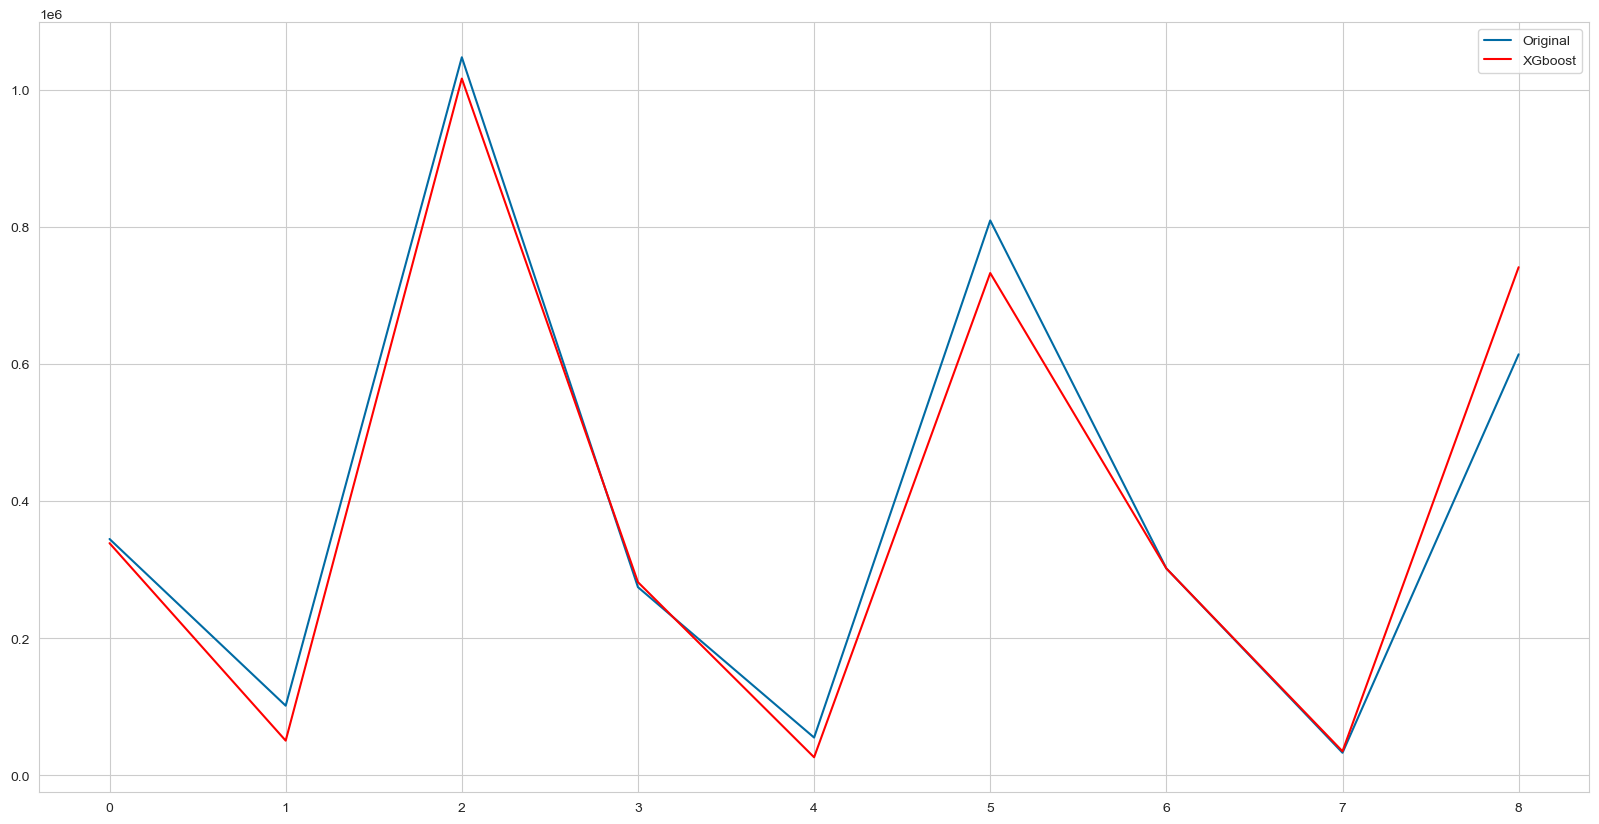

In [178]:
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

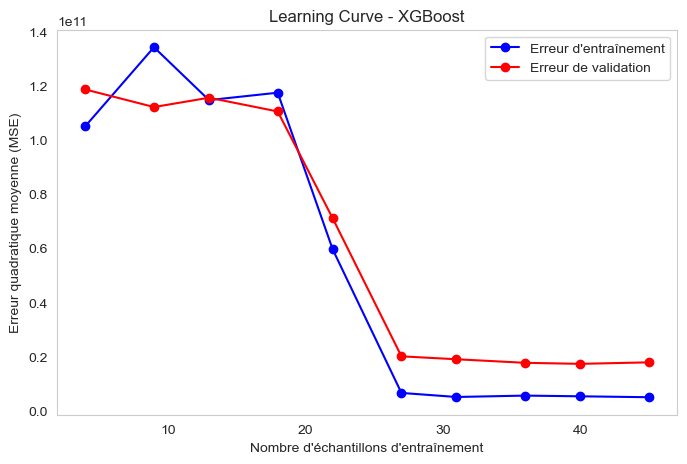

In [179]:
# Définition des splits temporels
tscv = TimeSeriesSplit(n_splits=5)

# Calcul de la learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Conversion en erreurs positives (MSE)
train_errors = -train_scores.mean(axis=1)
val_errors = -val_scores.mean(axis=1)

# Affichage des courbes
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors, "o-", label="Erreur d'entraînement", color="blue")
plt.plot(train_sizes, val_errors, "o-", label="Erreur de validation", color="red")

plt.xlabel("Nombre d'échantillons d'entraînement")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("Learning Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()

In [180]:
# Fonction d'optimisation avec Optuna
def objective(trial):
    # Espace de recherche des hyperparamètres
    params = {
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.7, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 500, 1000, 2000]),
        'n_jobs': -1,
        'objective': 'reg:squarederror'
    }

    # Initialisation du modèle
    xgb_reg = xgb.XGBRegressor(**params)

    # Entraînement du modèle
    xgb_reg.fit(X_train, y_train)

    # Prédictions sur le test set
    y_pred = xgb_reg.predict(X_test)

    # Calcul du RMSE
    rmse = np.sqrt(MSE(y_test, y_pred))

    return rmse  # On minimise le RMSE

# Lancement de l'optimisation avec Optuna
study = optuna.create_study(direction="minimize")  # Minimiser le RMSE
study.optimize(objective, n_trials=30)

# Meilleurs hyperparamètres trouvés
best_params = study.best_params
print("Meilleurs hyperparamètres :", best_params)

# Reconstruction du meilleur modèle avec les hyperparamètres optimaux
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)

# Prédictions finales
yhat = best_xgb.predict(X_test)

[I 2025-06-06 11:24:32,246] A new study created in memory with name: no-name-392458fb-1be1-48af-b093-9b1db801255e
C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\808818040.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
[I 2025-06-06 11:24:33,761] Trial 0 finished with value: 49263.54165214161 and parameters: {'min_child_weight': 5, 'gamma': 0.0, 'subsample': 1.0, 'colsample_bytree': 0.9, 'max_depth': 3, 'learning_rate': 0.17036267489727636, 'n_estimators': 1000}. Best is trial 0 with value: 49263.54165214161.
C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\808818040.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Meilleurs hyperparamètres : {'min_child_weight': 2, 'gamma': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7, 'max_depth': 4, 'learning_rate': 0.0891409956390845, 'n_estimators': 1000}


In [181]:
# Évaluation du modèle optimisé
rmse = np.sqrt(MSE(y_test, yhat))
r2 = r2_score(y_test, yhat)

print("Meilleur score R2 :", r2)
print("RMSE : % f" % (rmse))

Meilleur score R2 : 0.9838057507228088
RMSE :  42517.720258


In [182]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : 7.67%


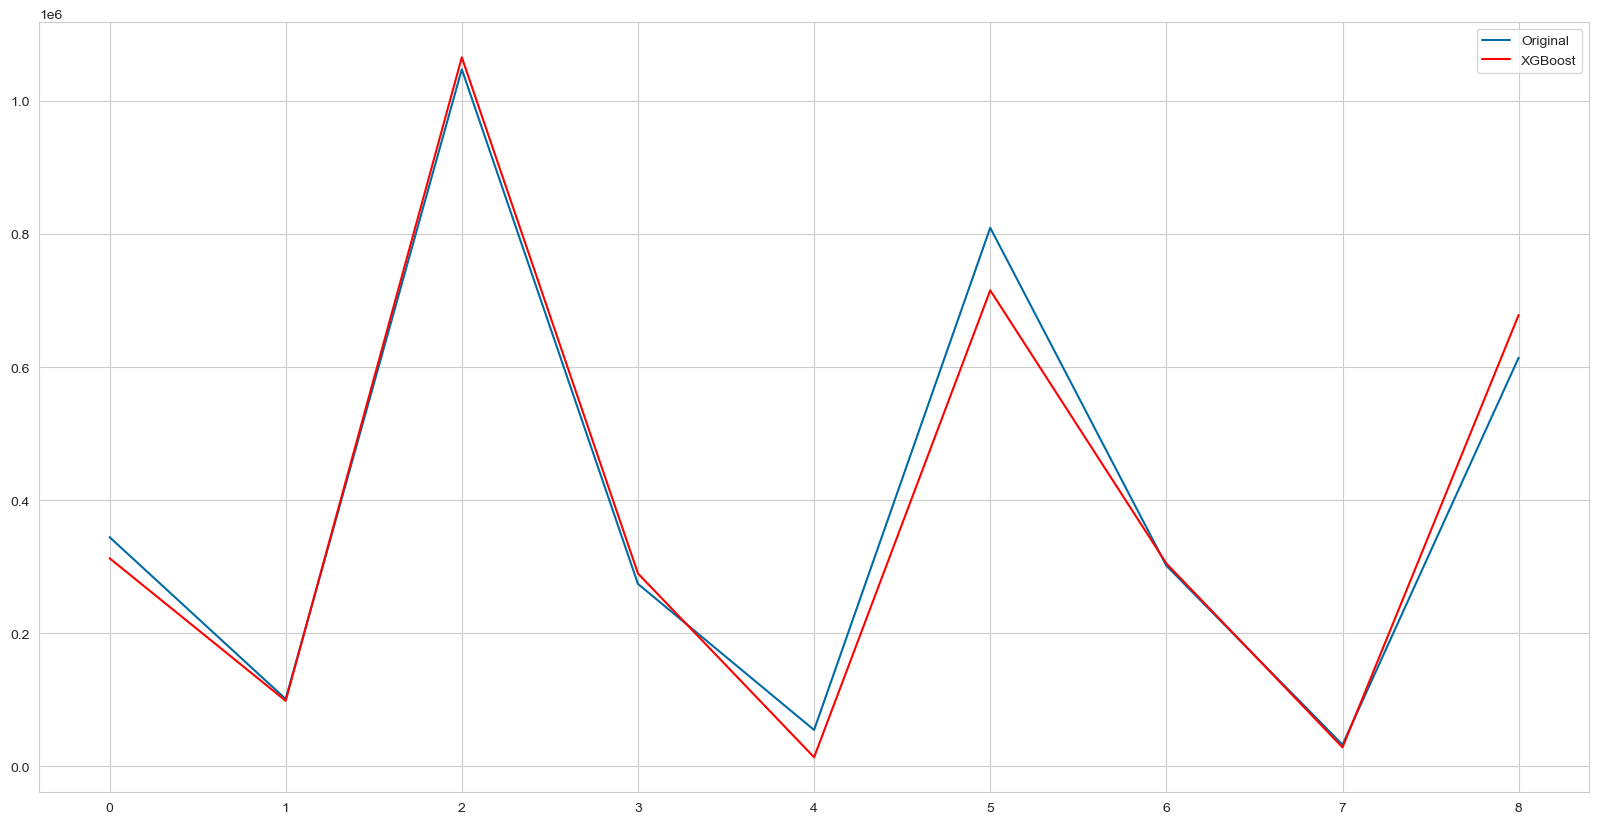

In [183]:
# Affichage des résultats
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGBoost')
plt.legend()
plt.show()

In [184]:
# Création du DataFrame final
df_result2 = pd.concat([
    X_test.reset_index(drop=True),
    pd.Series(y_test, name='y_test').reset_index(drop=True),
    pd.Series(yhat, name='yhat').reset_index(drop=True)
], axis=1)

In [185]:
df_result2

Actual  quarter  month  year   quarter_sin   quarter_cos  REGION_AMERICA  \
0    25.0        1      3  2025  1.000000e+00  6.123234e-17             1.0   
1    25.0        1      3  2025  1.000000e+00  6.123234e-17             0.0   
2    25.0        1      3  2025  1.000000e+00  6.123234e-17             0.0   
3    19.0        2      4  2025  1.224647e-16 -1.000000e+00             1.0   
4    19.0        2      4  2025  1.224647e-16 -1.000000e+00             0.0   
5    19.0        2      4  2025  1.224647e-16 -1.000000e+00             0.0   
6    18.0        2      5  2025  1.224647e-16 -1.000000e+00             1.0   
7    18.0        2      5  2025  1.224647e-16 -1.000000e+00             0.0   
8    18.0        2      5  2025  1.224647e-16 -1.000000e+00             0.0   

   REGION_ASIA  REGION_EUROPE      y_test          yhat  
0          0.0            0.0   344675.78  3.129267e+05  
1          1.0            0.0   101399.51  9.873805e+04  
2          0.0            1.0  1047674.28  1.065666e+06  
3          0.0            0.0   274368.06  2.900628e+05  
4          1.0            0.0    54901.18  1.384729e+04  
5          0.0            1.0   809530.31  7.154820e+05  
6          0.0            0.0   301749.17  3.050724e+05  
7          1.0            0.0    32740.79  2.875324e+04  
8          0.0            1.0   614186.34  6.784298e+05

#### To change

In [187]:
#df_test=df[df['year']>=2024]
df_test = df[(df['year'] == year) & (df['month'].between(debut_predict, fin_predict))]


X_test=df_test.drop(['Billings EURO'],axis=1)
y_test=df_test['Billings EURO']

In [188]:
# Prédictions finales
yhat = best_xgb.predict(X_test)

In [189]:
# Évaluation du modèle optimisé
rmse = np.sqrt(MSE(y_test, yhat))
r2 = r2_score(y_test, yhat)

print("Meilleur score R2 :", r2)
print("RMSE : % f" % (rmse))

Meilleur score R2 : 0.0
RMSE :  549318.819952


In [190]:
mae = MAE(y_test, yhat)

# Calcul du MAE en pourcentage
mae_percentage = (mae / np.mean(y_test)) * 100

print("MAE en pourcentage : %.2f%%" % mae_percentage)

MAE en pourcentage : inf%


C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\2921755809.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  mae_percentage = (mae / np.mean(y_test)) * 100


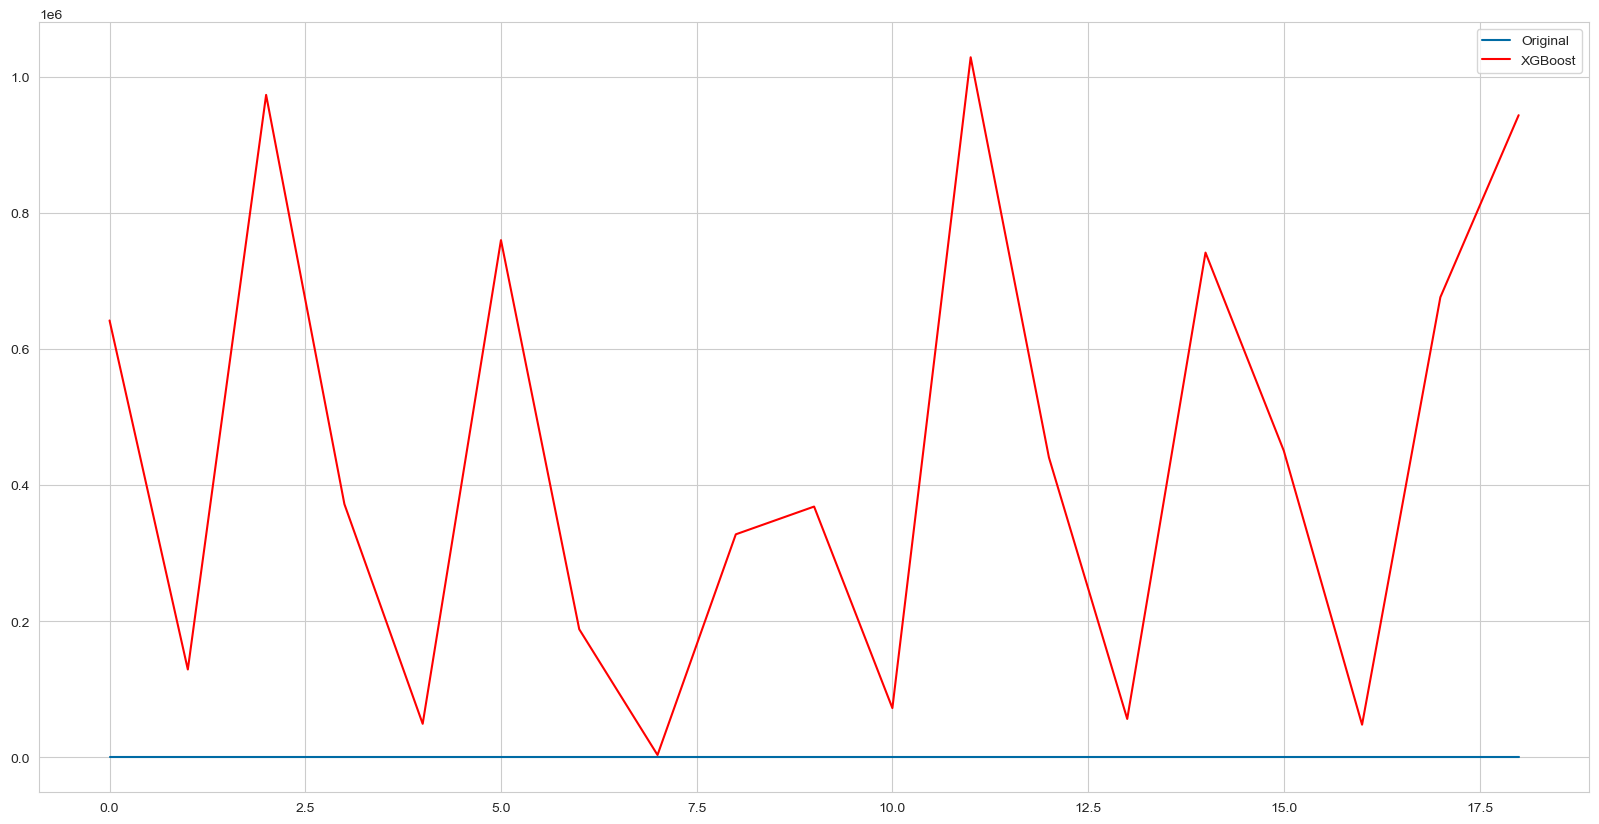

In [191]:
# Affichage des résultats
plt.plot(y_test.values, label='Original')
plt.plot(yhat, color='red', label='XGBoost')
plt.legend()
plt.show()

In [192]:
# Création du DataFrame final
df_result3 = pd.concat([
    X_test.reset_index(drop=True),
    pd.Series(y_test, name='y_test').reset_index(drop=True),
    pd.Series(yhat, name='yhat').reset_index(drop=True)
], axis=1)

In [193]:
df_result3

Actual  quarter  month  year   quarter_sin   quarter_cos  REGION_AMERICA  \
0     23.0        2      6  2025  1.224647e-16 -1.000000e+00             1.0   
1     23.0        2      6  2025  1.224647e-16 -1.000000e+00             0.0   
2     23.0        2      6  2025  1.224647e-16 -1.000000e+00             0.0   
3     19.0        3      7  2025 -1.000000e+00 -1.836970e-16             1.0   
4     19.0        3      7  2025 -1.000000e+00 -1.836970e-16             0.0   
5     19.0        3      7  2025 -1.000000e+00 -1.836970e-16             0.0   
6      5.0        3      8  2025 -1.000000e+00 -1.836970e-16             1.0   
7      5.0        3      8  2025 -1.000000e+00 -1.836970e-16             0.0   
8      5.0        3      8  2025 -1.000000e+00 -1.836970e-16             0.0   
9     25.0        3      9  2025 -1.000000e+00 -1.836970e-16             1.0   
10    25.0        3      9  2025 -1.000000e+00 -1.836970e-16             0.0   
11    25.0        3      9  2025 -1.000000e+00 -1.836970e-16             0.0   
12    20.0        4     10  2025 -2.449294e-16  1.000000e+00             1.0   
13    20.0        4     10  2025 -2.449294e-16  1.000000e+00             0.0   
14    20.0        4     10  2025 -2.449294e-16  1.000000e+00             0.0   
15    19.0        4     11  2025 -2.449294e-16  1.000000e+00             1.0   
16    19.0        4     11  2025 -2.449294e-16  1.000000e+00             0.0   
17    19.0        4     11  2025 -2.449294e-16  1.000000e+00             0.0   
18    26.0        4     12  2025 -2.449294e-16  1.000000e+00             0.0   

    REGION_ASIA  REGION_EUROPE  y_test          yhat  
0           0.0            0.0     0.0  6.417203e+05  
1           1.0            0.0     0.0  1.289639e+05  
2           0.0            1.0     0.0  9.731342e+05  
3           0.0            0.0     0.0  3.719684e+05  
4           1.0            0.0     0.0  4.916875e+04  
5           0.0            1.0     0.0  7.597685e+05  
6           0.0            0.0     0.0  1.880873e+05  
7           1.0            0.0     0.0  3.375360e+03  
8           0.0            1.0     0.0  3.275564e+05  
9           0.0            0.0     0.0  3.683267e+05  
10          1.0            0.0     0.0  7.227539e+04  
11          0.0            1.0     0.0  1.028406e+06  
12          0.0            0.0     0.0  4.404350e+05  
13          1.0            0.0     0.0  5.633400e+04  
14          0.0            1.0     0.0  7.414415e+05  
15          0.0            0.0     0.0  4.503462e+05  
16          1.0            0.0     0.0  4.789588e+04  
17          0.0            1.0     0.0  6.758612e+05  
18          0.0            1.0     0.0  9.433159e+05

In [194]:
#  concaténer df_result1, df_result2 et df_result3 

df_final = pd.concat([df_result1, df_result2, df_result3], ignore_index=True)


In [195]:
df_final.head(50)

Actual  quarter  month  year   quarter_sin   quarter_cos  REGION_AMERICA  \
0     16.0        1      1  2024  1.000000e+00  6.123234e-17             1.0   
1     16.0        1      1  2024  1.000000e+00  6.123234e-17             0.0   
2     16.0        1      1  2024  1.000000e+00  6.123234e-17             0.0   
3     20.0        1      2  2024  1.000000e+00  6.123234e-17             1.0   
4     20.0        1      2  2024  1.000000e+00  6.123234e-17             0.0   
5     20.0        1      2  2024  1.000000e+00  6.123234e-17             0.0   
6     25.0        1      3  2024  1.000000e+00  6.123234e-17             1.0   
7     25.0        1      3  2024  1.000000e+00  6.123234e-17             0.0   
8     25.0        1      3  2024  1.000000e+00  6.123234e-17             0.0   
9     19.0        2      4  2024  1.224647e-16 -1.000000e+00             1.0   
10    19.0        2      4  2024  1.224647e-16 -1.000000e+00             0.0   
11    19.0        2      4  2024  1.224647e-16 -1.000000e+00             0.0   
12    15.0        2      5  2024  1.224647e-16 -1.000000e+00             1.0   
13    15.0        2      5  2024  1.224647e-16 -1.000000e+00             0.0   
14    15.0        2      5  2024  1.224647e-16 -1.000000e+00             0.0   
15    25.0        2      6  2024  1.224647e-16 -1.000000e+00             1.0   
16    25.0        2      6  2024  1.224647e-16 -1.000000e+00             0.0   
17    25.0        2      6  2024  1.224647e-16 -1.000000e+00             0.0   
18    20.0        3      7  2024 -1.000000e+00 -1.836970e-16             1.0   
19    20.0        3      7  2024 -1.000000e+00 -1.836970e-16             0.0   
20    20.0        3      7  2024 -1.000000e+00 -1.836970e-16             0.0   
21     5.0        3      8  2024 -1.000000e+00 -1.836970e-16             1.0   
22     5.0        3      8  2024 -1.000000e+00 -1.836970e-16             0.0   
23     5.0        3      8  2024 -1.000000e+00 -1.836970e-16             0.0   
24    25.0        3      9  2024 -1.000000e+00 -1.836970e-16             1.0   
25    25.0        3      9  2024 -1.000000e+00 -1.836970e-16             0.0   
26    25.0        3      9  2024 -1.000000e+00 -1.836970e-16             0.0   
27    20.0        4     10  2024 -2.449294e-16  1.000000e+00             1.0   
28    20.0        4     10  2024 -2.449294e-16  1.000000e+00             0.0   
29    20.0        4     10  2024 -2.449294e-16  1.000000e+00             0.0   
30    18.0        4     11  2024 -2.449294e-16  1.000000e+00             1.0   
31    18.0        4     11  2024 -2.449294e-16  1.000000e+00             0.0   
32    18.0        4     11  2024 -2.449294e-16  1.000000e+00             0.0   
33    23.0        4     12  2024 -2.449294e-16  1.000000e+00             1.0   
34    23.0        4     12  2024 -2.449294e-16  1.000000e+00             0.0   
35    23.0        4     12  2024 -2.449294e-16  1.000000e+00             0.0   
36    25.0        1      3  2025  1.000000e+00  6.123234e-17             1.0   
37    25.0        1      3  2025  1.000000e+00  6.123234e-17             0.0   
38    25.0        1      3  2025  1.000000e+00  6.123234e-17             0.0   
39    19.0        2      4  2025  1.224647e-16 -1.000000e+00             1.0   
40    19.0        2      4  2025  1.224647e-16 -1.000000e+00             0.0   
41    19.0        2      4  2025  1.224647e-16 -1.000000e+00             0.0   
42    18.0        2      5  2025  1.224647e-16 -1.000000e+00             1.0   
43    18.0        2      5  2025  1.224647e-16 -1.000000e+00             0.0   
44    18.0        2      5  2025  1.224647e-16 -1.000000e+00             0.0   
45    23.0        2      6  2025  1.224647e-16 -1.000000e+00             1.0   
46    23.0        2      6  2025  1.224647e-16 -1.000000e+00             0.0   
47    23.0        2      6  2025  1.224647e-16 -1.000000e+00             0.0   
48    19.0        3      7  2025 -1.000000e+00 -1.836970e-16             1.0   
49  

In [196]:
df_encoded_1 = df_final[['REGION_AMERICA','REGION_ASIA','REGION_EUROPE']]

In [197]:
# Reconstruction de la colonne REGION

df_encoded_1['REGION'] = encoder.inverse_transform(df_encoded_1).squeeze()

C:\Users\rtekem\AppData\Local\Temp\ipykernel_8076\1352410664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_1['REGION'] = encoder.inverse_transform(df_encoded_1).squeeze()


In [198]:
df_encoded_1 = df_encoded_1.drop(columns=['REGION_AMERICA','REGION_ASIA','REGION_EUROPE'])

In [199]:
# ✅ Fusion avec df sans REGION
df_final = df_final.join(df_encoded_1)

In [200]:
df_final.head()

Actual  quarter  month  year  quarter_sin   quarter_cos  REGION_AMERICA  \
0    16.0        1      1  2024          1.0  6.123234e-17             1.0   
1    16.0        1      1  2024          1.0  6.123234e-17             0.0   
2    16.0        1      1  2024          1.0  6.123234e-17             0.0   
3    20.0        1      2  2024          1.0  6.123234e-17             1.0   
4    20.0        1      2  2024          1.0  6.123234e-17             0.0   

   REGION_ASIA  REGION_EUROPE     y_test           yhat   REGION  
0          0.0            0.0  156307.68  181832.703125  AMERICA  
1          1.0            0.0   69710.28   58103.636719     ASIA  
2          0.0            1.0  630414.15  621216.687500   EUROPE  
3          0.0            0.0  228863.66  237653.593750  AMERICA  
4          1.0            0.0   73633.40   28958.244141     ASIA

In [201]:
df_final  = df_final.drop(columns=['REGION_AMERICA','REGION_ASIA','REGION_EUROPE'])

In [202]:
df_final.head()

Actual  quarter  month  year  quarter_sin   quarter_cos     y_test  \
0    16.0        1      1  2024          1.0  6.123234e-17  156307.68   
1    16.0        1      1  2024          1.0  6.123234e-17   69710.28   
2    16.0        1      1  2024          1.0  6.123234e-17  630414.15   
3    20.0        1      2  2024          1.0  6.123234e-17  228863.66   
4    20.0        1      2  2024          1.0  6.123234e-17   73633.40   

            yhat   REGION  
0  181832.703125  AMERICA  
1   58103.636719     ASIA  
2  621216.687500   EUROPE  
3  237653.593750  AMERICA  
4   28958.244141     ASIA

In [203]:
# Condition sur la colonne REGION
df_final['Material Grp 3'] = df_final['REGION'].apply(lambda x: 'VISHAY SA' if x == 'CN' else 'VISHAY SA')

df_final = df_final.rename(columns={
    'y_test': 'Valeur Réelle',
    'yhat': 'Prédiction'
})


In [204]:
# Affichage des résultats
tekem = df_final[['month','Valeur Réelle','Prédiction']]

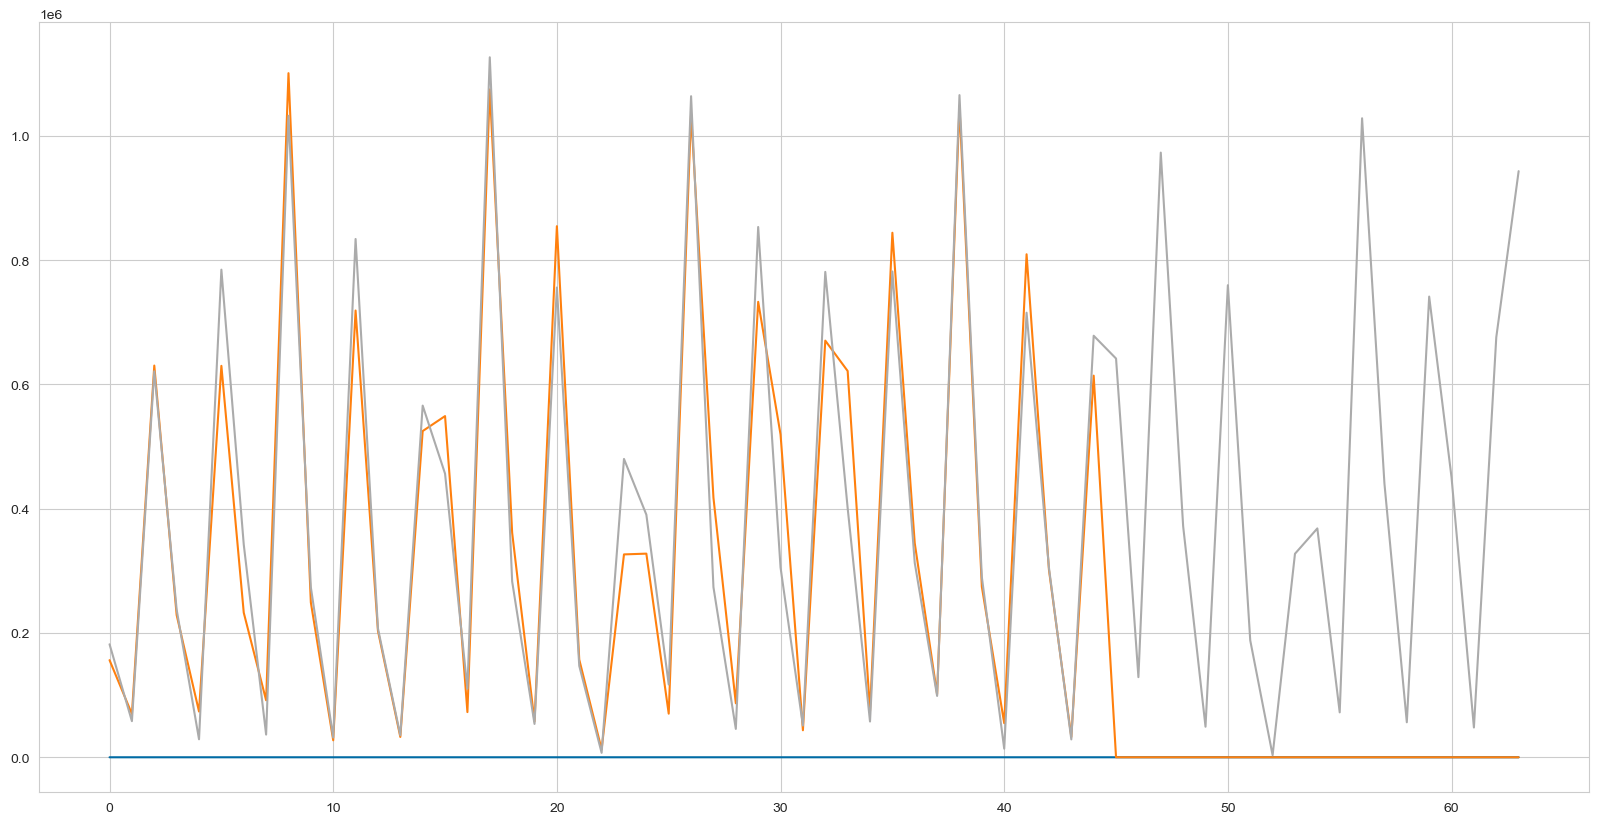

In [205]:
plt.plot(tekem)

In [206]:
df_FP1=df_final.copy()

In [207]:
df_FP1['periode'] = df_FP1['year'].astype(str) + "-" + df_FP1['month'].astype(str).str.zfill(2)

df_FP1.head()

Actual  quarter  month  year  quarter_sin   quarter_cos  Valeur Réelle  \
0    16.0        1      1  2024          1.0  6.123234e-17      156307.68   
1    16.0        1      1  2024          1.0  6.123234e-17       69710.28   
2    16.0        1      1  2024          1.0  6.123234e-17      630414.15   
3    20.0        1      2  2024          1.0  6.123234e-17      228863.66   
4    20.0        1      2  2024          1.0  6.123234e-17       73633.40   

      Prédiction   REGION Material Grp 3  periode  
0  181832.703125  AMERICA      VISHAY SA  2024-01  
1   58103.636719     ASIA      VISHAY SA  2024-01  
2  621216.687500   EUROPE      VISHAY SA  2024-01  
3  237653.593750  AMERICA      VISHAY SA  2024-02  
4   28958.244141     ASIA      VISHAY SA  2024-02

In [208]:
# Conversion de la colonne "periode" en type datetime
df_FP1['periode'] = pd.to_datetime(df_FP1['periode'], format='%Y-%m')

df_FP1.head()

Actual  quarter  month  year  quarter_sin   quarter_cos  Valeur Réelle  \
0    16.0        1      1  2024          1.0  6.123234e-17      156307.68   
1    16.0        1      1  2024          1.0  6.123234e-17       69710.28   
2    16.0        1      1  2024          1.0  6.123234e-17      630414.15   
3    20.0        1      2  2024          1.0  6.123234e-17      228863.66   
4    20.0        1      2  2024          1.0  6.123234e-17       73633.40   

      Prédiction   REGION Material Grp 3    periode  
0  181832.703125  AMERICA      VISHAY SA 2024-01-01  
1   58103.636719     ASIA      VISHAY SA 2024-01-01  
2  621216.687500   EUROPE      VISHAY SA 2024-01-01  
3  237653.593750  AMERICA      VISHAY SA 2024-02-01  
4   28958.244141     ASIA      VISHAY SA 2024-02-01

In [209]:
# Regrouper par période et sommer les valeurs
df_somme = df_FP1.groupby('periode')[['Valeur Réelle', 'Prédiction']].sum().reset_index()

# Afficher le résultat
print(df_somme)

      periode  Valeur Réelle    Prédiction
0  2024-01-01      856432.11  8.611530e+05
1  2024-02-01      932476.04  1.051367e+06
2  2024-03-01     1425435.10  1.411378e+06
3  2024-04-01      995455.24  1.139399e+06
4  2024-05-01      761201.40  8.087114e+05
5  2024-06-01     1696635.60  1.693256e+06
6  2024-07-01     1273784.88  1.092804e+06
7  2024-08-01      496447.44  6.345483e+05
8  2024-09-01     1433138.12  1.571516e+06
9  2024-10-01     1237776.44  1.172941e+06
10 2024-11-01     1233486.42  1.137646e+06
11 2024-12-01     1540406.42  1.240549e+06
12 2025-03-01     1493749.57  1.477331e+06
13 2025-04-01     1138799.55  1.019392e+06
14 2025-05-01      948676.30  1.012256e+06
15 2025-06-01           0.00  1.743818e+06
16 2025-07-01           0.00  1.180906e+06
17 2025-08-01           0.00  5.190191e+05
18 2025-09-01           0.00  1.469008e+06
19 2025-10-01           0.00  1.238210e+06
20 2025-11-01           0.00  1.174103e+06
21 2025-12-01           0.00  9.433159e+05


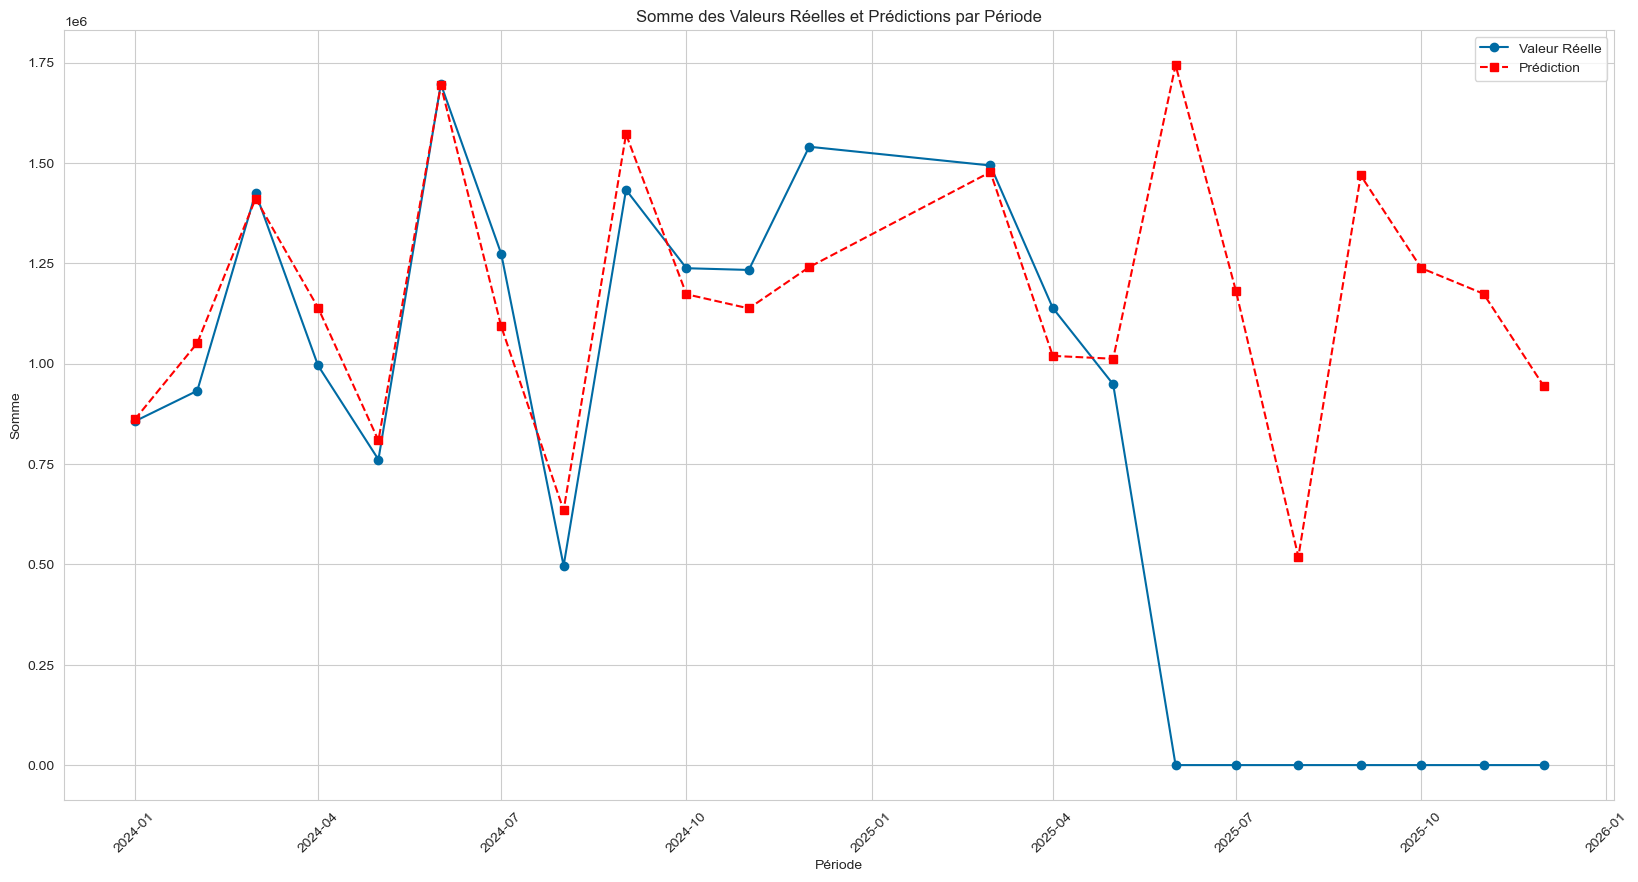

In [210]:
plt.plot(df_somme['periode'], df_somme['Valeur Réelle'], label='Valeur Réelle', marker='o')
plt.plot(df_somme['periode'], df_somme['Prédiction'], label='Prédiction', marker='s', linestyle='dashed', color='red')

plt.xlabel('Période')
plt.ylabel('Somme')
plt.title('Somme des Valeurs Réelles et Prédictions par Période')
plt.legend()
plt.xticks(rotation=45)  # Rotation des dates pour meilleure lisibilité
plt.grid(True)
plt.show()